In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from scipy.stats import norm
from torch import nn
import time
import datetime

In [2]:
from torch.autograd.functional import hessian

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Try with different functions and noise

In [4]:
def function_sinus(amp, phase, x):
    return amp*np.sin(phase+x)

In [5]:
def noise(epsilon):
    return epsilon * np.random.normal(0, 1)

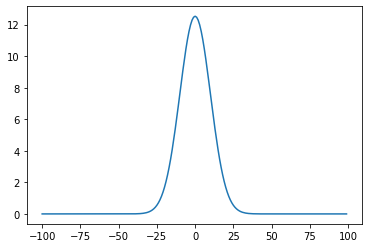

In [6]:
#sigma=phase, amp=mu
def gaussian(amp, phase, i):
    return (1/2*np.pi*amp**2)**(0.5)*(np.exp(-(i-phase)**2/2*amp**2))

x, y = [i for i in range(-100, 100)], []
for i in x:
    y.append(gaussian(10, 0, i/100))
plt.plot(x, y)

In [7]:
function = function_sinus
epsilon = 0
#generating data
class FunctionTask():
    def __init__(self,amp,phase,min_x,max_x):
        self.phase=phase
        self.max_x=max_x
        self.min_x=min_x
        self.amp=amp  #Amplitude
    
    def sample_data(self,size=1):
        x=np.random.uniform(self.max_x,self.min_x,size)
        y=self.true_function(x) + noise(epsilon)
        x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
        return x,y
  
    def true_function(self,x):
        y = function(self.amp, self.phase, x)
        return y

In [8]:
class FunctionDistribution():
  def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
    self.min_amp=min_amp
    self.max_phase=max_phase
    self.min_phase=min_phase
    self.max_amp=max_amp
    self.min_x=min_x  #Pas de changement par rapport à précédemment
    self.max_x=max_x  #Pas de changement par rapport à précédemment
    
  def sample_task(self):
    amp = np.random.uniform(self.min_amp, self.max_amp)
    phase = np.random.uniform(self.min_phase, self.max_phase)
    return FunctionTask(amp, phase, self.min_x, self.max_x)

# MAML

In [9]:
#generating sinusoidal data
class SineTask():
  def __init__(self,amp,phase,min_x,max_x):
    self.phase=phase
    self.max_x=max_x
    self.min_x=min_x
    self.amp=amp
    
  def sample_data(self,size=1):
    x=np.random.uniform(self.max_x,self.min_x,size)
    y=self.true_sine(x)
    x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
    y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
    return x,y
  
  def true_sine(self,x):
    y=self.amp*np.sin(self.phase+x)
    return y

In [10]:
class SineDistribution():
  def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
    self.min_amp=min_amp
    self.max_phase=max_phase
    self.min_phase=min_phase
    self.max_amp=max_amp
    self.min_x=min_x
    self.max_x=max_x
    
  def sample_task(self):
    amp = np.random.uniform(self.min_amp, self.max_amp)
    phase = np.random.uniform(self.min_phase, self.max_phase)
    return SineTask(amp, phase, self.min_x, self.max_x)

In [11]:
#defining our sine-net
class SineNet(nn.Module):
  def __init__(self):
    super(SineNet,self).__init__()
    self.net=nn.Sequential(OrderedDict([
            ('l1',nn.Linear(1,40)),
            ('relu1',nn.ReLU()),
            ('l2',nn.Linear(40,40)),
            ('relu2',nn.ReLU()),
            ('l3',nn.Linear(40,1))
        ]))
      
  # I implemented argforward() so that I could use a set of custom weights for evaluation. 
  # This is important for the "inner loop" in MAML where you temporarily update the weights
  # of the network for a task to calculate the meta-loss and then reset them for the next meta-task.
  def argforward(self,x,weights): 
    x=F.linear(x,weights[0],weights[1])
    x=F.relu(x)
    x=F.linear(x,weights[2],weights[3])           
    x=F.relu(x)
    x=F.linear(x,weights[4],weights[5])
    return x

In [12]:
class SineMAML():
    def __init__(self,net,alpha,beta,tasks,k,m,N,num_metatasks):
        self.net=net
        self.weights=list(net.parameters())
        self.alpha=alpha
        self.beta=beta
        self.tasks=tasks
        self.k=k 
        self.m = m
        self.N = N
        self.num_tasks_meta=num_metatasks
        self.criterion=nn.GaussianNLLLoss() #nn.MSELoss() #Important
        self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
        self.meta_losses=[]
        self.plot_every =100
        self.print_every = 100
        self.num_metatasks=num_metatasks
  
    def ML_point(self, task):
        temp_weights=[w.clone() for w in self.weights]  #This is phi
        x,y=task.sample_data(size=self.N) #sampling D
        x=x.to(device)
        y=y.to(device)
        for i in range(10):
            output=self.net.argforward(x,temp_weights) #We get f(x)
            loss=self.criterion(output, y, torch.ones_like(y))  #nn.GaussianNLLLoss(y, output)    
            grads=torch.autograd.grad(loss,temp_weights)  #allow_unused=True
            temp_weights = [w-self.alpha*g for w,g in zip(temp_weights,grads)]
        x_new, y_new = task.sample_data(size=self.m)
        x_new.to(device)
        y_new.to(device)
        output = self.net.argforward(x_new,temp_weights)
        metaloss = self.criterion(output, y_new, torch.ones_like(output))  #  -np.log(norm.pdf(y_new, loc=output))
        return metaloss


    def outer_loop(self,num_epochs):
        total_loss=0
        for epoch in range(1,num_epochs+1):
            metaloss_sum=0
            for i in range(self.num_metatasks):
                task=self.tasks.sample_task()
                metaloss=self.ML_point(task)
                metaloss_sum+=metaloss
            metagrads=torch.autograd.grad(metaloss_sum,self.weights) #c'est theta
            #important step
            for w,g in zip(self.weights,metagrads):
                w.grad=g
            ###############
            self.meta_optimiser.step()
            total_loss+=metaloss_sum.item()/self.num_metatasks
            if epoch % self.print_every == 0:
                print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
            if epoch%self.plot_every==0:
                self.meta_losses.append(total_loss/self.plot_every)
                total_loss = 0

In [17]:
min_amp,max_amp,min_phase,max_phase,min_x,max_x = -1, 1, 0, np.pi/3, -3, 3 #Classic ones
#min_amp,max_amp,min_phase,max_phase,min_x,max_x = -1, 1, 0, np.pi/3, -3, 3 #It sucks

sine_tasks=SineDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
#NPs like: -1, 1, 0, np.pi/3, -3, 3
#Classic: 0.1, 5, 0, np.pi, -5, 5
net=SineNet()
net=net.to(device)
maml=SineMAML(net,alpha=0.01,beta=0.001,tasks=sine_tasks,k=10,m=3,N=5, num_metatasks=10)

/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


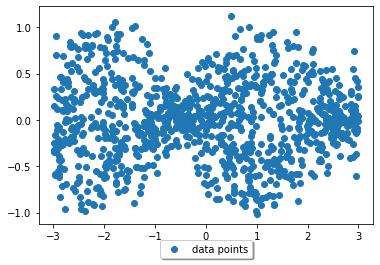

In [43]:
#min_amp,max_amp,min_phase,max_phase,min_x,max_x = 0.1, 5, 0, np.pi, -5, 5
function_dist = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
X, Y = [], []
temp_x, temp_y = 0, 0

for i in range(1000):
    temp_x, temp_y = function_dist.sample_task().sample_data()
    X.append(temp_x)
    Y.append(temp_y)
plt.scatter(X, Y, label="data points")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

In [19]:
start = datetime.datetime.now()
maml.outer_loop(num_epochs=15000)
end = datetime.datetime.now()
print((end-start).total_seconds())

100/15000. loss: 0.0614041579067707
200/15000. loss: 0.04712647534161804
300/15000. loss: 0.04088803201913833
400/15000. loss: 0.03405220060050487
500/15000. loss: 0.033136475302279
600/15000. loss: 0.030845500655472282
700/15000. loss: 0.03033022540807725
800/15000. loss: 0.026368180993944387
900/15000. loss: 0.024428614705801002
1000/15000. loss: 0.024147151954472066
1100/15000. loss: 0.02207392642274499
1200/15000. loss: 0.02279935041442514
1300/15000. loss: 0.020041567303240308
1400/15000. loss: 0.017583823403343555
1500/15000. loss: 0.01650823070853948
1600/15000. loss: 0.01586920361965895
1700/15000. loss: 0.018490454282611615
1800/15000. loss: 0.01855946786329151
1900/15000. loss: 0.01810571404360235
2000/15000. loss: 0.015888141248375173
2100/15000. loss: 0.01683521816134453
2200/15000. loss: 0.016563461445271974
2300/15000. loss: 0.016410705974325535
2400/15000. loss: 0.015487089114263655
2500/15000. loss: 0.016502359349280585
2600/15000. loss: 0.016091807007789616
2700/15000.

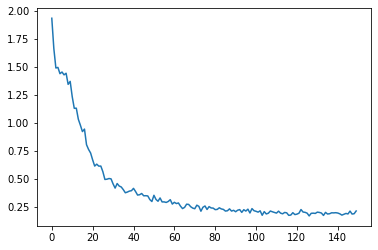

In [16]:
loss = []
for i in range(len(maml.meta_losses)):
    if maml.meta_losses[i]<100:
        loss.append(maml.meta_losses[i])
plt.plot(loss)

<Figure size 720x360 with 0 Axes>

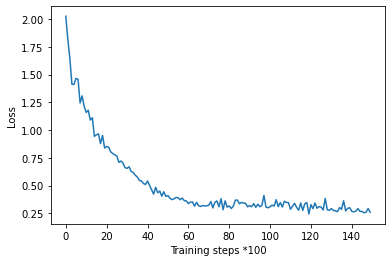

In [142]:
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.set_xlabel("Training steps *100")
ax.set_ylabel("Loss")
plt.plot(maml.meta_losses)
plt.show()

In [23]:
def test(og_net,x,y,lr,optim=torch.optim.SGD):
  axis=np.linspace(-5,5,1000)
  axis=torch.tensor(axis,dtype=torch.float)
  axis=axis.to(device)
  dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
  dummy_net=dummy_net.to(device)
  dummy_net.load_state_dict(og_net.state_dict())
  loss_fn=nn.GaussianNLLLoss()
  opt=optim(dummy_net.parameters(),lr=lr)
  num_shots=10
  k=x.shape[0]
  losses=[]
  outputs={}
  for i in range(num_shots):
    out=dummy_net(x)
    loss=loss_fn(out,y, torch.ones_like(y))
    losses.append(loss.item())
    dummy_net.zero_grad()
    loss.backward()
    opt.step()
  outputs['minitrained']= dummy_net(axis.view(-1, 1)).detach().cpu().clone().numpy()
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
  print(losses)
  return outputs,axis

# Plotting the RMSE as a function of the training steps

In [309]:
min_amp,max_amp,min_phase,max_phase,min_x,max_x = 0.1, 5, 0, np.pi, -5, 5 #Classic ones
#min_amp,max_amp,min_phase,max_phase,min_x,max_x = -1, 1, 0, np.pi/3, -3, 3 #It sucks

sine_tasks=SineDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
#NPs like: -1, 1, 0, np.pi/3, -3, 3
#Classic: 0.1, 5, 0, np.pi, -5, 5
net=SineNet()
net=net.to(device)
maml=SineMAML(net,alpha=0.01,beta=0.001,tasks=sine_tasks,k=10,m=3,N=5, num_metatasks=10)

rmse_evolution = []
for train_step in range(150):
    maml.outer_loop(num_epochs=100)

    K=10
    num_iterations = 50
    function_tasks = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
    global_error = 0

    for i in range(num_iterations):
        og_net=maml.net.net
        optim=torch.optim.SGD
        lr=0.01
        
        task=function_tasks.sample_task()
        x,y=task.sample_data(K)
        x=x.to(device)
        y=y.to(device)

        outputs,axis=test(og_net,x,y,lr,optim)
  
        error = 0
        L = []
        for i in range(len(x.numpy())):
            L.append(int((5+x.numpy()[i][0])*100))
        pred = []
        for i in range(len(x.numpy())):
            pred.append(outputs['minitrained'][L[i]][0])
        y_ = []
        for i in range(len(y.numpy())):
            y_.append(y.numpy()[i][0])
        global_error+=(np.linalg.norm(np.array(y_)-np.array(pred)))
    global_error = global_error/num_iterations
    rmse_evolution.append(global_error)

100/100. loss: 1.8947061676979056
[2.59879732131958, 2.5206973552703857, 2.4532439708709717, 2.3929316997528076, 2.3378779888153076, 2.2877187728881836, 2.2407283782958984, 2.1950175762176514, 2.1531567573547363, 2.1144134998321533]
[5.201590538024902, 5.123028755187988, 5.044623374938965, 4.966526508331299, 4.88900089263916, 4.812549114227295, 4.737552642822266, 4.664552211761475, 4.594104290008545, 4.526754856109619]
[1.3909893035888672, 1.375001311302185, 1.3588063716888428, 1.343078851699829, 1.3270161151885986, 1.310998558998108, 1.2946100234985352, 1.2778408527374268, 1.2604188919067383, 1.2419570684432983]
[2.8804633617401123, 2.8459689617156982, 2.8150010108947754, 2.786724090576172, 2.7605228424072266, 2.7361974716186523, 2.7136471271514893, 2.6921610832214355, 2.671914577484131, 2.6533026695251465]
[0.23866748809814453, 0.22308054566383362, 0.20957604050636292, 0.1977849304676056, 0.1874176412820816, 0.1782716065645218, 0.1701500117778778, 0.16287997364997864, 0.1563401818275

<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


[5.9640092849731445, 5.924289703369141, 5.880160808563232, 5.829743385314941, 5.773412704467773, 5.715240478515625, 5.652281761169434, 5.589627742767334, 5.531654357910156, 5.485872268676758]
[2.6094536781311035, 2.587855577468872, 2.5667576789855957, 2.546999931335449, 2.5286660194396973, 2.5110392570495605, 2.494143009185791, 2.4780077934265137, 2.4624686241149902, 2.447479724884033]
[7.3576250076293945, 7.164141654968262, 7.003127098083496, 6.869378089904785, 6.753814697265625, 6.645942687988281, 6.536945343017578, 6.429270267486572, 6.3340840339660645, 6.241177558898926]
[1.6674420833587646, 1.6166725158691406, 1.5746194124221802, 1.5391250848770142, 1.5084413290023804, 1.4815411567687988, 1.4586522579193115, 1.439073085784912, 1.420922040939331, 1.4043279886245728]
[0.5544880628585815, 0.5246270298957825, 0.4985586106777191, 0.4756174683570862, 0.4550479054450989, 0.43670564889907837, 0.41984453797340393, 0.4046344757080078, 0.39113467931747437, 0.3788711428642273]
[0.218859627842

[2.864394187927246, 2.797553777694702, 2.7331628799438477, 2.671184778213501, 2.6117262840270996, 2.557888984680176, 2.5083069801330566, 2.462157726287842, 2.419677257537842, 2.380101203918457]
[2.975010871887207, 2.811662197113037, 2.6771063804626465, 2.5616767406463623, 2.463181495666504, 2.377640962600708, 2.3019418716430664, 2.231351137161255, 2.1635079383850098, 2.1014904975891113]
[0.21614041924476624, 0.20828919112682343, 0.2010553628206253, 0.19438138604164124, 0.18828606605529785, 0.18258753418922424, 0.17723937332630157, 0.17220064997673035, 0.16743576526641846, 0.1629137098789215]
[6.287966251373291, 6.100600719451904, 5.982741355895996, 5.893509864807129, 5.814417362213135, 5.7501702308654785, 5.692508220672607, 5.639748573303223, 5.590971946716309, 5.543871879577637]
[0.833934485912323, 0.7891321778297424, 0.7455774545669556, 0.7046575546264648, 0.6658719778060913, 0.6285792589187622, 0.5933374762535095, 0.5611499547958374, 0.5298632383346558, 0.499381959438324]
[1.3628747

[0.12869039177894592, 0.1206279844045639, 0.11329738795757294, 0.10661421716213226, 0.10050582885742188, 0.09490946680307388, 0.08977063000202179, 0.08504187315702438, 0.08068162202835083, 0.07665348798036575]
[0.40187758207321167, 0.3755888044834137, 0.3521544337272644, 0.3311362862586975, 0.31218329071998596, 0.29501038789749146, 0.2793838083744049, 0.2651098370552063, 0.25202634930610657, 0.2399967908859253]
[0.3517759442329407, 0.3410833179950714, 0.33083707094192505, 0.3213892877101898, 0.3124988079071045, 0.30394142866134644, 0.29568004608154297, 0.2877761721611023, 0.280213862657547, 0.2729478180408478]
[0.3376149535179138, 0.32908695936203003, 0.32229799032211304, 0.3165362477302551, 0.31173545122146606, 0.30725759267807007, 0.30305805802345276, 0.2991151511669159, 0.29548579454421997, 0.29203587770462036]
[0.17583070695400238, 0.16763953864574432, 0.16027191281318665, 0.15354053676128387, 0.147381991147995, 0.14174479246139526, 0.1365709900856018, 0.13180756568908691, 0.127406

[1.3441035747528076, 1.2690777778625488, 1.192662000656128, 1.1119483709335327, 1.0274420976638794, 0.9391827583312988, 0.8482006192207336, 0.7563695907592773, 0.6659649610519409, 0.5794827938079834]
[2.332601547241211, 2.25219988822937, 2.1798300743103027, 2.112435817718506, 2.0499496459960938, 1.9908640384674072, 1.9346487522125244, 1.8817214965820312, 1.8325574398040771, 1.7911980152130127]
[2.321638584136963, 2.2280073165893555, 2.1368603706359863, 2.0438575744628906, 1.9512693881988525, 1.8587486743927002, 1.7686092853546143, 1.6835377216339111, 1.603386640548706, 1.5240775346755981]
[0.39249327778816223, 0.38902533054351807, 0.3861958682537079, 0.383514940738678, 0.38116195797920227, 0.37892812490463257, 0.37680408358573914, 0.3747793734073639, 0.37283217906951904, 0.37097200751304626]
[1.3372907638549805, 1.2826695442199707, 1.2348449230194092, 1.1902341842651367, 1.15009343624115, 1.1162762641906738, 1.0842230319976807, 1.053769826889038, 1.0248726606369019, 0.9976195096969604]

[1.751725196838379, 1.6551662683486938, 1.5697944164276123, 1.4903981685638428, 1.4156768321990967, 1.3463518619537354, 1.282233476638794, 1.221874713897705, 1.1656625270843506, 1.1146752834320068]
[0.44396573305130005, 0.4062860906124115, 0.3745146095752716, 0.347507506608963, 0.32486170530319214, 0.30578330159187317, 0.2895093560218811, 0.27669158577919006, 0.26534414291381836, 0.2556076645851135]
[2.759570598602295, 2.556901454925537, 2.3803508281707764, 2.203279972076416, 2.022442102432251, 1.8417928218841553, 1.6654468774795532, 1.4962929487228394, 1.3380966186523438, 1.1934317350387573]
[2.3089003562927246, 2.2156364917755127, 2.1267504692077637, 2.0423896312713623, 1.9647114276885986, 1.8973770141601562, 1.8352220058441162, 1.783311128616333, 1.7359275817871094, 1.6891298294067383]
[0.11003758013248444, 0.10379491001367569, 0.09804092347621918, 0.09272478520870209, 0.08780170977115631, 0.08323295414447784, 0.07898645102977753, 0.07503277063369751, 0.07134599983692169, 0.06790319

[0.4665943682193756, 0.4301857054233551, 0.396934449672699, 0.3665110468864441, 0.3385907709598541, 0.3129439949989319, 0.2893689274787903, 0.26769715547561646, 0.24779284000396729, 0.22950604557991028]
[1.770363211631775, 1.6784158945083618, 1.591881513595581, 1.5100245475769043, 1.4381089210510254, 1.3781987428665161, 1.3205012083053589, 1.2649505138397217, 1.2127275466918945, 1.1630375385284424]
[3.3063251972198486, 3.1159424781799316, 2.9323737621307373, 2.758913516998291, 2.5966696739196777, 2.446040630340576, 2.3017055988311768, 2.1562061309814453, 2.019885540008545, 1.8849575519561768]
[1.218248724937439, 1.052667260169983, 0.9134068489074707, 0.8046212196350098, 0.7150381207466125, 0.6429365873336792, 0.5871789455413818, 0.5437881350517273, 0.5102559924125671, 0.4840640425682068]
[0.24409958720207214, 0.21786010265350342, 0.19723157584667206, 0.18065062165260315, 0.16708707809448242, 0.15583379566669464, 0.1463882029056549, 0.1383819729089737, 0.13153821229934692, 0.12564393877

[1.4883720874786377, 1.3876008987426758, 1.2941222190856934, 1.2074248790740967, 1.1291755437850952, 1.0662200450897217, 1.007745385169983, 0.954651951789856, 0.9058257937431335, 0.8614211082458496]
[1.1558587551116943, 1.1176388263702393, 1.0817290544509888, 1.0478359460830688, 1.01334547996521, 0.9760007858276367, 0.9380232691764832, 0.9023466110229492, 0.8682311773300171, 0.836543083190918]
[0.40562552213668823, 0.33179694414138794, 0.27786970138549805, 0.23716160655021667, 0.20551541447639465, 0.18100881576538086, 0.161891371011734, 0.1467989683151245, 0.1348157525062561, 0.125247985124588]
[0.09950732439756393, 0.0937739908695221, 0.08859561383724213, 0.08390523493289948, 0.07964574545621872, 0.07576823979616165, 0.07223047316074371, 0.0689958930015564, 0.06603264808654785, 0.06331281363964081]
[0.689399778842926, 0.6457217335700989, 0.6047385931015015, 0.5683450698852539, 0.5337141752243042, 0.49994397163391113, 0.4674685597419739, 0.43630677461624146, 0.40610653162002563, 0.3773

[4.1860127449035645, 3.413822889328003, 2.9090142250061035, 2.5450050830841064, 2.274543285369873, 2.0698182582855225, 1.9297277927398682, 1.8292957544326782, 1.7598766088485718, 1.7097947597503662]
[6.047867774963379, 5.670761585235596, 5.351803779602051, 5.1217780113220215, 4.956869125366211, 4.808627128601074, 4.669679164886475, 4.538445472717285, 4.413586139678955, 4.2923688888549805]
[1.483939528465271, 1.3912174701690674, 1.3022751808166504, 1.218275785446167, 1.1416308879852295, 1.0671616792678833, 0.9954625964164734, 0.92596036195755, 0.8605025410652161, 0.7973493337631226]
[5.936265468597412, 5.560192108154297, 5.23600959777832, 4.938347816467285, 4.676275730133057, 4.435399055480957, 4.219782829284668, 4.026591777801514, 3.870520830154419, 3.7418041229248047]
[0.3875109851360321, 0.35358095169067383, 0.32491543889045715, 0.3003844618797302, 0.2792279124259949, 0.2608504891395569, 0.24478039145469666, 0.23064017295837402, 0.2180812805891037, 0.20682589709758759]
[3.17724347114

[1.4718286991119385, 1.2925570011138916, 1.1523542404174805, 1.0400269031524658, 0.9495784044265747, 0.8808554410934448, 0.8270753026008606, 0.7850453853607178, 0.7476072311401367, 0.7160828709602356]
[1.506201982498169, 1.3953475952148438, 1.320305585861206, 1.2594630718231201, 1.2174296379089355, 1.1799218654632568, 1.1444886922836304, 1.1104804277420044, 1.077575922012329, 1.0434082746505737]
[1.6928141117095947, 1.6401634216308594, 1.5910565853118896, 1.544979214668274, 1.4992012977600098, 1.4457706212997437, 1.4030861854553223, 1.3556067943572998, 1.3106948137283325, 1.2681658267974854]
[0.9159744381904602, 0.8146764636039734, 0.7396456003189087, 0.6996721029281616, 0.6650186777114868, 0.6319519281387329, 0.6067338585853577, 0.5831101536750793, 0.557090699672699, 0.5323222279548645]
[0.4585484564304352, 0.4110555648803711, 0.37322863936424255, 0.34280580282211304, 0.31811070442199707, 0.29787659645080566, 0.2811335623264313, 0.26713213324546814, 0.25529032945632935, 0.245155259966

[4.625787734985352, 3.6859779357910156, 3.18772554397583, 2.8759357929229736, 2.6539366245269775, 2.4917733669281006, 2.3762292861938477, 2.2900774478912354, 2.22556734085083, 2.1748974323272705]
[2.588369607925415, 2.4538733959198, 2.3223888874053955, 2.194636583328247, 2.0728912353515625, 1.9555269479751587, 1.8477022647857666, 1.7513673305511475, 1.660265326499939, 1.585391640663147]
[4.524716854095459, 4.143876075744629, 3.893454074859619, 3.6946868896484375, 3.5227084159851074, 3.388523578643799, 3.2904586791992188, 3.197474956512451, 3.1135094165802, 3.030709981918335]
[0.13074347376823425, 0.12082759290933609, 0.11214915663003922, 0.1045258641242981, 0.09780606627464294, 0.0918603464961052, 0.08658421039581299, 0.08186642080545425, 0.07762985676527023, 0.07381229847669601]
[1.4433863162994385, 1.3385071754455566, 1.2470046281814575, 1.1764522790908813, 1.1239540576934814, 1.0776853561401367, 1.0340588092803955, 0.9911511540412903, 0.9495522379875183, 0.90989750623703]
[1.7071968

[0.3308001160621643, 0.29149311780929565, 0.2620638608932495, 0.23944595456123352, 0.2216261923313141, 0.20723846554756165, 0.19540253281593323, 0.18538299202919006, 0.17671933770179749, 0.1690850555896759]
[2.9873554706573486, 2.54338002204895, 2.1823854446411133, 1.890287160873413, 1.7054208517074585, 1.5555965900421143, 1.4345693588256836, 1.3328814506530762, 1.2516711950302124, 1.1958719491958618]
[0.37969398498535156, 0.33462658524513245, 0.29836851358413696, 0.2689670920372009, 0.24462154507637024, 0.22215470671653748, 0.20346376299858093, 0.1874750554561615, 0.17313294112682343, 0.16060467064380646]
[2.1648077964782715, 1.9109351634979248, 1.7193721532821655, 1.5524133443832397, 1.4021375179290771, 1.2684252262115479, 1.1577773094177246, 1.060522437095642, 0.9702132940292358, 0.887101948261261]
[1.765000343322754, 1.5317199230194092, 1.3434765338897705, 1.1893728971481323, 1.057238221168518, 0.9453547596931458, 0.8462604284286499, 0.7633622288703918, 0.6912657618522644, 0.629805

[2.0367166996002197, 1.9061803817749023, 1.8334709405899048, 1.7748981714248657, 1.7239433526992798, 1.6727683544158936, 1.6158260107040405, 1.557072639465332, 1.4970334768295288, 1.4371836185455322]
[1.349761724472046, 1.1512993574142456, 0.9946945905685425, 0.8952175378799438, 0.8137903213500977, 0.7420210242271423, 0.6791711449623108, 0.6229801774024963, 0.5690193176269531, 0.5208690762519836]
[1.8714004755020142, 1.708470106124878, 1.566725492477417, 1.4403784275054932, 1.3122574090957642, 1.1835484504699707, 1.0702821016311646, 0.9763676524162292, 0.9096601605415344, 0.8511813282966614]
[0.6081181168556213, 0.5609961152076721, 0.5196603536605835, 0.4769206941127777, 0.44177722930908203, 0.41186079382896423, 0.3851932883262634, 0.36033207178115845, 0.33963119983673096, 0.322002112865448]
[0.6423579454421997, 0.4532846510410309, 0.352565735578537, 0.30415233969688416, 0.2727922797203064, 0.25206422805786133, 0.23760811984539032, 0.22737273573875427, 0.2197457253932953, 0.21383567154

[0.2306414544582367, 0.1873030811548233, 0.16359831392765045, 0.14772292971611023, 0.13545389473438263, 0.1252238005399704, 0.11638832092285156, 0.10863109678030014, 0.10176149755716324, 0.09564477950334549]
[0.3087874948978424, 0.28103023767471313, 0.2571438252925873, 0.23645660281181335, 0.21823422610759735, 0.20205053687095642, 0.18782517313957214, 0.1752549260854721, 0.16408541798591614, 0.1541202962398529]
[3.2619502544403076, 2.9160869121551514, 2.6152329444885254, 2.3990731239318848, 2.277667999267578, 2.1769251823425293, 2.0895400047302246, 2.005840539932251, 1.9271905422210693, 1.8570235967636108]
[0.46441736817359924, 0.40950480103492737, 0.3591420352458954, 0.3240869343280792, 0.2983354330062866, 0.2784363925457001, 0.26241689920425415, 0.24910295009613037, 0.23779895901679993, 0.2280261218547821]
[1.768800139427185, 1.4750845432281494, 1.2494596242904663, 1.066925287246704, 0.9227401614189148, 0.8018218874931335, 0.6986457705497742, 0.6141536831855774, 0.5471987724304199, 0

[0.8317571878433228, 0.6535818576812744, 0.5955836176872253, 0.5508670806884766, 0.5141657590866089, 0.4838898777961731, 0.45530861616134644, 0.43300724029541016, 0.4121168255805969, 0.39349454641342163]
[1.2495957612991333, 1.0767333507537842, 0.946341335773468, 0.8404576182365417, 0.7546164393424988, 0.6832872629165649, 0.6309131383895874, 0.5916101932525635, 0.5631200075149536, 0.538493275642395]
[0.41568630933761597, 0.3330319821834564, 0.2915835976600647, 0.2661136984825134, 0.24802403151988983, 0.23399636149406433, 0.22253696620464325, 0.21284809708595276, 0.20445701479911804, 0.19705453515052795]
[3.941289186477661, 2.641000509262085, 2.3522324562072754, 2.1989099979400635, 2.073960542678833, 1.9666821956634521, 1.8729159832000732, 1.7896127700805664, 1.7148576974868774, 1.6503044366836548]
[4.429308891296387, 2.756760835647583, 2.2610926628112793, 2.0643410682678223, 1.964583396911621, 1.879675269126892, 1.8070358037948608, 1.7389647960662842, 1.6792691946029663, 1.624309897422

[0.8783665895462036, 0.6561105251312256, 0.5599984526634216, 0.5114234685897827, 0.4785354733467102, 0.4495711922645569, 0.4239598214626312, 0.4005811810493469, 0.37897390127182007, 0.3611432909965515]
[0.8208791017532349, 0.7268524765968323, 0.6497107744216919, 0.5846768021583557, 0.5042585730552673, 0.44440898299217224, 0.3989749252796173, 0.36376211047172546, 0.33587488532066345, 0.313297301530838]
[2.7494056224823, 2.38637375831604, 2.229785442352295, 2.1086606979370117, 2.0008575916290283, 1.9017016887664795, 1.8088445663452148, 1.7218072414398193, 1.6407663822174072, 1.5639138221740723]
[0.9501348733901978, 0.6212199926376343, 0.45301589369773865, 0.3604946434497833, 0.3073078989982605, 0.27525752782821655, 0.2545735538005829, 0.23976631462574005, 0.2278924286365509, 0.21778413653373718]
[3.4438812732696533, 2.8391854763031006, 2.3875837326049805, 2.0454928874969482, 1.7946679592132568, 1.6017062664031982, 1.4495093822479248, 1.3260693550109863, 1.2230734825134277, 1.135454535484

[0.5613606572151184, 0.5070043802261353, 0.46419015526771545, 0.4294656813144684, 0.40062546730041504, 0.3758591115474701, 0.33984455466270447, 0.3143313527107239, 0.2947733998298645, 0.27897945046424866]
[0.682654857635498, 0.5828816294670105, 0.5157488584518433, 0.46710413694381714, 0.42960673570632935, 0.39938420057296753, 0.3738137185573578, 0.35120195150375366, 0.3316653370857239, 0.31456807255744934]
[0.5669646263122559, 0.3452974557876587, 0.25048473477363586, 0.20142439007759094, 0.17125332355499268, 0.14921119809150696, 0.12864622473716736, 0.11261143535375595, 0.09988335520029068, 0.08967921882867813]
[0.25101548433303833, 0.17391668260097504, 0.14901524782180786, 0.13736483454704285, 0.12975916266441345, 0.12372412532567978, 0.1184668317437172, 0.11368323862552643, 0.10924109071493149, 0.10504277795553207]
[0.5316929817199707, 0.5020138025283813, 0.47662848234176636, 0.4541131556034088, 0.4337347447872162, 0.4150828421115875, 0.39783230423927307, 0.38167619705200195, 0.36664

[2.0269408226013184, 1.8274986743927002, 1.6389219760894775, 1.4649527072906494, 1.3131961822509766, 1.183316707611084, 1.0728713274002075, 0.9757683873176575, 0.888881504535675, 0.8105217814445496]
[1.4124993085861206, 0.5363842248916626, 0.4536837935447693, 0.41793909668922424, 0.38998034596443176, 0.3690604567527771, 0.3503778874874115, 0.3348623514175415, 0.32086697220802307, 0.3081539571285248]
[1.4207730293273926, 0.527152955532074, 0.4619115889072418, 0.4319845736026764, 0.40675416588783264, 0.38473865389823914, 0.3654969334602356, 0.34835392236709595, 0.33230844140052795, 0.3169206976890564]
[0.9774277806282043, 0.7735891342163086, 0.6375072598457336, 0.5431151390075684, 0.4748598635196686, 0.42365676164627075, 0.38412556052207947, 0.3528546392917633, 0.3276050388813019, 0.3068351149559021]
[0.9669413566589355, 0.6977155208587646, 0.5590006709098816, 0.49133381247520447, 0.4487210214138031, 0.41444048285484314, 0.38564035296440125, 0.36078184843063354, 0.3390745520591736, 0.319

[2.816352367401123, 1.911045789718628, 1.6281111240386963, 1.4866708517074585, 1.37591552734375, 1.2884504795074463, 1.217410683631897, 1.1563668251037598, 1.1007871627807617, 1.0494006872177124]
[1.6107556819915771, 1.3679401874542236, 1.2081151008605957, 1.1025019884109497, 1.0309650897979736, 0.9770593643188477, 0.9200264811515808, 0.8573468923568726, 0.7979686856269836, 0.7446573972702026]
[4.3451948165893555, 3.648402452468872, 3.1993699073791504, 2.8510565757751465, 2.634239673614502, 2.4360921382904053, 2.250182628631592, 2.0813350677490234, 1.9281084537506104, 1.796168565750122]
[0.2103838175535202, 0.19499166309833527, 0.1814378798007965, 0.16936613619327545, 0.15851199626922607, 0.1486762911081314, 0.13971424102783203, 0.13151021301746368, 0.1239713802933693, 0.11702169477939606]
[0.8496865034103394, 0.7585046887397766, 0.6803705096244812, 0.6050059199333191, 0.537964940071106, 0.4775736331939697, 0.4220660626888275, 0.3727504312992096, 0.328964501619339, 0.29152676463127136]

[4.795372009277344, 3.2621512413024902, 2.518000841140747, 1.9097621440887451, 1.4729483127593994, 1.2029638290405273, 1.0754594802856445, 0.9663698077201843, 0.87554532289505, 0.8011844754219055]
[2.3680107593536377, 1.3407554626464844, 1.118033766746521, 0.9292726516723633, 0.7783123254776001, 0.6616791486740112, 0.5713322162628174, 0.4982147216796875, 0.44124943017959595, 0.3957131505012512]
[0.09176891297101974, 0.06646038591861725, 0.04861588031053543, 0.03494424372911453, 0.024908151477575302, 0.017575731500983238, 0.01272283773869276, 0.009512251242995262, 0.007398729678243399, 0.005975143983960152]
[1.6194028854370117, 1.2915477752685547, 1.1165956258773804, 0.9780567288398743, 0.859390139579773, 0.7546404004096985, 0.6632496118545532, 0.5835164785385132, 0.5167175531387329, 0.46258607506752014]
[0.006980934180319309, 0.005563904065638781, 0.004575986880809069, 0.003875186201184988, 0.0033686619717627764, 0.002995081013068557, 0.0027135617565363646, 0.002496554981917143, 0.0023

[0.3393106758594513, 0.14225241541862488, 0.07541592419147491, 0.06625808775424957, 0.05910306051373482, 0.05337340757250786, 0.04870503395795822, 0.04484419897198677, 0.04160388559103012, 0.03884509578347206]
[6.4637322425842285, 3.108717441558838, 2.8117032051086426, 2.5027828216552734, 2.2048404216766357, 1.9490114450454712, 1.7520831823349, 1.6027055978775024, 1.4820747375488281, 1.389129877090454]
[0.40401941537857056, 0.30072346329689026, 0.2595694959163666, 0.2311985045671463, 0.20918166637420654, 0.19151026010513306, 0.17695513367652893, 0.164685919880867, 0.15412203967571259, 0.1448592096567154]
[0.9317260980606079, 0.8139484524726868, 0.7403266429901123, 0.6811898946762085, 0.629252552986145, 0.5865634083747864, 0.5469497442245483, 0.5127286911010742, 0.4811880588531494, 0.45136433839797974]
[0.11057758331298828, 0.04620770364999771, 0.03195164352655411, 0.025600705295801163, 0.021618491038680077, 0.01873192936182022, 0.016466552391648293, 0.014622976072132587, 0.013099847361

[0.7915844917297363, 0.43621397018432617, 0.29719650745391846, 0.22890491783618927, 0.18562304973602295, 0.15387701988220215, 0.12893743813037872, 0.1106000542640686, 0.09712979197502136, 0.08693446964025497]
[0.1519211232662201, 0.1089351549744606, 0.09853136539459229, 0.09302951395511627, 0.08941787481307983, 0.08678103983402252, 0.08468011766672134, 0.08288728445768356, 0.08128214627504349, 0.07979990541934967]
[3.705906629562378, 1.7131683826446533, 1.4126496315002441, 1.2102283239364624, 1.0430983304977417, 0.9049617648124695, 0.8053475618362427, 0.7272452116012573, 0.6639629602432251, 0.6113176941871643]
[1.0954734086990356, 0.7382940649986267, 0.5857720971107483, 0.49061593413352966, 0.41632431745529175, 0.3542521893978119, 0.30584773421287537, 0.2669496536254883, 0.23309502005577087, 0.20602969825267792]
[2.952070951461792, 1.2590233087539673, 1.1376911401748657, 1.0390195846557617, 0.9539545178413391, 0.8825834393501282, 0.8198949098587036, 0.7640774846076965, 0.71550381183624

[0.3932313323020935, 0.24431438744068146, 0.18226270377635956, 0.14582911133766174, 0.1205851212143898, 0.10209838300943375, 0.08859607577323914, 0.07818233966827393, 0.07009834796190262, 0.06388117372989655]
[2.7543320655822754, 2.515575408935547, 2.3040056228637695, 2.1047680377960205, 1.9174445867538452, 1.7489343881607056, 1.5986043214797974, 1.4612985849380493, 1.334567666053772, 1.2185784578323364]
[1.195587158203125, 0.694034993648529, 0.5334009528160095, 0.4641374945640564, 0.4229028820991516, 0.39193183183670044, 0.3658187687397003, 0.3429829478263855, 0.3227437436580658, 0.3047613799571991]
[0.23481492698192596, 0.1731192022562027, 0.13157939910888672, 0.1073882207274437, 0.09030692279338837, 0.07678931951522827, 0.06606927514076233, 0.057264648377895355, 0.04995279759168625, 0.04382183402776718]
[0.5555921792984009, 0.1999407559633255, 0.1636025309562683, 0.1492273062467575, 0.1390346735715866, 0.13023041188716888, 0.12225914001464844, 0.11432430893182755, 0.1064072400331497

[1.7034765481948853, 0.7883344292640686, 0.5584720373153687, 0.48418861627578735, 0.428699254989624, 0.38214364647865295, 0.34255343675613403, 0.308666855096817, 0.27950769662857056, 0.2543273866176605]
[2.7588095664978027, 2.1347599029541016, 1.751704454421997, 1.4778324365615845, 1.2849103212356567, 1.157181739807129, 1.0624847412109375, 0.9838589429855347, 0.9182500839233398, 0.8683016896247864]
[1.2631727457046509, 0.8368306159973145, 0.5915974378585815, 0.48444119095802307, 0.42707887291908264, 0.39039626717567444, 0.3632320463657379, 0.3390578031539917, 0.3165356516838074, 0.2934003472328186]
[0.9390942454338074, 0.709324300289154, 0.514785885810852, 0.43235039710998535, 0.38283899426460266, 0.3461968004703522, 0.31675365567207336, 0.29236888885498047, 0.2718910574913025, 0.2543664574623108]
[3.053849697113037, 0.9765397906303406, 0.8163775205612183, 0.7137701511383057, 0.6560550928115845, 0.6022301912307739, 0.5585411190986633, 0.518621027469635, 0.47837716341018677, 0.444923937

[0.9853242635726929, 0.8211814165115356, 0.7088100910186768, 0.6253279447555542, 0.561102032661438, 0.5098903179168701, 0.4680056571960449, 0.4308861196041107, 0.397705078125, 0.3671084940433502]
[5.285962104797363, 3.1096692085266113, 2.031787395477295, 1.546320915222168, 1.2813026905059814, 1.1265466213226318, 1.010432481765747, 0.9103849530220032, 0.8195453882217407, 0.7380198240280151]
[1.1398582458496094, 0.8285834193229675, 0.6155399084091187, 0.46723517775535583, 0.35698115825653076, 0.279874324798584, 0.2243899405002594, 0.17875473201274872, 0.14350831508636475, 0.11625365167856216]
[0.8984465599060059, 0.7200949788093567, 0.6526721119880676, 0.6028351187705994, 0.5596119165420532, 0.5209075212478638, 0.4856850504875183, 0.4530697464942932, 0.42668548226356506, 0.4017963409423828]
[0.5507000684738159, 0.43924975395202637, 0.35365548729896545, 0.2716083824634552, 0.21688595414161682, 0.18268108367919922, 0.15809491276741028, 0.139170840382576, 0.12401993572711945, 0.111535809934

[0.746407687664032, 0.5870901346206665, 0.5047669410705566, 0.43789562582969666, 0.3821113109588623, 0.3417683243751526, 0.30814796686172485, 0.2794036567211151, 0.2548305094242096, 0.23428981006145477]
[0.4590901732444763, 0.277322918176651, 0.24463891983032227, 0.22343549132347107, 0.20570945739746094, 0.1905049830675125, 0.1773281842470169, 0.16580693423748016, 0.15565018355846405, 0.1466284543275833]
[1.6954177618026733, 0.5635722279548645, 0.446478933095932, 0.36970728635787964, 0.30355674028396606, 0.25302767753601074, 0.2132306843996048, 0.1836514174938202, 0.15994161367416382, 0.13979534804821014]
[0.27374958992004395, 0.22144444286823273, 0.1903005987405777, 0.16317306458950043, 0.14222875237464905, 0.1247100979089737, 0.11032106727361679, 0.09754668176174164, 0.08536623418331146, 0.07358820736408234]
[1.375705599784851, 1.1761324405670166, 1.0102523565292358, 0.8721631765365601, 0.7530781030654907, 0.6496007442474365, 0.558449387550354, 0.4791725277900696, 0.41256245970726013

[2.069930076599121, 1.7155282497406006, 1.4201154708862305, 1.2021143436431885, 1.0215762853622437, 0.8892250061035156, 0.7711896896362305, 0.6879205703735352, 0.6090582609176636, 0.5217328667640686]
[0.7310576438903809, 0.3886551260948181, 0.2665041387081146, 0.19728699326515198, 0.1600928008556366, 0.13860389590263367, 0.12280676513910294, 0.10696115344762802, 0.09579664468765259, 0.08761848509311676]
[0.8361759185791016, 0.40828198194503784, 0.35432547330856323, 0.3128006160259247, 0.2792819142341614, 0.2518489956855774, 0.22897009551525116, 0.20986561477184296, 0.19366554915905, 0.1798037886619568]
[2.4338862895965576, 1.869854211807251, 1.5850586891174316, 1.3664462566375732, 1.2201621532440186, 1.0932257175445557, 1.0044105052947998, 0.931839108467102, 0.8698645830154419, 0.8195061683654785]
[0.8001697659492493, 0.2826767861843109, 0.2195780724287033, 0.18004825711250305, 0.15227611362934113, 0.13140961527824402, 0.11484880745410919, 0.10107733309268951, 0.08997626602649689, 0.08

[0.13449275493621826, 0.03355028107762337, 0.017829682677984238, 0.014143100008368492, 0.012561740353703499, 0.011437720619142056, 0.01049862988293171, 0.009683877229690552, 0.008970086462795734, 0.008342341519892216]
[2.1060214042663574, 0.8765198588371277, 0.6818944811820984, 0.6355125308036804, 0.5986775159835815, 0.559052586555481, 0.5255786180496216, 0.4965631067752838, 0.4700969159603119, 0.445762574672699]
[7.50148868560791, 5.411005973815918, 4.023849964141846, 2.8534998893737793, 2.1358437538146973, 1.6345760822296143, 1.2512550354003906, 0.9571503400802612, 0.7296816110610962, 0.5569395422935486]
[0.8975299596786499, 0.6059512495994568, 0.5129579305648804, 0.4482259750366211, 0.39736407995224, 0.3582451045513153, 0.3253399729728699, 0.2981117367744446, 0.2743086516857147, 0.25339430570602417]
[0.5099457502365112, 0.11928244680166245, 0.09338876605033875, 0.07514630258083344, 0.06188303977251053, 0.05201199650764465, 0.04455479979515076, 0.038822684437036514, 0.034330211579799

[0.4510877728462219, 0.22727534174919128, 0.19854429364204407, 0.1816190481185913, 0.16774778068065643, 0.1557353436946869, 0.14516080915927887, 0.1358950138092041, 0.1278315931558609, 0.12044420093297958]
[1.0368802547454834, 0.4646313786506653, 0.2772831916809082, 0.19633498787879944, 0.15066327154636383, 0.11897437274456024, 0.09614066779613495, 0.07932174205780029, 0.06621658056974411, 0.055859774351119995]
[0.6301931142807007, 0.42898836731910706, 0.36170080304145813, 0.32254618406295776, 0.2915702164173126, 0.2666209638118744, 0.2461937963962555, 0.22922250628471375, 0.21487148106098175, 0.202528715133667]
[0.5681043863296509, 0.472794771194458, 0.4015491008758545, 0.33755600452423096, 0.29099294543266296, 0.2548316717147827, 0.22580265998840332, 0.2021726667881012, 0.1820274293422699, 0.16442431509494781]
[3.9504172801971436, 0.9097112417221069, 0.8313910365104675, 0.7719560861587524, 0.6931213736534119, 0.5770087242126465, 0.4731917381286621, 0.3970063328742981, 0.3325297236442

[0.37586554884910583, 0.25690698623657227, 0.18366752564907074, 0.13626179099082947, 0.10399486124515533, 0.08096475899219513, 0.0638008862733841, 0.05075901001691818, 0.04081294313073158, 0.033173784613609314]
[1.7123823165893555, 0.8545999526977539, 0.6003578305244446, 0.49291354417800903, 0.4288484454154968, 0.37871986627578735, 0.3366764485836029, 0.3030986189842224, 0.27396222949028015, 0.2487441748380661]
[1.2503538131713867, 0.7552031874656677, 0.5279459357261658, 0.4047749936580658, 0.32580697536468506, 0.26754456758499146, 0.22094225883483887, 0.18392831087112427, 0.15511032938957214, 0.13174273073673248]
[0.5366262197494507, 0.3559616506099701, 0.2710343599319458, 0.2229950875043869, 0.19370180368423462, 0.17467686533927917, 0.1614285409450531, 0.15214180946350098, 0.14476871490478516, 0.13861504197120667]
[0.5521544218063354, 0.29500216245651245, 0.21407301723957062, 0.15988999605178833, 0.12210243940353394, 0.09480336308479309, 0.07492746412754059, 0.06014779210090637, 0.04

[0.5274366736412048, 0.4404488205909729, 0.37472066283226013, 0.3213523030281067, 0.27417412400245667, 0.2329249382019043, 0.19711489975452423, 0.16634365916252136, 0.140672504901886, 0.1205768957734108]
[3.3907318115234375, 1.8077110052108765, 1.211180567741394, 0.8477166295051575, 0.6049203276634216, 0.44038715958595276, 0.33060234785079956, 0.24864144623279572, 0.1905020773410797, 0.14965108036994934]
[2.3762128353118896, 1.0102241039276123, 0.8433022499084473, 0.7118571996688843, 0.5828036069869995, 0.48058438301086426, 0.3982212245464325, 0.33379000425338745, 0.2803921401500702, 0.2375817745923996]
[0.6583949327468872, 0.3455483317375183, 0.3046623468399048, 0.2746356725692749, 0.24903135001659393, 0.2268679440021515, 0.2074800729751587, 0.19040389358997345, 0.17526856064796448, 0.16191567480564117]
[0.44398313760757446, 0.24160146713256836, 0.1582992970943451, 0.12258076667785645, 0.10689254850149155, 0.09686120599508286, 0.08941584080457687, 0.08348269015550613, 0.07878322154283

[0.13141751289367676, 0.07366441190242767, 0.06198881193995476, 0.055441342294216156, 0.050341568887233734, 0.046097032725811005, 0.04242095351219177, 0.03916653245687485, 0.03626495972275734, 0.03417346253991127]
[0.18050646781921387, 0.10522638261318207, 0.07136471569538116, 0.053233034908771515, 0.040763430297374725, 0.03151915967464447, 0.024851979687809944, 0.019829152151942253, 0.015952857211232185, 0.012924742884933949]
[0.019737863913178444, 0.004647877532988787, 0.003631147788837552, 0.0029491670429706573, 0.0024828799068927765, 0.002155211754143238, 0.0019133919849991798, 0.0017462236573919654, 0.0016278859693557024, 0.0015416063833981752]
[1.1201834678649902, 0.5113387107849121, 0.3634338080883026, 0.28278568387031555, 0.22588889300823212, 0.18514077365398407, 0.152650848031044, 0.12855765223503113, 0.11065827310085297, 0.09735006839036942]
[3.2982585430145264, 0.924769401550293, 0.7640195488929749, 0.6425975561141968, 0.5491423010826111, 0.4765249788761139, 0.41962456703186

[2.5123848915100098, 1.9737164974212646, 1.6393531560897827, 1.393283724784851, 1.2031170129776, 1.0447933673858643, 0.9130120277404785, 0.8226454854011536, 0.8047341108322144, 0.7674123048782349]
[0.9437572360038757, 0.7983733415603638, 0.6912773251533508, 0.6102019548416138, 0.5448892116546631, 0.4895109534263611, 0.4409905970096588, 0.39872193336486816, 0.36123916506767273, 0.3281026780605316]
[0.3496289849281311, 0.16153062880039215, 0.11838048696517944, 0.10056179761886597, 0.09091443568468094, 0.08499158918857574, 0.08098973333835602, 0.07804960757493973, 0.0758504793047905, 0.07407111674547195]
[4.787679672241211, 1.4429512023925781, 0.866685688495636, 0.7036008238792419, 0.5987561941146851, 0.5125354528427124, 0.44351324439048767, 0.38749727606773376, 0.3451107144355774, 0.311754047870636]
[0.8963109850883484, 0.5045763850212097, 0.3555595576763153, 0.2657932639122009, 0.21105745434761047, 0.17638351023197174, 0.15386739373207092, 0.1386300027370453, 0.12789982557296753, 0.1199

[0.6526791453361511, 0.5262921452522278, 0.43050870299339294, 0.3574164807796478, 0.30038249492645264, 0.25524666905403137, 0.21975132822990417, 0.1910150647163391, 0.1670614778995514, 0.1473163515329361]
[0.6526780724525452, 0.5050447583198547, 0.4246358871459961, 0.3720204830169678, 0.33192411065101624, 0.29906755685806274, 0.2712242007255554, 0.24709680676460266, 0.226627916097641, 0.20894913375377655]
[0.4186369776725769, 0.3220222592353821, 0.269849956035614, 0.22587576508522034, 0.18906697630882263, 0.15847507119178772, 0.1344890594482422, 0.11487670987844467, 0.09869226813316345, 0.08507735282182693]
[0.596223771572113, 0.4469783902168274, 0.3551941514015198, 0.29091930389404297, 0.2411338984966278, 0.20207366347312927, 0.17110976576805115, 0.1462896764278412, 0.12616458535194397, 0.10978925228118896]
[1.238595724105835, 0.4578211307525635, 0.293634295463562, 0.2205198109149933, 0.17678484320640564, 0.145364448428154, 0.12188782542943954, 0.10399039834737778, 0.09008760750293732

[3.6249969005584717, 0.7603304982185364, 0.35082536935806274, 0.23229768872261047, 0.16926757991313934, 0.1308377981185913, 0.10542286932468414, 0.08501005917787552, 0.06907885521650314, 0.056711964309215546]
[0.6936723589897156, 0.5743376016616821, 0.4962635040283203, 0.431142657995224, 0.38651686906814575, 0.3513205647468567, 0.3260802626609802, 0.30662623047828674, 0.290895938873291, 0.27707579731941223]
[0.7639520764350891, 0.5410206317901611, 0.44819679856300354, 0.39314132928848267, 0.35491010546684265, 0.3251904249191284, 0.300781786441803, 0.27997303009033203, 0.26183366775512695, 0.2457970678806305]
[0.8857935667037964, 0.46443289518356323, 0.399017333984375, 0.360517680644989, 0.33481231331825256, 0.31537961959838867, 0.29881751537323, 0.2841430902481079, 0.2709163725376129, 0.25888973474502563]
[0.17528390884399414, 0.13288503885269165, 0.11112739890813828, 0.09672927111387253, 0.0860985592007637, 0.0772794559597969, 0.06970800459384918, 0.06309723109006882, 0.05727161839604

[0.36934617161750793, 0.11529149860143661, 0.07958810776472092, 0.06052277609705925, 0.04832032322883606, 0.039657749235630035, 0.03319302201271057, 0.028152942657470703, 0.024148140102624893, 0.020917300134897232]
[4.420604228973389, 1.3319036960601807, 0.70438152551651, 0.4889303147792816, 0.3564763069152832, 0.27294856309890747, 0.21483370661735535, 0.17042917013168335, 0.13831524550914764, 0.11337737739086151]
[0.4892832636833191, 0.24652759730815887, 0.2095143347978592, 0.18392306566238403, 0.1642276793718338, 0.14864245057106018, 0.1358426809310913, 0.12561047077178955, 0.11718841642141342, 0.1100543960928917]
[2.993349552154541, 1.5760778188705444, 1.1798654794692993, 0.9691116213798523, 0.8197997808456421, 0.7023311853408813, 0.6106570959091187, 0.5377371907234192, 0.47430911660194397, 0.41895976662635803]
[0.7135260701179504, 0.5154651403427124, 0.426018089056015, 0.3665464520454407, 0.31914201378822327, 0.27314919233322144, 0.23652860522270203, 0.20611342787742615, 0.18076673

[3.9681897163391113, 1.3428213596343994, 0.6613255143165588, 0.41039448976516724, 0.2788260579109192, 0.2062075138092041, 0.16120535135269165, 0.12843096256256104, 0.10354921966791153, 0.08551795780658722]
[1.0769314765930176, 0.3352333605289459, 0.22723841667175293, 0.1545216590166092, 0.10903356969356537, 0.0795726329088211, 0.059567105025053024, 0.04573308303952217, 0.03628136217594147, 0.029509520158171654]
[4.352901935577393, 2.246431589126587, 1.5345439910888672, 1.1278070211410522, 0.8386901617050171, 0.6412733793258667, 0.49276167154312134, 0.38143664598464966, 0.29693299531936646, 0.23354747891426086]
[0.868114173412323, 0.611695408821106, 0.43306389451026917, 0.3246839940547943, 0.25607234239578247, 0.21071641147136688, 0.17927604913711548, 0.1563662737607956, 0.1388426572084427, 0.12480179965496063]
[5.245066165924072, 2.359659194946289, 1.2451366186141968, 0.7087610960006714, 0.4598523676395416, 0.33759722113609314, 0.2584671378135681, 0.20456314086914062, 0.164720028638839

[4.2911200523376465, 1.1327061653137207, 0.7817116379737854, 0.5659637451171875, 0.417584091424942, 0.3115216791629791, 0.23760321736335754, 0.19105124473571777, 0.16043062508106232, 0.1389952152967453]
[0.5306105613708496, 0.320270836353302, 0.21782179176807404, 0.16014380753040314, 0.12519551813602448, 0.10267478227615356, 0.08706548810005188, 0.07556350529193878, 0.06660769879817963, 0.05934251472353935]
[1.2474781274795532, 0.3103026747703552, 0.1891266107559204, 0.14754550158977509, 0.123898446559906, 0.10757724940776825, 0.09507060796022415, 0.08466122299432755, 0.07595350593328476, 0.06861434876918793]
[0.13747456669807434, 0.035912346094846725, 0.021075990051031113, 0.016657335683703423, 0.014344774186611176, 0.01265985332429409, 0.011320577003061771, 0.010205749422311783, 0.009322353638708591, 0.008614282123744488]
[0.539376974105835, 0.2324148714542389, 0.16200962662696838, 0.13069486618041992, 0.11231853812932968, 0.09914994239807129, 0.08838869631290436, 0.07672654837369919

[0.8930361866950989, 0.4517948031425476, 0.3467889726161957, 0.29626139998435974, 0.2582840919494629, 0.22891917824745178, 0.20572307705879211, 0.18677261471748352, 0.17121317982673645, 0.1582900583744049]
[0.18370790779590607, 0.09721443802118301, 0.07308236509561539, 0.058749787509441376, 0.04900658503174782, 0.04197939857840538, 0.03667597100138664, 0.03252668306231499, 0.029186466708779335, 0.026436692103743553]
[2.3601174354553223, 0.9430258870124817, 0.6522549390792847, 0.4702935218811035, 0.3807162642478943, 0.3178469240665436, 0.2734226584434509, 0.24111315608024597, 0.21474678814411163, 0.19261394441127777]
[4.11352014541626, 1.8822940587997437, 1.2482322454452515, 0.8263785243034363, 0.6271491050720215, 0.4733245372772217, 0.37030738592147827, 0.29130133986473083, 0.22972901165485382, 0.19214770197868347]
[1.4053863286972046, 1.0608824491500854, 0.8391027450561523, 0.6758347153663635, 0.5512415170669556, 0.45416831970214844, 0.3773629069328308, 0.3131003677845001, 0.261700302

[0.6951726078987122, 0.26329442858695984, 0.16171690821647644, 0.11191999912261963, 0.08571396768093109, 0.07107667624950409, 0.061950407922267914, 0.05580626055598259, 0.051486849784851074, 0.04831431433558464]
[1.3611325025558472, 0.3461909592151642, 0.2687837481498718, 0.23528456687927246, 0.21393577754497528, 0.197393536567688, 0.18399034440517426, 0.17275430262088776, 0.16305895149707794, 0.15448711812496185]
[0.4597051739692688, 0.2494465559720993, 0.1618051528930664, 0.13584382832050323, 0.12244079262018204, 0.11463018506765366, 0.10910291969776154, 0.10453269630670547, 0.10052374750375748, 0.09689582884311676]
[2.614154577255249, 1.1936248540878296, 0.7976727485656738, 0.5707780718803406, 0.4488792419433594, 0.3631358742713928, 0.29561978578567505, 0.2427205741405487, 0.2032131403684616, 0.1716170608997345]
[2.520674467086792, 1.0848019123077393, 0.872277557849884, 0.7303879857063293, 0.6329075694084167, 0.5618683099746704, 0.5068591833114624, 0.46188411116600037, 0.42580413818

[0.7626663446426392, 0.3723917603492737, 0.19879278540611267, 0.12962181866168976, 0.09388376772403717, 0.07184808701276779, 0.05681982636451721, 0.04613156616687775, 0.038282062858343124, 0.032322999089956284]
[0.29234740138053894, 0.20526818931102753, 0.16940101981163025, 0.15105965733528137, 0.1392621099948883, 0.13019298017024994, 0.12248475849628448, 0.11561709642410278, 0.1093699112534523, 0.10363338142633438]
[0.96440589427948, 0.6601715087890625, 0.5143393278121948, 0.41261807084083557, 0.341241717338562, 0.2861422598361969, 0.2428211271762848, 0.2085779905319214, 0.18215367197990417, 0.16241993010044098]
[1.2341705560684204, 0.8377833366394043, 0.6211516261100769, 0.4825557768344879, 0.3761581778526306, 0.30287545919418335, 0.24481844902038574, 0.18825910985469818, 0.14436490833759308, 0.10184937715530396]
[1.3209028244018555, 0.8297395706176758, 0.6000475883483887, 0.4618772864341736, 0.346397340297699, 0.2631531059741974, 0.20561723411083221, 0.16246452927589417, 0.128565669

[0.20083928108215332, 0.04675300791859627, 0.029928211122751236, 0.021039146929979324, 0.015358773060142994, 0.011541728861629963, 0.008886094205081463, 0.0069928886368870735, 0.005628775339573622, 0.0046032206155359745]
[0.24389848113059998, 0.08003703504800797, 0.06520191580057144, 0.058562926948070526, 0.05336185544729233, 0.04891178756952286, 0.04505836218595505, 0.04170810058712959, 0.038785628974437714, 0.03622918576002121]
[1.852238655090332, 0.5008242130279541, 0.30904537439346313, 0.20479056239128113, 0.12303382158279419, 0.07847817242145538, 0.058720506727695465, 0.04863419011235237, 0.04187269136309624, 0.036585040390491486]
[1.973423957824707, 0.2565355598926544, 0.17987805604934692, 0.13082651793956757, 0.09937486797571182, 0.07902386039495468, 0.06463287025690079, 0.05476110428571701, 0.04840658977627754, 0.04356338828802109]
[0.20040693879127502, 0.0794137641787529, 0.05047361180186272, 0.035319484770298004, 0.0269881971180439, 0.021785467863082886, 0.018250450491905212,

[0.5028606653213501, 0.2450433224439621, 0.19569416344165802, 0.1706731766462326, 0.15283465385437012, 0.13914230465888977, 0.1279870569705963, 0.11821292340755463, 0.10949035733938217, 0.10139994323253632]
[1.3298553228378296, 0.06836901605129242, 0.04338816553354263, 0.033707208931446075, 0.027463018894195557, 0.023024452850222588, 0.020443689078092575, 0.018063386902213097, 0.016294483095407486, 0.014443201944231987]
[0.6328311562538147, 0.34282273054122925, 0.28012019395828247, 0.24587973952293396, 0.22018074989318848, 0.19951893389225006, 0.17682728171348572, 0.1581708788871765, 0.14266523718833923, 0.12966683506965637]
[6.90561056137085, 3.0211398601531982, 1.0099031925201416, 0.5180472135543823, 0.2979942858219147, 0.19884184002876282, 0.15541407465934753, 0.13255158066749573, 0.11762002855539322, 0.10552887618541718]
[0.285831481218338, 0.2383171021938324, 0.20555773377418518, 0.18000519275665283, 0.15859027206897736, 0.14047105610370636, 0.12578071653842926, 0.1133482679724693

[0.4246980547904968, 0.31652459502220154, 0.24754297733306885, 0.20416653156280518, 0.1733483374118805, 0.1504574567079544, 0.1310076266527176, 0.114899180829525, 0.1016329973936081, 0.0902262032032013]
[1.1065661907196045, 0.359579861164093, 0.2231615036725998, 0.16139991581439972, 0.1217879056930542, 0.09296222031116486, 0.07216675579547882, 0.05677422881126404, 0.045182518661022186, 0.03669381141662598]
[0.8062585592269897, 0.2971768379211426, 0.21619758009910583, 0.17746219038963318, 0.1536163091659546, 0.13692280650138855, 0.124062180519104, 0.11356265842914581, 0.1046200841665268, 0.09679721295833588]
[0.7258173823356628, 0.2544754147529602, 0.12188956886529922, 0.0656665787100792, 0.04029320925474167, 0.03203520551323891, 0.02835429646074772, 0.02600579336285591, 0.024134159088134766, 0.022499043494462967]
[0.9600609540939331, 0.554558277130127, 0.3433603048324585, 0.22304868698120117, 0.14809206128120422, 0.10680688917636871, 0.08222285658121109, 0.06712175160646439, 0.05734901

[0.30321699380874634, 0.06797517836093903, 0.05511460453271866, 0.04672730714082718, 0.0401645191013813, 0.034748733043670654, 0.03020665980875492, 0.026366684585809708, 0.02313009276986122, 0.020399294793605804]
[5.3635358810424805, 1.67131769657135, 0.7320045232772827, 0.5784744620323181, 0.47323718667030334, 0.39790794253349304, 0.3512837290763855, 0.30844566226005554, 0.26659682393074036, 0.23871977627277374]
[1.1377540826797485, 0.26088762283325195, 0.15279598534107208, 0.10322153568267822, 0.07682837545871735, 0.06133974716067314, 0.051216863095760345, 0.04419387876987457, 0.039121855050325394, 0.035333920270204544]
[1.2163426876068115, 0.24138112366199493, 0.154890775680542, 0.11569313704967499, 0.09355561435222626, 0.07805310934782028, 0.06650359183549881, 0.057481832802295685, 0.051100682467222214, 0.04657136648893356]
[0.5646280646324158, 0.2806372046470642, 0.1622397005558014, 0.13396883010864258, 0.11989208310842514, 0.10811066627502441, 0.09800375252962112, 0.0891811996698

[0.6394270062446594, 0.29044824838638306, 0.1510646492242813, 0.086562380194664, 0.04613690823316574, 0.028024476021528244, 0.01883445307612419, 0.01507349032908678, 0.013224589638411999, 0.012083346024155617]
[1.5587127208709717, 0.2215738743543625, 0.1232815831899643, 0.06581582129001617, 0.03702303022146225, 0.02506769634783268, 0.019521180540323257, 0.01645389385521412, 0.014530686661601067, 0.013233721256256104]
[2.9550845623016357, 1.3913952112197876, 0.8023639917373657, 0.4607461392879486, 0.27684706449508667, 0.19192373752593994, 0.14355157315731049, 0.11181733757257462, 0.08956823498010635, 0.07289209961891174]
[0.399758905172348, 0.1719830334186554, 0.12178025394678116, 0.0974753350019455, 0.08371130377054214, 0.0746539831161499, 0.06773252785205841, 0.062239088118076324, 0.05772680789232254, 0.0538986511528492]
[1.4149935245513916, 0.5574432611465454, 0.3161713480949402, 0.21495528519153595, 0.16319186985492706, 0.13465999066829681, 0.11574878543615341, 0.10054538398981094, 

[0.9776679873466492, 0.49656152725219727, 0.314322292804718, 0.23485331237316132, 0.17310503125190735, 0.1349121779203415, 0.10796137154102325, 0.08928463608026505, 0.07746299356222153, 0.07060203701257706]
[1.3365893363952637, 0.4329841732978821, 0.31169256567955017, 0.24986353516578674, 0.21097585558891296, 0.1854255497455597, 0.16301962733268738, 0.1452951729297638, 0.13184818625450134, 0.12093893438577652]
[1.0277682542800903, 0.23393039405345917, 0.19483953714370728, 0.167435422539711, 0.14518676698207855, 0.12650388479232788, 0.11087461560964584, 0.09777934849262238, 0.08679956942796707, 0.07759349048137665]
[0.055912137031555176, 0.03541352599859238, 0.029782220721244812, 0.0258234441280365, 0.02261020429432392, 0.01990647241473198, 0.017591912299394608, 0.015592092648148537, 0.013855637982487679, 0.012343723326921463]
[2.8456292152404785, 0.6613991856575012, 0.327617347240448, 0.2419767677783966, 0.18889974057674408, 0.15016107261180878, 0.12159918248653412, 0.10084497928619385

[0.632315993309021, 0.3827863037586212, 0.3059995472431183, 0.25725290179252625, 0.2217576503753662, 0.1940959393978119, 0.1716470569372177, 0.15265527367591858, 0.13619810342788696, 0.12404125928878784]
[2.8386425971984863, 0.6403279900550842, 0.33551910519599915, 0.19905759394168854, 0.12723194062709808, 0.0859912633895874, 0.060392480343580246, 0.04183892533183098, 0.031287211924791336, 0.025088105350732803]
[2.317514419555664, 1.6684297323226929, 1.2703297138214111, 0.9926213026046753, 0.8163626790046692, 0.6750205755233765, 0.5925531387329102, 0.579475462436676, 0.5761765241622925, 0.5972176194190979]
[1.8491370677947998, 0.5659898519515991, 0.3516208827495575, 0.2551351487636566, 0.20265451073646545, 0.17487403750419617, 0.15641559660434723, 0.14409630000591278, 0.1332484930753708, 0.12500721216201782]
[1.1825246810913086, 0.7915346026420593, 0.5774098634719849, 0.4247060716152191, 0.31463825702667236, 0.23411259055137634, 0.17245317995548248, 0.12834450602531433, 0.0967487990856

[0.6231048703193665, 0.24895262718200684, 0.13966034352779388, 0.10582270473241806, 0.08428790420293808, 0.06884005665779114, 0.05755312368273735, 0.048784054815769196, 0.04156149551272392, 0.03542070835828781]
[0.8091411590576172, 0.43097591400146484, 0.3681112229824066, 0.3059009909629822, 0.2595478296279907, 0.22266697883605957, 0.1923518180847168, 0.16760988533496857, 0.14596012234687805, 0.1241503581404686]
[1.751213788986206, 0.1478601098060608, 0.07188132405281067, 0.03558554872870445, 0.021939100697636604, 0.015236248262226582, 0.011678816750645638, 0.00974206067621708, 0.00859377346932888, 0.00784032791852951]
[1.5306302309036255, 0.8211439251899719, 0.676263153553009, 0.5903801321983337, 0.5188251733779907, 0.464176744222641, 0.41753053665161133, 0.3780837655067444, 0.34598231315612793, 0.3173622786998749]
[0.9959603548049927, 0.5871657133102417, 0.5131261944770813, 0.4285433888435364, 0.375297486782074, 0.3112155795097351, 0.2611125111579895, 0.20031628012657166, 0.165723875

[1.141654133796692, 0.7144560813903809, 0.5620056390762329, 0.4807557463645935, 0.4225926399230957, 0.3759189248085022, 0.34204328060150146, 0.31204038858413696, 0.2851063311100006, 0.2607748806476593]
[0.04912078008055687, 0.03517128899693489, 0.029031774029135704, 0.025713324546813965, 0.023479344323277473, 0.021744554862380028, 0.020274467766284943, 0.01897575519979, 0.017800860106945038, 0.016725262627005577]
[2.8189826011657715, 0.09506284445524216, 0.047569312155246735, 0.03233034536242485, 0.02467103861272335, 0.020259981974959373, 0.017466846853494644, 0.015587498433887959, 0.014266823418438435, 0.013296899385750294]
[0.7677556276321411, 0.6234614253044128, 0.5397430658340454, 0.4684028625488281, 0.40636444091796875, 0.35000067949295044, 0.30611926317214966, 0.27626046538352966, 0.25585833191871643, 0.22403748333454132]
[2.92535662651062, 0.369403600692749, 0.17990122735500336, 0.10540960729122162, 0.06456507742404938, 0.040724415332078934, 0.02637729048728943, 0.01859651133418

[5.924973487854004, 0.30695682764053345, 0.1350630521774292, 0.08041276782751083, 0.052504438906908035, 0.035634785890579224, 0.025251204147934914, 0.0188301932066679, 0.01463326532393694, 0.011793775483965874]
[0.9172334671020508, 0.5193189382553101, 0.4126278758049011, 0.3403385281562805, 0.2857983112335205, 0.24121704697608948, 0.20447535812854767, 0.17396681010723114, 0.14814002811908722, 0.12631551921367645]
[0.17611974477767944, 0.0634438768029213, 0.05333346873521805, 0.05006326362490654, 0.047648243606090546, 0.04548141360282898, 0.04342784732580185, 0.04147800803184509, 0.0396260991692543, 0.03786671906709671]
[1.6907284259796143, 0.5481976866722107, 0.3024202883243561, 0.1949564665555954, 0.11748144775629044, 0.08312337845563889, 0.0643547922372818, 0.05308590084314346, 0.04591217264533043, 0.040802471339702606]
[0.4799107611179352, 0.08065900951623917, 0.038410283625125885, 0.02795044146478176, 0.02176089398562908, 0.01747824251651764, 0.01440209336578846, 0.0121281258761882

[0.49843016266822815, 0.16184237599372864, 0.1179862767457962, 0.10285580158233643, 0.09232372045516968, 0.0836421400308609, 0.07650229334831238, 0.07068101316690445, 0.06579795479774475, 0.061664074659347534]
[2.2934911251068115, 0.32246991991996765, 0.07239456474781036, 0.046697188168764114, 0.03179045394062996, 0.022435225546360016, 0.01717470958828926, 0.014039690606296062, 0.012044467963278294, 0.010692739859223366]
[2.645796060562134, 0.3925236165523529, 0.24641123414039612, 0.17335525155067444, 0.12381800264120102, 0.08404432982206345, 0.055082909762859344, 0.03920695185661316, 0.030739199370145798, 0.025500629097223282]
[0.9614826440811157, 0.5573109984397888, 0.33366864919662476, 0.22154560685157776, 0.16056106984615326, 0.12379904091358185, 0.09925906360149384, 0.0832766741514206, 0.07181666791439056, 0.06305490434169769]
[5.9340691566467285, 1.17205810546875, 0.6005560159683228, 0.36179298162460327, 0.2281879186630249, 0.16911493241786957, 0.13391205668449402, 0.110914811491

[2.118015766143799, 0.4073561728000641, 0.2195521891117096, 0.14112220704555511, 0.10179062187671661, 0.07803845405578613, 0.062402211129665375, 0.051569126546382904, 0.04380544647574425, 0.038101017475128174]
[4.408278465270996, 0.8143707513809204, 0.34634774923324585, 0.2194536030292511, 0.16456924378871918, 0.13243785500526428, 0.10932761430740356, 0.09184346348047256, 0.07828404009342194, 0.0676218718290329]
[0.26901984214782715, 0.032485481351614, 0.015719575807452202, 0.009623534046113491, 0.00643893051892519, 0.004617189988493919, 0.003488601418212056, 0.002711209934204817, 0.0022115472238510847, 0.0018789187306538224]
[5.767988204956055, 0.8140237927436829, 0.6522784233093262, 0.5531412363052368, 0.4804825782775879, 0.42890650033950806, 0.38687118887901306, 0.3466354310512543, 0.3069104552268982, 0.259012907743454]
[0.43145209550857544, 0.2506261467933655, 0.10768195241689682, 0.051481135189533234, 0.026843618601560593, 0.016675326973199844, 0.012376302853226662, 0.010204179212

[0.3393462300300598, 0.14655885100364685, 0.09490351378917694, 0.0628143772482872, 0.047366660088300705, 0.03527454286813736, 0.02749808132648468, 0.02196669392287731, 0.017875967547297478, 0.014728526584804058]
[0.4550382196903229, 0.28547513484954834, 0.20033788681030273, 0.1489015519618988, 0.11550271511077881, 0.09147178381681442, 0.07313196361064911, 0.05902175232768059, 0.047977011650800705, 0.039330027997493744]
[0.8431013822555542, 0.12568233907222748, 0.09570331871509552, 0.07583758234977722, 0.06091737002134323, 0.0510283000767231, 0.04483262076973915, 0.040759872645139694, 0.03799470141530037, 0.03605614975094795]
[0.3439635634422302, 0.18405893445014954, 0.14572086930274963, 0.12260069698095322, 0.10575318336486816, 0.09062878042459488, 0.07970987260341644, 0.07127229869365692, 0.06468421965837479, 0.05950469896197319]
[0.21853908896446228, 0.10403981059789658, 0.0676896721124649, 0.04937947914004326, 0.039567820727825165, 0.033633191138505936, 0.029462072998285294, 0.02647

[0.5272614359855652, 0.25925713777542114, 0.1922420710325241, 0.1668384075164795, 0.15111899375915527, 0.13865259289741516, 0.12798509001731873, 0.11866825819015503, 0.11051006615161896, 0.1035241112112999]
[0.7442225813865662, 0.26387885212898254, 0.11057263612747192, 0.08826030045747757, 0.08253659307956696, 0.07959671318531036, 0.07758457958698273, 0.07607147842645645, 0.07487842440605164, 0.07390686124563217]
[0.18394219875335693, 0.10651974380016327, 0.08363546431064606, 0.07283691316843033, 0.0653122141957283, 0.05904132127761841, 0.05385780334472656, 0.04926557093858719, 0.04545329511165619, 0.0421007014811039]
[3.2250869274139404, 0.7033827304840088, 0.18456777930259705, 0.0808960348367691, 0.05791851133108139, 0.0470159575343132, 0.04087420552968979, 0.037052351981401443, 0.034647271037101746, 0.032849062234163284]
[1.475399374961853, 0.5675159692764282, 0.39732247591018677, 0.27162936329841614, 0.1872749924659729, 0.13104011118412018, 0.09385658800601959, 0.06934992969036102,

[1.1627013683319092, 0.6391074657440186, 0.4459769129753113, 0.3246646523475647, 0.24922838807106018, 0.196364626288414, 0.15898782014846802, 0.13275235891342163, 0.1129862517118454, 0.09738359600305557]
[0.5589441061019897, 0.22971168160438538, 0.17157670855522156, 0.1407395452260971, 0.11821281909942627, 0.10100402683019638, 0.08778396993875504, 0.07735198736190796, 0.06879063695669174, 0.06150312349200249]
[1.1080405712127686, 0.4914071559906006, 0.29608070850372314, 0.21546265482902527, 0.16733941435813904, 0.13292112946510315, 0.1075001209974289, 0.08830417692661285, 0.07230966538190842, 0.06037449836730957]
[4.234583377838135, 1.3956773281097412, 0.8956941366195679, 0.5196908712387085, 0.3688278794288635, 0.26942774653434753, 0.20648249983787537, 0.1636785864830017, 0.1316700279712677, 0.10743030160665512]
[0.5861753225326538, 0.11822301149368286, 0.060640595853328705, 0.03943025693297386, 0.030068397521972656, 0.025219891220331192, 0.022281451150774956, 0.02018212340772152, 0.01

[0.7010213136672974, 0.3149886429309845, 0.14262309670448303, 0.07811088860034943, 0.05448858067393303, 0.04197036847472191, 0.03311639651656151, 0.026859953999519348, 0.02225414849817753, 0.018735026940703392]
[0.07163285464048386, 0.02927318587899208, 0.016498861834406853, 0.010707657784223557, 0.007772383280098438, 0.006231588311493397, 0.005277871619910002, 0.004636035300791264, 0.004197928588837385, 0.0038724676705896854]
[1.5569984912872314, 0.4737057089805603, 0.022356368601322174, 0.015317359939217567, 0.011162525974214077, 0.008507238700985909, 0.006766028702259064, 0.005610016640275717, 0.004834647756069899, 0.004308484029024839]
[2.0188376903533936, 0.4123970568180084, 0.23339787125587463, 0.15137441456317902, 0.11672067642211914, 0.09452500194311142, 0.08213670551776886, 0.07094283401966095, 0.06344852596521378, 0.058044590055942535]
[1.024493932723999, 0.4938596189022064, 0.3470836281776428, 0.22693562507629395, 0.16554899513721466, 0.11134079843759537, 0.0804947093129158,

[0.9248393774032593, 0.09967873990535736, 0.058981142938137054, 0.03983844816684723, 0.028566500172019005, 0.021558059379458427, 0.01698857918381691, 0.013858881779015064, 0.01161661185324192, 0.009985088370740414]
[0.34323447942733765, 0.08198526501655579, 0.04011175036430359, 0.022133013233542442, 0.013683388009667397, 0.009042598307132721, 0.007055533118546009, 0.005940975621342659, 0.005250843241810799, 0.004756724927574396]
[0.7001723051071167, 0.4521166682243347, 0.3493514358997345, 0.29240837693214417, 0.25231605768203735, 0.2206653356552124, 0.19458892941474915, 0.17309674620628357, 0.16104890406131744, 0.15085160732269287]
[0.6797274351119995, 0.29492324590682983, 0.20873887836933136, 0.1662202924489975, 0.14014855027198792, 0.12419404834508896, 0.11377263069152832, 0.10687998682260513, 0.10203709453344345, 0.09845860302448273]
[1.1377856731414795, 0.6020569205284119, 0.35961782932281494, 0.23512110114097595, 0.1661023199558258, 0.12659916281700134, 0.09969395399093628, 0.0825

[0.9371439218521118, 0.08350370824337006, 0.009883468970656395, 0.0058118971064686775, 0.005430457182228565, 0.00522516667842865, 0.005036102142184973, 0.004855841398239136, 0.004682927392423153, 0.004517045803368092]
[0.19366976618766785, 0.07536699622869492, 0.03157373145222664, 0.017890654504299164, 0.012902411632239819, 0.010522695258259773, 0.009081708267331123, 0.00796218030154705, 0.00704980781301856, 0.006286400370299816]
[1.329115867614746, 0.3310698866844177, 0.07766842842102051, 0.016678329557180405, 0.007806255482137203, 0.006021816749125719, 0.005142878741025925, 0.004492641426622868, 0.003969654440879822, 0.0035400022752583027]
[0.4697291851043701, 0.2502879500389099, 0.178693488240242, 0.12617996335029602, 0.09424859285354614, 0.07301190495491028, 0.05824778228998184, 0.04762608930468559, 0.0397653803229332, 0.03380369767546654]
[0.8310750722885132, 0.08053659647703171, 0.037703290581703186, 0.023521466180682182, 0.01645767316222191, 0.012512537650763988, 0.0101362708956

[1.0436896085739136, 0.2768496572971344, 0.0370868444442749, 0.018347719684243202, 0.010343434289097786, 0.006643155124038458, 0.004878421779721975, 0.004000395070761442, 0.0035372660495340824, 0.0032732959371060133]
[0.8453367352485657, 0.30453282594680786, 0.21071305871009827, 0.15453249216079712, 0.11683367192745209, 0.09077242016792297, 0.07242715358734131, 0.060071974992752075, 0.05069104582071304, 0.04325857013463974]
[0.19563737511634827, 0.13377025723457336, 0.08577678352594376, 0.06522509455680847, 0.04767564684152603, 0.03733820468187332, 0.030737701803445816, 0.026492327451705933, 0.02383294887840748, 0.02204294688999653]
[1.5649000406265259, 0.5682861804962158, 0.37290090322494507, 0.2908226549625397, 0.2160370796918869, 0.16600637137889862, 0.1266712248325348, 0.09447295218706131, 0.0732525885105133, 0.05912446975708008]
[1.3020374774932861, 0.4112701416015625, 0.2606414556503296, 0.17522463202476501, 0.12276582419872284, 0.08995211869478226, 0.06880201399326324, 0.0542803

[0.6179186105728149, 0.344129741191864, 0.22976839542388916, 0.15604746341705322, 0.1107175201177597, 0.08856847137212753, 0.07154256850481033, 0.05752944201231003, 0.04671306163072586, 0.03827301040291786]
[0.7799471020698547, 0.08345697075128555, 0.0505804717540741, 0.03320387005805969, 0.020991940051317215, 0.013434168882668018, 0.008790271356701851, 0.005901944823563099, 0.004086587578058243, 0.0029224457684904337]
[0.7143019437789917, 0.4529591500759125, 0.34378525614738464, 0.27855467796325684, 0.21031346917152405, 0.16319304704666138, 0.1311473697423935, 0.10717207193374634, 0.08823617547750473, 0.07221122086048126]
[0.19725832343101501, 0.1378825306892395, 0.11798371374607086, 0.1035301685333252, 0.09137735515832901, 0.08098161220550537, 0.07231300324201584, 0.06486717611551285, 0.05880872160196304, 0.05326353386044502]
[5.563188076019287, 2.279489040374756, 0.7200371623039246, 0.5534411668777466, 0.45130258798599243, 0.36911189556121826, 0.3033931851387024, 0.24898047745227814

[2.6797244548797607, 0.8118818402290344, 0.3945034146308899, 0.21678993105888367, 0.10044942051172256, 0.06382070481777191, 0.052017997950315475, 0.04431908205151558, 0.04082036763429642, 0.03818958252668381]
[0.4422953128814697, 0.22752030193805695, 0.159193754196167, 0.1266098916530609, 0.10413370281457901, 0.08694853633642197, 0.07282412797212601, 0.061679620295763016, 0.05287649482488632, 0.045919887721538544]
[0.7687148451805115, 0.41823673248291016, 0.23487837612628937, 0.14123336970806122, 0.09137602150440216, 0.06123821809887886, 0.04230653494596481, 0.02909587323665619, 0.021606922149658203, 0.01681138202548027]
[0.8534852266311646, 0.28428661823272705, 0.17088069021701813, 0.10010305792093277, 0.0689229816198349, 0.04795309156179428, 0.030848655849695206, 0.019241081550717354, 0.01225396990776062, 0.008011030033230782]
[0.27023184299468994, 0.13162578642368317, 0.0900241881608963, 0.06863890588283539, 0.054259173572063446, 0.043487098067998886, 0.03495640680193901, 0.02842362

[0.7099789381027222, 0.2769870162010193, 0.19712954759597778, 0.14358317852020264, 0.10892248153686523, 0.0856204628944397, 0.06980662047863007, 0.05810686945915222, 0.048769112676382065, 0.041252803057432175]
[0.26871612668037415, 0.07261708378791809, 0.035910263657569885, 0.020179983228445053, 0.012396929785609245, 0.0084600280970335, 0.006438298616558313, 0.0053819166496396065, 0.0048175351694226265, 0.004506945610046387]
[1.1660068035125732, 0.39138063788414, 0.24142834544181824, 0.17437727749347687, 0.14176085591316223, 0.11161793768405914, 0.09240278601646423, 0.07814020663499832, 0.06674041599035263, 0.05661986023187637]
[1.6138931512832642, 0.6427242755889893, 0.4480867385864258, 0.32074958086013794, 0.23424693942070007, 0.17856813967227936, 0.13496677577495575, 0.09807796031236649, 0.07281407713890076, 0.05476631596684456]
[2.2600646018981934, 0.27266019582748413, 0.15167251229286194, 0.11060868203639984, 0.08144313842058182, 0.0626392811536789, 0.049618542194366455, 0.0403928

[2.683180332183838, 0.6293386220932007, 0.39761218428611755, 0.3587184548377991, 0.3271638751029968, 0.27776530385017395, 0.23326238989830017, 0.2008456438779831, 0.18392464518547058, 0.16870281100273132]
[2.068674325942993, 1.0444473028182983, 0.5812698602676392, 0.46211013197898865, 0.3894685208797455, 0.3266158699989319, 0.27677032351493835, 0.24297556281089783, 0.22530081868171692, 0.21568205952644348]
[0.5971190929412842, 0.35934877395629883, 0.2693268656730652, 0.1866181641817093, 0.13258764147758484, 0.094397634267807, 0.06869354844093323, 0.05041980743408203, 0.03790115565061569, 0.029191095381975174]
[3.373112916946411, 0.36936745047569275, 0.11912379413843155, 0.047830305993556976, 0.023490294814109802, 0.01489323191344738, 0.01139032281935215, 0.009374653920531273, 0.00804246123880148, 0.0070603773929178715]
[1.0231164693832397, 0.3201684355735779, 0.2107463777065277, 0.1630047708749771, 0.13673414289951324, 0.11801499128341675, 0.10400021076202393, 0.09544582664966583, 0.09

[0.15476974844932556, 0.05961345508694649, 0.03171642869710922, 0.01972883939743042, 0.012448814697563648, 0.00853479839861393, 0.006123043596744537, 0.004635343793779612, 0.003653528867289424, 0.0029818881303071976]
[0.8782202005386353, 0.1654076874256134, 0.12724174559116364, 0.10145021975040436, 0.08226865530014038, 0.06841398775577545, 0.05727964639663696, 0.048239074647426605, 0.04090525209903717, 0.03477932885289192]
[0.4563814103603363, 0.33423250913619995, 0.25829121470451355, 0.20781370997428894, 0.17276564240455627, 0.1472640335559845, 0.12611302733421326, 0.10940375179052353, 0.09629275649785995, 0.08366747200489044]
[1.3360507488250732, 0.36295783519744873, 0.2277776002883911, 0.14555993676185608, 0.09905066341161728, 0.07431874424219131, 0.059432484209537506, 0.05113130807876587, 0.04330264776945114, 0.03753630071878433]
[1.0029308795928955, 0.48088350892066956, 0.26388150453567505, 0.15174223482608795, 0.11087188869714737, 0.08794553577899933, 0.06263859570026398, 0.04788

[2.826289415359497, 0.5758832097053528, 0.18740755319595337, 0.11256574094295502, 0.0742405503988266, 0.05197378247976303, 0.038580745458602905, 0.03019903041422367, 0.02476002834737301, 0.021024001762270927]
[0.5230919718742371, 0.14398762583732605, 0.038507893681526184, 0.010582155548036098, 0.003217566292732954, 0.001272539608180523, 0.0007321900920942426, 0.0005677564768120646, 0.0005016833310946822, 0.00046897903666831553]
[1.1782276630401611, 0.3760153353214264, 0.21769587695598602, 0.15976957976818085, 0.12678472697734833, 0.10351733863353729, 0.08539929240942001, 0.07128731906414032, 0.06154097244143486, 0.055032599717378616]
[2.9184060096740723, 1.23829185962677, 0.3834279477596283, 0.20139789581298828, 0.14736828207969666, 0.127969890832901, 0.1165483146905899, 0.10752318054437637, 0.10335256904363632, 0.0987931489944458]
[0.022958170622587204, 0.007426879368722439, 0.004771395120769739, 0.0034529920667409897, 0.002676090458407998, 0.0021785846911370754, 0.0018495855620130897

[1.5191841125488281, 0.6213074922561646, 0.4440416693687439, 0.2474040985107422, 0.1695738583803177, 0.12046264111995697, 0.0903915986418724, 0.07067930698394775, 0.05870185047388077, 0.04686097055673599]
[1.1012061834335327, 0.722441554069519, 0.5624419450759888, 0.3444482982158661, 0.19461634755134583, 0.11343630403280258, 0.09033864736557007, 0.07520578801631927, 0.06324557960033417, 0.05354107543826103]
[0.3685239255428314, 0.021779481321573257, 0.0023584458976984024, 0.0010800391901284456, 0.0006504291668534279, 0.000479529524454847, 0.00039985505281947553, 0.0003552229318302125, 0.00032556470250710845, 0.0003033005050383508]
[1.565076231956482, 0.37267249822616577, 0.08118516951799393, 0.04999781399965286, 0.03491136059165001, 0.025724926963448524, 0.01969258487224579, 0.015739357098937035, 0.013075259514153004, 0.011223678477108479]
[0.012630045413970947, 0.0026405244134366512, 0.0019394479459151626, 0.0016411567339673638, 0.0014830975560471416, 0.0013858816819265485, 0.00131855

[1.6866369247436523, 0.4160340428352356, 0.18045735359191895, 0.0950390174984932, 0.05425337702035904, 0.033873897045850754, 0.02181372046470642, 0.014952404424548149, 0.010838245041668415, 0.008305119350552559]
[3.287811279296875, 0.3218110203742981, 0.04194747284054756, 0.006800484843552113, 0.0020044136326760054, 0.0012260330840945244, 0.001029006321914494, 0.0009351076441816986, 0.0008678039303049445, 0.000811424688436091]
[0.5993854403495789, 0.34704476594924927, 0.21055002510547638, 0.13255254924297333, 0.08643651008605957, 0.05961867421865463, 0.04454038292169571, 0.03663964942097664, 0.03215720131993294, 0.02902168035507202]
[0.2593863904476166, 0.04149346798658371, 0.025282898917794228, 0.018578210845589638, 0.013858023099601269, 0.010077372193336487, 0.007454788777977228, 0.005702478811144829, 0.004512879531830549, 0.0036963156890124083]
[2.61139178276062, 0.1946406066417694, 0.08589740097522736, 0.04552062600851059, 0.031470999121665955, 0.024529477581381798, 0.0199904479086

[0.7477701902389526, 0.31523409485816956, 0.20159943401813507, 0.15236984193325043, 0.12335646152496338, 0.10586613416671753, 0.09267958253622055, 0.08235923200845718, 0.07387828826904297, 0.06708816438913345]
[2.8772342205047607, 0.25882452726364136, 0.07032880187034607, 0.03570766746997833, 0.024514418095350266, 0.019378218799829483, 0.016232844442129135, 0.014013963751494884, 0.012352585792541504, 0.011064955964684486]
[2.0236382484436035, 1.2348724603652954, 0.8019156455993652, 0.5550471544265747, 0.3981887698173523, 0.29166656732559204, 0.22460798919200897, 0.17908436059951782, 0.145271897315979, 0.12086641788482666]
[7.128851890563965, 2.7837095260620117, 2.391019344329834, 0.8246721029281616, 0.4108975827693939, 0.2891388237476349, 0.22821298241615295, 0.18236298859119415, 0.13736000657081604, 0.10404475778341293]
[0.44337382912635803, 0.05702504515647888, 0.024016153067350388, 0.012609538622200489, 0.00810985080897808, 0.0060986680909991264, 0.004973783623427153, 0.004233641084

[3.4031169414520264, 2.0201525688171387, 2.3076961040496826, 1.9494915008544922, 0.4763421416282654, 0.1469927728176117, 0.09014812111854553, 0.07058662176132202, 0.05788275599479675, 0.047638263553380966]
[5.12239933013916, 0.32860666513442993, 0.10023568570613861, 0.045624133199453354, 0.02765030786395073, 0.021058199927210808, 0.017706580460071564, 0.016063574701547623, 0.014965444803237915, 0.014256390742957592]
[1.3277816772460938, 0.8084725141525269, 0.4511691629886627, 0.34994471073150635, 0.2684401869773865, 0.22812660038471222, 0.20145103335380554, 0.18645326793193817, 0.17732442915439606, 0.16884055733680725]
[0.09469649940729141, 0.03189961239695549, 0.02113960310816765, 0.015397915616631508, 0.0115286186337471, 0.008813558146357536, 0.006860953755676746, 0.005490782205015421, 0.004471023567020893, 0.003692474216222763]
[1.565542221069336, 0.6161391735076904, 0.044737063348293304, 0.020203862339258194, 0.009992610663175583, 0.005573967006057501, 0.0035613696090877056, 0.0025

[0.9211033582687378, 0.06131129339337349, 0.03269065171480179, 0.020653357729315758, 0.014568181708455086, 0.010720747523009777, 0.00868886336684227, 0.007453576661646366, 0.006578011903911829, 0.005953777581453323]
[0.36952370405197144, 0.18968063592910767, 0.1213713139295578, 0.08958496898412704, 0.07182200253009796, 0.06026802584528923, 0.05190766602754593, 0.042054951190948486, 0.035408247262239456, 0.030535709112882614]
[4.086130619049072, 0.057432301342487335, 0.020023584365844727, 0.012526318430900574, 0.009540140628814697, 0.007809398230165243, 0.006673379801213741, 0.00580028910189867, 0.005083723459392786, 0.004479386378079653]
[1.818631887435913, 0.16430999338626862, 0.05170018598437309, 0.026333987712860107, 0.017608758062124252, 0.013677726499736309, 0.011494523845613003, 0.010056627914309502, 0.008994122967123985, 0.008150888606905937]
[1.1346080303192139, 0.7015594244003296, 0.3313172459602356, 0.21386054158210754, 0.09914626181125641, 0.05847048759460449, 0.044065184891

[0.39297276735305786, 0.08792328089475632, 0.04430175945162773, 0.031154224649071693, 0.023708265274763107, 0.018580574542284012, 0.014879132620990276, 0.012159125879406929, 0.009936136193573475, 0.006666835397481918]
[1.618985891342163, 0.08257166296243668, 0.021013416349887848, 0.01147428434342146, 0.008033175021409988, 0.006163620389997959, 0.004801054485142231, 0.0039388444274663925, 0.0033128641080111265, 0.002824886469170451]
[0.2504972219467163, 0.10282446444034576, 0.04778521507978439, 0.025686711072921753, 0.015900857746601105, 0.01117628626525402, 0.008554423227906227, 0.006936661899089813, 0.00583516014739871, 0.0050231898203492165]
[0.6778258085250854, 0.19577284157276154, 0.11935006082057953, 0.07819920778274536, 0.04755090922117233, 0.03208421543240547, 0.022983292117714882, 0.017341773957014084, 0.013751114718616009, 0.011379760690033436]
[1.02253258228302, 0.3942700922489166, 0.06174874305725098, 0.026172995567321777, 0.015675757080316544, 0.0141821950674057, 0.01354266

[3.270024061203003, 1.0008963346481323, 0.26298651099205017, 0.12209222465753555, 0.08594103902578354, 0.06974615156650543, 0.059976834803819656, 0.05332391336560249, 0.048444122076034546, 0.04467705264687538]
[0.9561232328414917, 0.4878004491329193, 0.29966768622398376, 0.20498061180114746, 0.15436862409114838, 0.1238093376159668, 0.10246442258358002, 0.08745838701725006, 0.07535980641841888, 0.06551171839237213]
[3.3755393028259277, 1.060767412185669, 0.6519185304641724, 0.5331650972366333, 0.4929214119911194, 0.45970407128334045, 0.4329199194908142, 0.4094521999359131, 0.38836774230003357, 0.371822327375412]
[0.5014185309410095, 0.16922426223754883, 0.13498124480247498, 0.11177600920200348, 0.0952802300453186, 0.08334751427173615, 0.07459194958209991, 0.06860505789518356, 0.062327057123184204, 0.05723891407251358]
[0.8037031888961792, 0.3998967707157135, 0.24841678142547607, 0.15552981197834015, 0.10694046318531036, 0.08129801601171494, 0.06670205295085907, 0.05751478672027588, 0.05

[3.0062835216522217, 0.5473280549049377, 0.2901950478553772, 0.16455164551734924, 0.10603731870651245, 0.07771466672420502, 0.058576010167598724, 0.04629791900515556, 0.03774727135896683, 0.03190293908119202]
[0.7012420296669006, 0.40612536668777466, 0.2639331817626953, 0.18570777773857117, 0.13694718480110168, 0.10557421296834946, 0.08240385353565216, 0.06540824472904205, 0.05362963676452637, 0.04363107681274414]
[0.22942698001861572, 0.03367260470986366, 0.013558147475123405, 0.006585252471268177, 0.0036889880429953337, 0.0022878823801875114, 0.001596810296177864, 0.0012496666749939322, 0.0010698034893721342, 0.0009717163629829884]
[0.19456908106803894, 0.09191231429576874, 0.05743222311139107, 0.03987942263484001, 0.02944563701748848, 0.02280176430940628, 0.01835104450583458, 0.015122572891414165, 0.012842603027820587, 0.011161998845636845]
[0.9879846572875977, 0.4937497675418854, 0.2789624035358429, 0.17183871567249298, 0.11277605593204498, 0.07961899042129517, 0.05485615134239197,

[0.1898418366909027, 0.24034817516803741, 0.3042379915714264, 0.27145490050315857, 0.32064467668533325, 0.2712337076663971, 0.3063456118106842, 0.24627117812633514, 0.2657591700553894, 0.2040502279996872]
[0.8398933410644531, 0.2687668204307556, 0.09749416261911392, 0.05250237137079239, 0.04186074808239937, 0.038522303104400635, 0.035807643085718155, 0.03347642719745636, 0.03142571076750755, 0.029657471925020218]
[0.21846339106559753, 0.16143210232257843, 0.11822985112667084, 0.09996787458658218, 0.0746825635433197, 0.06060108542442322, 0.04507451504468918, 0.03571490943431854, 0.027182478457689285, 0.02364185079932213]
[0.09171366691589355, 0.02257826179265976, 0.016367638483643532, 0.012372155673801899, 0.009977293200790882, 0.008399302139878273, 0.007318136747926474, 0.006556276232004166, 0.006001204717904329, 0.005581524223089218]
[1.505225419998169, 0.033979855477809906, 0.013510854914784431, 0.01045327726751566, 0.009277628734707832, 0.008473949506878853, 0.0078334491699934, 0.00

[0.0235745869576931, 0.00931562390178442, 0.006289037875831127, 0.004809465259313583, 0.0038711458910256624, 0.003212646348401904, 0.002724244724959135, 0.002348643261939287, 0.002052662428468466, 0.0018154645804315805]
[3.4835216999053955, 0.2101345956325531, 0.051537878811359406, 0.038801297545433044, 0.033108532428741455, 0.029278581961989403, 0.026186194270849228, 0.023273464292287827, 0.020245786756277084, 0.018010154366493225]
[0.5507215857505798, 0.3266252875328064, 0.20957247912883759, 0.19477877020835876, 0.19538483023643494, 0.23076805472373962, 0.23930935561656952, 0.2628640830516815, 0.24123892188072205, 0.22360441088676453]
[0.5197687149047852, 0.042978521436452866, 0.018138499930500984, 0.011372012086212635, 0.007843336090445518, 0.005779637023806572, 0.004230317659676075, 0.0032292851246893406, 0.002567241434007883, 0.002123084384948015]
[2.1886608600616455, 0.7494188547134399, 0.4153200685977936, 0.23032379150390625, 0.14150477945804596, 0.08813019841909409, 0.055237095

[1.313210368156433, 0.45027977228164673, 0.20788271725177765, 0.12316203117370605, 0.08523109555244446, 0.06237651780247688, 0.04806455597281456, 0.038743842393159866, 0.032403092831373215, 0.027931343764066696]
[1.1506145000457764, 0.32147306203842163, 0.20501463115215302, 0.14261379837989807, 0.1039603129029274, 0.07867707312107086, 0.06369232386350632, 0.052456729114055634, 0.04351918399333954, 0.03601827099919319]
[0.2815593481063843, 0.13710984587669373, 0.0996808409690857, 0.08224376291036606, 0.077925905585289, 0.0764801949262619, 0.0846237987279892, 0.09430481493473053, 0.10314735025167465, 0.09183315932750702]
[4.986049175262451, 0.992017388343811, 0.11922399699687958, 0.015981975942850113, 0.008439986035227776, 0.006003567948937416, 0.004555860999971628, 0.0035801175981760025, 0.00289861555211246, 0.0024142563343048096]
[2.308000087738037, 0.5019263029098511, 0.1547781527042389, 0.05229325219988823, 0.025306398048996925, 0.015613280236721039, 0.01129719614982605, 0.0088965026

[1.7933231592178345, 0.8416169285774231, 0.4049343466758728, 0.27189013361930847, 0.21509361267089844, 0.19340889155864716, 0.17109686136245728, 0.15763911604881287, 0.1500878781080246, 0.14119230210781097]
[0.676268994808197, 0.22003893554210663, 0.1411398947238922, 0.09553985297679901, 0.06577374041080475, 0.04588600993156433, 0.03331509232521057, 0.024956151843070984, 0.019318029284477234, 0.015654807910323143]
[0.33538365364074707, 0.14919766783714294, 0.0992371216416359, 0.07460827380418777, 0.05710006505250931, 0.044024523347616196, 0.03340062126517296, 0.025704097002744675, 0.01967558264732361, 0.015530997887253761]
[4.0085248947143555, 0.7695391178131104, 0.2757573127746582, 0.2060985565185547, 0.17277875542640686, 0.15299183130264282, 0.14241144061088562, 0.13593368232250214, 0.1311921924352646, 0.12735918164253235]
[1.1342320442199707, 0.46338263154029846, 0.23699943721294403, 0.14836864173412323, 0.09934976696968079, 0.07321029901504517, 0.0576695017516613, 0.046459682285785

[0.4888274073600769, 0.20870956778526306, 0.10987301915884018, 0.0702311098575592, 0.05145064741373062, 0.03903431072831154, 0.032470230013132095, 0.028498807922005653, 0.026507403701543808, 0.024708226323127747]
[1.4990931749343872, 0.816119372844696, 0.5558172464370728, 0.3596644997596741, 0.2719854414463043, 0.21198897063732147, 0.16773468255996704, 0.14270605146884918, 0.12635231018066406, 0.11551123857498169]
[5.6705193519592285, 1.5628297328948975, 0.03949601203203201, 0.02070033922791481, 0.014218119904398918, 0.010782521218061447, 0.008648419752717018, 0.00720542948693037, 0.006175097078084946, 0.005410884972661734]
[2.0421154499053955, 0.7233608961105347, 0.40298405289649963, 0.33782050013542175, 0.29864269495010376, 0.2690171003341675, 0.24681277573108673, 0.2251996546983719, 0.21428164839744568, 0.19555450975894928]
[0.21489210426807404, 0.21868233382701874, 0.2493244707584381, 0.28993040323257446, 0.35174909234046936, 0.40552496910095215, 0.4893861711025238, 0.5543766617774

[0.06585203856229782, 0.04068189859390259, 0.03139825910329819, 0.025849491357803345, 0.02291121333837509, 0.01975834183394909, 0.013714814558625221, 0.01026731077581644, 0.008069738745689392, 0.006607054267078638]
[1.1204952001571655, 0.17430797219276428, 0.06590928137302399, 0.03958897292613983, 0.02770536206662655, 0.021440844982862473, 0.017761752009391785, 0.015426306053996086, 0.013927161693572998, 0.01265050284564495]
[0.5377352237701416, 0.26571619510650635, 0.14545615017414093, 0.09598992019891739, 0.07460208237171173, 0.060895103961229324, 0.050614528357982635, 0.04257603734731674, 0.03654946759343147, 0.03108183667063713]
[0.7854040861129761, 0.26004794239997864, 0.12913557887077332, 0.07485602051019669, 0.05409557372331619, 0.044040728360414505, 0.03621900826692581, 0.03056582808494568, 0.026172887533903122, 0.02288825437426567]
[0.8175470232963562, 0.44504719972610474, 0.1866493970155716, 0.11749390512704849, 0.0679408386349678, 0.046767424792051315, 0.03587666526436806, 0

[0.4695394039154053, 0.27941784262657166, 0.1464909017086029, 0.06886403262615204, 0.034417565912008286, 0.01656852662563324, 0.009826009161770344, 0.005846232175827026, 0.004066470079123974, 0.003197683021426201]
[1.3445771932601929, 0.8543716669082642, 0.612672746181488, 0.5762442350387573, 0.4524473249912262, 0.5168954133987427, 0.3512028157711029, 0.35893675684928894, 0.23056533932685852, 0.21310365200042725]
[1.4507354497909546, 0.9301773309707642, 0.7121243476867676, 0.5569853782653809, 0.459341436624527, 0.3957483172416687, 0.345905601978302, 0.3013377785682678, 0.26224398612976074, 0.2360827475786209]
[0.34560626745224, 0.21014757454395294, 0.1468048095703125, 0.10616140067577362, 0.07906826585531235, 0.060359109193086624, 0.04715227335691452, 0.037790779024362564, 0.030887532979249954, 0.02569175884127617]
[0.4909275472164154, 0.14283940196037292, 0.08151782304048538, 0.056265413761138916, 0.04237310215830803, 0.03590046986937523, 0.03220183774828911, 0.029863962903618813, 0.0

[0.09769497811794281, 0.028281589969992638, 0.01794033870100975, 0.013604173436760902, 0.011244433932006359, 0.009911279194056988, 0.009043957106769085, 0.008402806706726551, 0.007895858958363533, 0.007477077655494213]
[1.0229755640029907, 0.609595537185669, 0.36132556200027466, 0.23612558841705322, 0.17178089916706085, 0.1355145275592804, 0.11417101323604584, 0.10096538066864014, 0.09127068519592285, 0.08370811492204666]
[0.731569766998291, 0.2677310109138489, 0.1792069375514984, 0.13160815834999084, 0.1003587618470192, 0.07756153494119644, 0.0596817247569561, 0.04785472899675369, 0.03712371736764908, 0.030826667323708534]
[1.2661219835281372, 0.4671986997127533, 0.24126902222633362, 0.153830423951149, 0.12372641265392303, 0.10841073840856552, 0.10004798322916031, 0.0891452208161354, 0.07233161479234695, 0.060543179512023926]
[0.7886257171630859, 0.273459255695343, 0.14978346228599548, 0.08741273730993271, 0.05370790511369705, 0.03316052258014679, 0.02165919356048107, 0.01525434385985

[0.6150994300842285, 0.20971763134002686, 0.0452914796769619, 0.02757745422422886, 0.016385257244110107, 0.010991367511451244, 0.007903147488832474, 0.00602323655039072, 0.004790229257196188, 0.003945517353713512]
[0.635026752948761, 0.3871959447860718, 0.2992997169494629, 0.2524469196796417, 0.2272886037826538, 0.2214987576007843, 0.2143816202878952, 0.2113470733165741, 0.21940866112709045, 0.1985662430524826]
[2.2211995124816895, 0.11289212852716446, 0.06738152354955673, 0.04415038973093033, 0.03085717186331749, 0.022758321836590767, 0.017589284107089043, 0.014110086485743523, 0.011668439023196697, 0.009868353605270386]
[3.2965240478515625, 1.8174264430999756, 0.4912342131137848, 0.32847410440444946, 0.27863582968711853, 0.2497449368238449, 0.2272980958223343, 0.21173937618732452, 0.1983848661184311, 0.18670834600925446]
[1.2469823360443115, 1.0621259212493896, 0.5615857839584351, 0.3848571479320526, 0.22733855247497559, 0.16396023333072662, 0.13293513655662537, 0.10497452318668365, 

[1.2807022333145142, 0.8759902715682983, 0.7137538194656372, 0.7990065813064575, 0.6900917887687683, 0.5012029409408569, 0.35545605421066284, 0.25425875186920166, 0.18808336555957794, 0.14211754500865936]
[0.9636532664299011, 0.4524201452732086, 0.2314375638961792, 0.09341005980968475, 0.03656904026865959, 0.015452466905117035, 0.007344357669353485, 0.004148821346461773, 0.0029389564879238605, 0.0024165783543139696]
[0.1852572113275528, 0.11209537833929062, 0.07096824049949646, 0.045909859240055084, 0.03087383508682251, 0.021553998813033104, 0.015713434666395187, 0.012028480879962444, 0.009619464166462421, 0.007993269711732864]
[0.32815855741500854, 0.14538726210594177, 0.07258854061365128, 0.03819935768842697, 0.022437328472733498, 0.014083266258239746, 0.009341960772871971, 0.006561902351677418, 0.00489438883960247, 0.0038937292993068695]
[0.3044605255126953, 0.018872622400522232, 0.008342253044247627, 0.005251938942819834, 0.003875569673255086, 0.0031352799851447344, 0.0026796003803

[0.9927144050598145, 0.6134307384490967, 0.3923449218273163, 0.2629639804363251, 0.15737488865852356, 0.11183543503284454, 0.07149646431207657, 0.05513238161802292, 0.037470005452632904, 0.02848818339407444]
[1.0722911357879639, 0.5534931421279907, 0.33074522018432617, 0.2090083658695221, 0.1348319947719574, 0.09279309958219528, 0.06289002299308777, 0.0430794283747673, 0.029198307543992996, 0.020246420055627823]
[0.6163337826728821, 0.34830915927886963, 0.20480188727378845, 0.14816372096538544, 0.1081203818321228, 0.08824925869703293, 0.07602350413799286, 0.06282909959554672, 0.05465884879231453, 0.04929143562912941]
[1.0833165645599365, 0.3850042223930359, 0.2297045737504959, 0.13888727128505707, 0.10060583055019379, 0.08012651652097702, 0.06529724597930908, 0.05300280451774597, 0.04391016811132431, 0.03706737607717514]
[1.7559528350830078, 0.692025899887085, 0.3888798654079437, 0.22055120766162872, 0.13441447913646698, 0.08432959020137787, 0.056789904832839966, 0.041219670325517654, 

[0.4626372456550598, 0.4327920377254486, 0.2853153347969055, 0.258669376373291, 0.17060387134552002, 0.15892383456230164, 0.10458023846149445, 0.0965617299079895, 0.06334506720304489, 0.05998138710856438]
[0.8452996015548706, 0.2867584824562073, 0.1676204651594162, 0.10703150928020477, 0.07128894329071045, 0.049361467361450195, 0.03545891493558884, 0.026608144864439964, 0.02093259058892727, 0.017164070159196854]
[1.4084587097167969, 0.24526384472846985, 0.06307061016559601, 0.04063357412815094, 0.03089449182152748, 0.025311682373285294, 0.021821919828653336, 0.019538305699825287, 0.01793329417705536, 0.01667635329067707]
[0.5058175921440125, 0.23581914603710175, 0.12379965931177139, 0.06356047838926315, 0.03613957762718201, 0.020683670416474342, 0.01279949676245451, 0.007855625823140144, 0.005294258706271648, 0.003900808049365878]
[0.5993718504905701, 0.3280700147151947, 0.19101563096046448, 0.12515613436698914, 0.07038901746273041, 0.042510807514190674, 0.027832090854644775, 0.0200847

[0.9274425506591797, 0.23319295048713684, 0.03826607018709183, 0.02775575779378414, 0.02086976356804371, 0.016122784465551376, 0.012841197662055492, 0.010533936321735382, 0.008882741443812847, 0.00768066942691803]
[0.7416898012161255, 0.18371376395225525, 0.06660647690296173, 0.028669338673353195, 0.01616337150335312, 0.010808300226926804, 0.008115830831229687, 0.006529654376208782, 0.005493636708706617, 0.004754832945764065]
[1.0991493463516235, 0.4845314919948578, 0.30407387018203735, 0.2165221869945526, 0.17804858088493347, 0.15677891671657562, 0.14591756463050842, 0.13993288576602936, 0.13736817240715027, 0.1363745778799057]
[0.02382707968354225, 0.006741359829902649, 0.0036345631815493107, 0.002759962808340788, 0.0022689581383019686, 0.0019146257545799017, 0.0016402682522311807, 0.0014223541365936399, 0.0012468264903873205, 0.0011039890814572573]
[0.6116252541542053, 0.1860789656639099, 0.1073981299996376, 0.07595576345920563, 0.05520833656191826, 0.040837593376636505, 0.028493275

[5.245965480804443, 2.0871291160583496, 0.6451226472854614, 0.10605250298976898, 0.03999579697847366, 0.027357827872037888, 0.022520864382386208, 0.019824374467134476, 0.018146198242902756, 0.01698293723165989]
[0.3696889579296112, 0.18218252062797546, 0.08900497853755951, 0.05102512985467911, 0.02217424474656582, 0.014598114416003227, 0.00928582064807415, 0.006978901568800211, 0.005549965426325798, 0.004622324835509062]
[0.59077388048172, 0.2007223665714264, 0.12213122844696045, 0.06880746781826019, 0.05102751776576042, 0.036510102450847626, 0.028802383691072464, 0.022633787244558334, 0.01904836669564247, 0.01666676625609398]
[0.6412951946258545, 0.31168609857559204, 0.13763713836669922, 0.07240168005228043, 0.049790360033512115, 0.035178422927856445, 0.025501981377601624, 0.019433941692113876, 0.01590311899781227, 0.013563325628638268]
[0.6934633255004883, 0.3399779498577118, 0.17511604726314545, 0.09287349879741669, 0.05104925110936165, 0.029026826843619347, 0.01696298085153103, 0.0

[2.909599542617798, 2.6951684951782227, 0.17523594200611115, 0.14105768501758575, 0.12341569364070892, 0.11022689193487167, 0.09785063564777374, 0.08241493254899979, 0.0693725198507309, 0.05865204334259033]
[7.7541680335998535, 0.8360933065414429, 0.17019036412239075, 0.06403756886720657, 0.036437682807445526, 0.02398088201880455, 0.01691056415438652, 0.01244067307561636, 0.00968564860522747, 0.007901263423264027]
[0.5670495629310608, 0.18725153803825378, 0.0749395489692688, 0.02739858254790306, 0.013735595159232616, 0.008855095133185387, 0.0061978730373084545, 0.004500312730669975, 0.0033558965660631657, 0.002559805288910866]
[2.1480512619018555, 0.7419371008872986, 0.06937937438488007, 0.030961617827415466, 0.020241018384695053, 0.015592004172503948, 0.013231044635176659, 0.011896790005266666, 0.011086337268352509, 0.010568295605480671]
[0.5779732465744019, 0.2704465687274933, 0.09819857031106949, 0.0515766441822052, 0.029041185975074768, 0.01593475416302681, 0.01027107983827591, 0.0

[0.3044840395450592, 0.15776427090168, 0.1046283096075058, 0.04164355248212814, 0.021174415946006775, 0.007079488597810268, 0.004346122499555349, 0.002471558516845107, 0.0017191588412970304, 0.0012557841837406158]
[2.2259325981140137, 0.8546682596206665, 0.31546127796173096, 0.08572973310947418, 0.0306153055280447, 0.015849586576223373, 0.010782558470964432, 0.008994967676699162, 0.007628290448337793, 0.006959483027458191]
[1.0811066627502441, 0.6727782487869263, 0.42613768577575684, 0.30101630091667175, 0.1997547596693039, 0.13931450247764587, 0.10334470123052597, 0.08234424889087677, 0.06755471974611282, 0.05684475973248482]
[4.161758899688721, 3.8099122047424316, 4.285833358764648, 0.0727275162935257, 0.025352448225021362, 0.021586859598755836, 0.019380412995815277, 0.01790810562670231, 0.016912687569856644, 0.016227617859840393]
[1.40293550491333, 0.13764426112174988, 0.04006161540746689, 0.02271963283419609, 0.016217615455389023, 0.012531833723187447, 0.010228892788290977, 0.00863

[0.6327022910118103, 0.3471200466156006, 0.07267465442419052, 0.036061715334653854, 0.022530507296323776, 0.015473303385078907, 0.011223353445529938, 0.008420846424996853, 0.006475268397480249, 0.005078949965536594]
[10.177724838256836, 6.1401262283325195, 3.6513779163360596, 0.7585214972496033, 0.1344517022371292, 0.09257276356220245, 0.07805811613798141, 0.06777018308639526, 0.059637974947690964, 0.053148191422224045]
[3.2771217823028564, 0.29085463285446167, 0.0950533002614975, 0.02094046026468277, 0.015883849933743477, 0.013931435532867908, 0.012562994845211506, 0.011431846767663956, 0.010465933009982109, 0.009631818160414696]
[0.3764752745628357, 0.16307497024536133, 0.088962621986866, 0.06302672624588013, 0.05271734669804573, 0.045707959681749344, 0.04069804400205612, 0.036445438861846924, 0.03350325673818588, 0.031133387237787247]
[1.7126623392105103, 0.588255763053894, 0.03650404512882233, 0.022672366350889206, 0.020671386271715164, 0.019614998251199722, 0.0188869908452034, 0.0

[0.8667627573013306, 0.5878254771232605, 0.38604697585105896, 0.2286851406097412, 0.1551063358783722, 0.09847167879343033, 0.05626855045557022, 0.04320616275072098, 0.028149470686912537, 0.022521810606122017]
[0.8152966499328613, 0.3095545470714569, 0.1261490434408188, 0.06547550857067108, 0.03648831695318222, 0.027756083756685257, 0.02349736914038658, 0.02060783840715885, 0.018313372507691383, 0.016362611204385757]
[0.0449364148080349, 0.009585796855390072, 0.004901484586298466, 0.0038996513467282057, 0.003393684746697545, 0.0030047749169170856, 0.0026775181759148836, 0.0023971127811819315, 0.002155398018658161, 0.0019462723284959793]
[0.8768867254257202, 0.8698134422302246, 0.7386492490768433, 0.272461861371994, 0.1512245386838913, 0.07554411888122559, 0.061360232532024384, 0.05113004893064499, 0.043562404811382294, 0.03773461654782295]
[2.9586315155029297, 0.9583366513252258, 0.3381837010383606, 0.1880006492137909, 0.135808065533638, 0.10158983618021011, 0.07815595716238022, 0.05895

[3.09212327003479, 0.33718034625053406, 0.0861181914806366, 0.03930607810616493, 0.024338845163583755, 0.014938105829060078, 0.010108839720487595, 0.007382032461464405, 0.005748833529651165, 0.00478121405467391]
[0.6779718399047852, 0.07808870077133179, 0.01596379652619362, 0.009550957940518856, 0.007641691714525223, 0.006830177269876003, 0.0063818758353590965, 0.006078691221773624, 0.00584656884893775, 0.005655438639223576]
[0.4447628855705261, 0.23398585617542267, 0.1443568468093872, 0.09862038493156433, 0.07455714792013168, 0.06197682023048401, 0.05454658344388008, 0.04775899276137352, 0.0421966128051281, 0.03780936449766159]
[0.48008814454078674, 0.1412222683429718, 0.0997328907251358, 0.043834149837493896, 0.027922332286834717, 0.01498602144420147, 0.009815058670938015, 0.005891137756407261, 0.004134489689022303, 0.002792143728584051]
[7.88312292098999, 2.5903210639953613, 0.42315301299095154, 0.09205315262079239, 0.05424347519874573, 0.03558914735913277, 0.025322463363409042, 0.0

[0.20708461105823517, 0.04894501715898514, 0.019395645707845688, 0.010813848115503788, 0.007798843085765839, 0.006510728504508734, 0.0058106547221541405, 0.005327057559043169, 0.004936292301863432, 0.004595714621245861]
[1.8420991897583008, 0.9383159875869751, 0.07697591930627823, 0.052426256239414215, 0.04180901497602463, 0.035324133932590485, 0.030791249126195908, 0.02720305696129799, 0.02405644580721855, 0.02135716751217842]
[3.3588695526123047, 2.4576854705810547, 1.6525245904922485, 2.3495051860809326, 0.7070530652999878, 0.3691934645175934, 0.27247244119644165, 0.2026950567960739, 0.1783764511346817, 0.1657360941171646]
[3.4641575813293457, 2.498739004135132, 1.4317841529846191, 0.7810776233673096, 0.33809900283813477, 0.17430303990840912, 0.07358241826295853, 0.03721281886100769, 0.020138224586844444, 0.014042879454791546]
[0.49974799156188965, 0.08951171487569809, 0.018520301207900047, 0.008159957826137543, 0.0054336669854819775, 0.004457975272089243, 0.004068534821271896, 0.00

[0.4973832070827484, 0.2914028763771057, 0.18385548889636993, 0.11899983882904053, 0.09196393191814423, 0.07356029748916626, 0.060586728155612946, 0.05048798397183418, 0.04252960532903671, 0.03626624122262001]
[3.0939486026763916, 0.2616967260837555, 0.04141413792967796, 0.017649326473474503, 0.010537734255194664, 0.007718815468251705, 0.006263235118240118, 0.005352802108973265, 0.0047131930477917194, 0.00422644754871726]
[0.6502670049667358, 0.2011961042881012, 0.09494703263044357, 0.03897327184677124, 0.015738695859909058, 0.008630345575511456, 0.00650295102968812, 0.005595198832452297, 0.0049956003203988075, 0.0044760266318917274]
[1.2662827968597412, 0.9435650706291199, 0.24394440650939941, 0.15118835866451263, 0.10225167125463486, 0.07192711532115936, 0.05295811966061592, 0.041352543979883194, 0.03635129705071449, 0.03382539749145508]
[0.4496385157108307, 0.22523920238018036, 0.14018186926841736, 0.10901942104101181, 0.09990318864583969, 0.10427266359329224, 0.11984238773584366, 0

[1.6733958721160889, 0.6356949806213379, 0.04409583657979965, 0.012588863261044025, 0.008648937568068504, 0.0074012381955981255, 0.006672362331300974, 0.006111521273851395, 0.005643881857395172, 0.005245278589427471]
[0.8702924847602844, 0.5046151280403137, 0.3151540458202362, 0.19326524436473846, 0.12722067534923553, 0.09281928837299347, 0.07412324845790863, 0.060721080750226974, 0.05077050253748894, 0.04314584285020828]
[3.0206103324890137, 0.18299594521522522, 0.0528218150138855, 0.024774376302957535, 0.013920208439230919, 0.009048625826835632, 0.006549646612256765, 0.005259228404611349, 0.004509841091930866, 0.0040132999420166016]
[2.9127588272094727, 0.05923420190811157, 0.018914006650447845, 0.010990487411618233, 0.00722505385056138, 0.005331830121576786, 0.004249340854585171, 0.003474752651527524, 0.002945034997537732, 0.0025061448104679585]
[0.5556274652481079, 0.12130635976791382, 0.05586584284901619, 0.03179942071437836, 0.020151421427726746, 0.014014003798365593, 0.010491169

[1.8285824060440063, 0.9143430590629578, 0.3435904085636139, 0.15673020482063293, 0.08760050684213638, 0.05485854297876358, 0.03686191886663437, 0.02564193867146969, 0.01973741687834263, 0.01586494967341423]
[0.33335164189338684, 0.3459490239620209, 0.13390645384788513, 0.11434855312108994, 0.07216541469097137, 0.0576578751206398, 0.04028446972370148, 0.028851792216300964, 0.020528364926576614, 0.014923671260476112]
[0.8891383409500122, 0.28695833683013916, 0.15153513848781586, 0.10444366931915283, 0.07680241763591766, 0.05922139436006546, 0.04798657447099686, 0.03967959061264992, 0.03316168114542961, 0.027885422110557556]
[0.6036566495895386, 0.18266543745994568, 0.08704373985528946, 0.06044483184814453, 0.04829719662666321, 0.041701458394527435, 0.037748243659734726, 0.03516065329313278, 0.03339531272649765, 0.03215092048048973]
[2.227480173110962, 0.5178220868110657, 0.2333681881427765, 0.13663944602012634, 0.09300559014081955, 0.06880546361207962, 0.054970234632492065, 0.0470470227

[3.337881565093994, 0.40481868386268616, 0.12133388221263885, 0.07201169431209564, 0.05593346804380417, 0.04869978502392769, 0.044385310262441635, 0.04119740426540375, 0.03834884613752365, 0.0348680205643177]
[0.48934078216552734, 0.15443257987499237, 0.055399347096681595, 0.020548174157738686, 0.008577613160014153, 0.004175770096480846, 0.0024488079361617565, 0.0017700832104310393, 0.001359306974336505, 0.0011481789406388998]
[1.0845426321029663, 0.3388315737247467, 0.1694951057434082, 0.11148752272129059, 0.08446691930294037, 0.06840427964925766, 0.05733761191368103, 0.04953451082110405, 0.04343925788998604, 0.03856032341718674]
[1.9791961908340454, 0.8406040072441101, 0.2939443588256836, 0.2105841189622879, 0.16379067301750183, 0.13331718742847443, 0.11293552815914154, 0.09804703295230865, 0.08920986950397491, 0.08217863738536835]
[1.268751621246338, 0.516555905342102, 0.24852964282035828, 0.14010265469551086, 0.08369739353656769, 0.053734250366687775, 0.03671945258975029, 0.0262901

[0.21270616352558136, 0.08567124605178833, 0.05462086200714111, 0.03972501680254936, 0.031095603480935097, 0.024945566430687904, 0.02027307264506817, 0.016725387424230576, 0.014003249816596508, 0.011889896355569363]
[0.5414674282073975, 0.17047308385372162, 0.062184613198041916, 0.03222569823265076, 0.019908683374524117, 0.014367875643074512, 0.010919159278273582, 0.00883486494421959, 0.0074597932398319244, 0.006490857806056738]
[0.8533218502998352, 0.2600739598274231, 0.11550980806350708, 0.06337986141443253, 0.041981134563684464, 0.032342858612537384, 0.026532048359513283, 0.022109344601631165, 0.01857251115143299, 0.015698213130235672]
[0.42309942841529846, 0.06018886715173721, 0.01035395823419094, 0.004421297926455736, 0.003157422412186861, 0.002587889553979039, 0.0022417567670345306, 0.0019918170291930437, 0.0017911891918629408, 0.0016216548392549157]
[0.4453009068965912, 0.292397677898407, 0.21967899799346924, 0.1540367752313614, 0.10771133005619049, 0.07312604784965515, 0.047366

[2.155597686767578, 0.5460983514785767, 0.16783925890922546, 0.13306628167629242, 0.11246135085821152, 0.09755443781614304, 0.09287773072719574, 0.08863674104213715, 0.085867740213871, 0.0827474445104599]
[3.151949644088745, 0.21792522072792053, 0.07126230746507645, 0.05080476403236389, 0.03693521022796631, 0.027308732271194458, 0.02035832218825817, 0.01531614363193512, 0.011876746080815792, 0.009389443323016167]
[0.41052812337875366, 0.10912708938121796, 0.03806621581315994, 0.016576988622546196, 0.008524448610842228, 0.005230969749391079, 0.0038553904742002487, 0.0032179628033190966, 0.0028794179670512676, 0.002656869823113084]
[4.597893714904785, 0.47583022713661194, 0.12990497052669525, 0.06448899954557419, 0.037826407700777054, 0.025384962558746338, 0.018205473199486732, 0.013445774093270302, 0.010274196043610573, 0.008090602234005928]
[0.9460910558700562, 0.7058577537536621, 0.4030069410800934, 0.29987913370132446, 0.15004122257232666, 0.09004437178373337, 0.04400380700826645, 0.

[2.080063581466675, 1.7199831008911133, 1.2127494812011719, 0.5809464454650879, 0.33598804473876953, 0.16237452626228333, 0.09835447371006012, 0.07631882280111313, 0.062490690499544144, 0.05322200059890747]
[3.21018648147583, 1.1128911972045898, 0.4339969754219055, 0.23328372836112976, 0.1392277032136917, 0.10178480297327042, 0.0791969746351242, 0.06245453283190727, 0.05095403641462326, 0.04272492602467537]
[2.1701436042785645, 0.3029417097568512, 0.08316472172737122, 0.05165841057896614, 0.041207168251276016, 0.035095904022455215, 0.030583584681153297, 0.027728814631700516, 0.025768989697098732, 0.024337973445653915]
[0.6368112564086914, 0.21567682921886444, 0.1364862322807312, 0.06483547389507294, 0.04514145478606224, 0.02177502028644085, 0.016382817178964615, 0.011310694739222527, 0.009688904508948326, 0.007248313166201115]
[2.1949715614318848, 0.8611034154891968, 0.32645612955093384, 0.20196613669395447, 0.14115066826343536, 0.10468105971813202, 0.08303452283143997, 0.0721912160515

[5.901795387268066, 0.08294374495744705, 0.048212528228759766, 0.03711759299039841, 0.031342312693595886, 0.027699565514922142, 0.024370435625314713, 0.022113004699349403, 0.01985204592347145, 0.01813531294465065]
[1.3478412628173828, 0.7308915853500366, 0.8005322217941284, 0.7181573510169983, 0.12306120246648788, 0.028844008222222328, 0.021862585097551346, 0.019558098167181015, 0.01804361864924431, 0.016699468716979027]
[0.6775342226028442, 0.08476223796606064, 0.029065176844596863, 0.018433349207043648, 0.012424362823367119, 0.008729091845452785, 0.006386532448232174, 0.00486293900758028, 0.0038505406118929386, 0.003164497669786215]
[2.9787020683288574, 0.4619511663913727, 0.029061343520879745, 0.01891879364848137, 0.014238400384783745, 0.010083985514938831, 0.00795239768922329, 0.00672928849235177, 0.0059515079483389854, 0.005053891334682703]
[3.613396167755127, 0.22847416996955872, 0.07452370971441269, 0.03136772662401199, 0.017918627709150314, 0.011771885678172112, 0.0085467798635

[0.5215877294540405, 0.05589240789413452, 0.035632096230983734, 0.029157167300581932, 0.02589050866663456, 0.02358892560005188, 0.021710041910409927, 0.020088162273168564, 0.01865096017718315, 0.017357364296913147]
[0.1666000336408615, 0.3840388357639313, 1.2323116064071655, 4.017161846160889, 6.211493492126465, 3.4008164405822754, 0.5371671319007874, 0.19493189454078674, 0.10681509971618652, 0.07552897930145264]
[0.7029202580451965, 0.3301880955696106, 0.1473301202058792, 0.05902964621782303, 0.01624191552400589, 0.006861294154077768, 0.004079465754330158, 0.003169350791722536, 0.0027448898181319237, 0.0024635172449052334]
[0.453738272190094, 0.1765512377023697, 0.0913650244474411, 0.05804971978068352, 0.03856551647186279, 0.027638206258416176, 0.021283678710460663, 0.017271509394049644, 0.01447274349629879, 0.012710705399513245]
[3.1635708808898926, 0.7318851351737976, 0.10495060682296753, 0.03260207921266556, 0.011467909440398216, 0.007864734157919884, 0.005932945758104324, 0.004845

[0.7585284113883972, 0.35574090480804443, 0.13987770676612854, 0.06935257464647293, 0.04364924505352974, 0.031143981963396072, 0.024078819900751114, 0.01966974511742592, 0.016613777726888657, 0.014419483952224255]
[0.9475042223930359, 0.33519941568374634, 0.1535269320011139, 0.07645934820175171, 0.040235552936792374, 0.02243148349225521, 0.01306875329464674, 0.008257942274212837, 0.005414556711912155, 0.003812332870438695]
[0.8376861810684204, 0.317715585231781, 0.13441792130470276, 0.06092662364244461, 0.03290339186787605, 0.02201637625694275, 0.017080295830965042, 0.014298317953944206, 0.012405258603394032, 0.011038294062018394]
[0.7709037065505981, 0.18484380841255188, 0.10202181339263916, 0.07554864883422852, 0.0601673349738121, 0.044937245547771454, 0.03485292196273804, 0.027847394347190857, 0.022236498072743416, 0.01790781505405903]
[0.5317052006721497, 0.386696994304657, 0.15356826782226562, 0.12191005051136017, 0.06279254704713821, 0.040543075650930405, 0.022306514903903008, 0.

[0.5124344825744629, 0.26229774951934814, 0.16950441896915436, 0.10761251300573349, 0.07301601767539978, 0.052976734936237335, 0.041417837142944336, 0.03266874700784683, 0.029101694002747536, 0.027360618114471436]
[0.03590727970004082, 0.010540316812694073, 0.0056784264743328094, 0.0035504852421581745, 0.0024799180682748556, 0.0018884411547333002, 0.0015320946695283055, 0.0012828093022108078, 0.0011103958822786808, 0.0009855104144662619]
[2.4946274757385254, 2.1547069549560547, 0.3860625922679901, 0.08678780496120453, 0.03228404000401497, 0.022203149273991585, 0.01938231848180294, 0.01810474507510662, 0.017334317788481712, 0.0168004147708416]
[3.335211992263794, 0.6615020036697388, 0.04836469516158104, 0.01202656514942646, 0.008221779018640518, 0.00724818417802453, 0.006739124655723572, 0.006297740153968334, 0.005905747879296541, 0.0055560520850121975]
[1.579085350036621, 0.14335352182388306, 0.031045058742165565, 0.008229408413171768, 0.004729522857815027, 0.0032154922373592854, 0.002

[1.4502580165863037, 0.47300028800964355, 0.1845024675130844, 0.09770526736974716, 0.06163632124662399, 0.04652189463376999, 0.03909594565629959, 0.03481709957122803, 0.03189579024910927, 0.02961706556379795]
[1.2377078533172607, 0.7015265226364136, 0.2937049865722656, 0.059642523527145386, 0.021338820457458496, 0.018120072782039642, 0.015952257439494133, 0.01430171262472868, 0.01300071645528078, 0.011945400387048721]
[0.5335385799407959, 0.11921647936105728, 0.036173731088638306, 0.02130233868956566, 0.01610737480223179, 0.013546561822295189, 0.011922033503651619, 0.010777104645967484, 0.009902273304760456, 0.009188500232994556]
[3.0266506671905518, 1.280714511871338, 0.6976441144943237, 0.410313218832016, 0.251461923122406, 0.18430858850479126, 0.14666208624839783, 0.12203937768936157, 0.10376723110675812, 0.0894552692770958]
[0.47356194257736206, 0.2294410765171051, 0.14698323607444763, 0.10551416873931885, 0.0802905485033989, 0.06324336677789688, 0.050617653876543045, 0.04134419187

[0.49992114305496216, 0.1500082165002823, 0.08588512241840363, 0.05393686890602112, 0.03724333271384239, 0.02785014733672142, 0.02241377905011177, 0.01904858835041523, 0.016886411234736443, 0.015471908263862133]
[0.4887029230594635, 0.20277178287506104, 0.1194985955953598, 0.07849258929491043, 0.05825061723589897, 0.0477108508348465, 0.04007091373205185, 0.03469644486904144, 0.03027835488319397, 0.025926385074853897]
[0.43361344933509827, 0.15754815936088562, 0.08273403346538544, 0.05469638109207153, 0.03926592320203781, 0.030320029705762863, 0.024547170847654343, 0.02052794024348259, 0.01754935272037983, 0.015249250456690788]
[2.3186142444610596, 1.6261342763900757, 0.4193401336669922, 0.06558317691087723, 0.034522294998168945, 0.02670484222471714, 0.02301318384706974, 0.020389053970575333, 0.018222782760858536, 0.016552280634641647]
[0.5638020038604736, 0.2298467457294464, 0.1128118485212326, 0.061942361295223236, 0.037367068231105804, 0.023087088018655777, 0.014888961799442768, 0.01

[3.118807315826416, 0.8544620275497437, 0.30583658814430237, 0.21932654082775116, 0.1842816025018692, 0.16286081075668335, 0.14628352224826813, 0.13282912969589233, 0.12197142839431763, 0.11338474601507187]
[0.604009747505188, 0.15984627604484558, 0.06295748054981232, 0.03104911372065544, 0.01781110092997551, 0.011078980751335621, 0.008048196323215961, 0.00639491667971015, 0.005368570797145367, 0.004677646793425083]
[4.234622478485107, 1.556815505027771, 0.4379737973213196, 0.3511364459991455, 0.17093411087989807, 0.14979250729084015, 0.0986575186252594, 0.08581879734992981, 0.06703321635723114, 0.06251496076583862]
[0.3451187014579773, 0.20043973624706268, 0.1796974092721939, 0.1291484534740448, 0.12705066800117493, 0.09285002946853638, 0.0927867591381073, 0.06640160828828812, 0.06380682438611984, 0.04438216984272003]
[0.2650304138660431, 0.4493614137172699, 0.46570920944213867, 0.15029709041118622, 0.14269037544727325, 0.06471432000398636, 0.051305580884218216, 0.03758698329329491, 0

[2.5762898921966553, 0.8229171633720398, 0.4011906683444977, 0.2344484031200409, 0.1643500030040741, 0.12180410325527191, 0.10553054511547089, 0.0918596014380455, 0.08497844636440277, 0.0798797756433487]
[1.3465875387191772, 0.6679214239120483, 0.2256990224123001, 0.09756548702716827, 0.041118163615465164, 0.020191576331853867, 0.011964315548539162, 0.008302704431116581, 0.0064534759148955345, 0.00539017841219902]
[0.018828297033905983, 0.010609528049826622, 0.008153414353728294, 0.00657248729839921, 0.005509528797119856, 0.004766419064253569, 0.004218463785946369, 0.003789840964600444, 0.003456215839833021, 0.003189580515027046]
[0.8253982663154602, 0.6216899156570435, 0.24489173293113708, 0.10765306651592255, 0.05903060361742973, 0.03444675728678703, 0.023905104026198387, 0.017332471907138824, 0.013836118392646313, 0.011197349056601524]
[0.6808050274848938, 0.24026581645011902, 0.1019040122628212, 0.055104952305555344, 0.030639812350273132, 0.017987078055739403, 0.011597273871302605,

[1.0241100788116455, 0.3731256425380707, 0.1557716280221939, 0.09484006464481354, 0.06390370428562164, 0.05135856941342354, 0.044810228049755096, 0.041629426181316376, 0.03988470137119293, 0.03864169120788574]
[0.38877183198928833, 0.2809634208679199, 0.29199180006980896, 0.447889506816864, 0.8357898592948914, 1.4735589027404785, 0.1282234936952591, 0.09854422509670258, 0.021485935896635056, 0.013287832029163837]
[0.316895067691803, 0.05120612308382988, 0.019815389066934586, 0.0124061219394207, 0.008592755533754826, 0.006217364687472582, 0.0046676089987158775, 0.0036336001940071583, 0.0029276623390614986, 0.0024337845388799906]
[1.0489403009414673, 0.580575168132782, 0.09507481753826141, 0.046954445540905, 0.02488560602068901, 0.01434588897973299, 0.008689570240676403, 0.005494577810168266, 0.003801993327215314, 0.0027158951852470636]
[0.5893481373786926, 0.024777157232165337, 0.012367949821054935, 0.009895004332065582, 0.008593963459134102, 0.007659841328859329, 0.006936386227607727, 

[0.9951645731925964, 0.1275775283575058, 0.0317612886428833, 0.013098252937197685, 0.0076260557398200035, 0.005368745885789394, 0.004192105028778315, 0.0034543301444500685, 0.002947047119960189, 0.0025680966209620237]
[0.5373831987380981, 0.13065053522586823, 0.07064825296401978, 0.05143766850233078, 0.039902959018945694, 0.031572677195072174, 0.02528536692261696, 0.020664531737565994, 0.01696653664112091, 0.013987025246024132]
[1.5083874464035034, 0.5321005582809448, 0.30701178312301636, 0.20829710364341736, 0.16329939663410187, 0.1549524962902069, 0.19044163823127747, 0.27224868535995483, 0.4315575063228607, 0.39690956473350525]
[0.46691060066223145, 0.13678625226020813, 0.06368078291416168, 0.04714227467775345, 0.03818384185433388, 0.031971558928489685, 0.027328189462423325, 0.02376643940806389, 0.02099073864519596, 0.018794037401676178]
[0.7023144960403442, 0.2569955587387085, 0.14009705185890198, 0.09575118869543076, 0.07348059862852097, 0.06063510850071907, 0.051957447081804276, 

[2.3721280097961426, 0.35386574268341064, 0.18273760378360748, 0.1306026130914688, 0.10362140834331512, 0.08632449805736542, 0.07400248944759369, 0.06466202437877655, 0.05728307366371155, 0.05112990736961365]
[3.6412315368652344, 0.6158407330513, 0.2800682485103607, 0.19735893607139587, 0.16756023466587067, 0.1460460126399994, 0.1274372786283493, 0.11111490428447723, 0.09681437909603119, 0.0843002051115036]
[0.3630850315093994, 0.10102710872888565, 0.03210245072841644, 0.018041415140032768, 0.009535142220556736, 0.006139014847576618, 0.004346945323050022, 0.0032928064465522766, 0.0026364147197455168, 0.002196644898504019]
[0.17422707378864288, 0.07626857608556747, 0.03847896307706833, 0.02213781327009201, 0.014458377845585346, 0.010290345177054405, 0.0077095674350857735, 0.005949302576482296, 0.004677314776927233, 0.0037291571497917175]
[0.4686679244041443, 0.25145596265792847, 0.08797970414161682, 0.046400345861911774, 0.02549363300204277, 0.016887281090021133, 0.011225232854485512, 0

[5.227971076965332, 2.095231056213379, 1.1346395015716553, 0.7361000776290894, 0.43731623888015747, 0.38790708780288696, 0.3014141023159027, 0.3026924729347229, 0.217097207903862, 0.1856040060520172]
[0.8815215826034546, 0.24591365456581116, 0.18889304995536804, 0.17132164537906647, 0.15790531039237976, 0.14705714583396912, 0.13835446536540985, 0.13083992898464203, 0.12420187145471573, 0.11830268800258636]
[0.13019368052482605, 0.11432874202728271, 0.09743434935808182, 0.10913282632827759, 0.09617763012647629, 0.1071312427520752, 0.09642107784748077, 0.10551031678915024, 0.09426561743021011, 0.07324522733688354]
[0.38365522027015686, 0.28466126322746277, 0.22107620537281036, 0.19013838469982147, 0.15130296349525452, 0.1281406581401825, 0.09024622291326523, 0.07991219311952591, 0.05580224469304085, 0.0494111105799675]
[2.292959451675415, 0.7162190675735474, 0.23703765869140625, 0.11538992077112198, 0.10291606187820435, 0.10132773220539093, 0.10042597353458405, 0.09963279217481613, 0.098

[0.6617627739906311, 0.18640664219856262, 0.12826161086559296, 0.10768238455057144, 0.09623382985591888, 0.09037365764379501, 0.0858699381351471, 0.0819561704993248, 0.07858579605817795, 0.07591115683317184]
[2.364948034286499, 0.42687568068504333, 0.12794099748134613, 0.0798477828502655, 0.05535021424293518, 0.04093999043107033, 0.03144027665257454, 0.025269055739045143, 0.020707828924059868, 0.01722697727382183]
[7.132845878601074, 0.8079759478569031, 0.23932144045829773, 0.1355685293674469, 0.093304842710495, 0.07098490744829178, 0.05398084595799446, 0.04434660077095032, 0.0383572019636631, 0.03406031057238579]
[0.07918845862150192, 0.032072242349386215, 0.017291443422436714, 0.011029859073460102, 0.008148981258273125, 0.006482400000095367, 0.005399561021476984, 0.004631964489817619, 0.004053577780723572, 0.003598725888878107]
[0.41509342193603516, 0.45094674825668335, 0.5212410092353821, 0.600440502166748, 0.4966677725315094, 0.43043309450149536, 0.21393060684204102, 0.136210173368

[0.15872612595558167, 0.07165218889713287, 0.04005930945277214, 0.026697346940636635, 0.01969335414469242, 0.01579967699944973, 0.013599172234535217, 0.014011075720191002, 0.014063294045627117, 0.016541695222258568]
[0.8026548624038696, 0.3743160665035248, 0.25583407282829285, 0.18463729321956635, 0.16198360919952393, 0.12229515612125397, 0.10026215016841888, 0.07649257034063339, 0.06531386077404022, 0.05444633960723877]
[4.226988792419434, 2.339956521987915, 1.4250539541244507, 0.9534028768539429, 0.4437341094017029, 0.2066759616136551, 0.10908417403697968, 0.06680445373058319, 0.04913223534822464, 0.03787216171622276]
[1.7514965534210205, 0.25322091579437256, 0.05024513602256775, 0.026972254738211632, 0.01839153841137886, 0.013542825356125832, 0.010048999451100826, 0.007845371030271053, 0.006270372308790684, 0.005089947953820229]
[2.540384292602539, 0.14094282686710358, 0.021927956491708755, 0.007059887982904911, 0.004476248286664486, 0.003849723841995001, 0.003612453117966652, 0.003

[0.6848384737968445, 0.1855589896440506, 0.10840196907520294, 0.07883951812982559, 0.05742659419775009, 0.04504861682653427, 0.038445137441158295, 0.03422044962644577, 0.030884068459272385, 0.028211086988449097]
[0.7231967449188232, 0.2564588487148285, 0.1548183262348175, 0.10726441442966461, 0.08225936442613602, 0.06787779927253723, 0.057321466505527496, 0.04891311377286911, 0.04247007519006729, 0.03750479966402054]
[0.24482521414756775, 0.054756443947553635, 0.031933508813381195, 0.02082202024757862, 0.01380224246531725, 0.01027640514075756, 0.008125272579491138, 0.006653151009231806, 0.0055987960658967495, 0.00482106301933527]
[1.3470594882965088, 0.7229783535003662, 0.4188607335090637, 0.2760878801345825, 0.2043648213148117, 0.17146554589271545, 0.16287407279014587, 0.14427010715007782, 0.13589906692504883, 0.1297067254781723]
[0.3637866675853729, 0.18276871740818024, 0.13235169649124146, 0.09547825157642365, 0.061628300696611404, 0.040433142334222794, 0.025392035022377968, 0.01507

[0.6860732436180115, 0.2920631468296051, 0.13727474212646484, 0.055362023413181305, 0.025115016847848892, 0.014216333627700806, 0.009459242224693298, 0.0070037394762039185, 0.005552039481699467, 0.004595454782247543]
[0.4947481155395508, 0.1742096096277237, 0.07947392761707306, 0.04307090491056442, 0.026645490899682045, 0.019016310572624207, 0.015333376824855804, 0.0131149310618639, 0.011699510738253593, 0.010724464431405067]
[2.214928388595581, 0.3266860842704773, 0.20457473397254944, 0.19188393652439117, 0.04076210409402847, 0.020633583888411522, 0.010932686738669872, 0.0073683904483914375, 0.005379547830671072, 0.004155711270868778]
[3.032672643661499, 1.5299863815307617, 0.22883811593055725, 0.12217390537261963, 0.0722215324640274, 0.04543609544634819, 0.030134493485093117, 0.021201925352215767, 0.015868911519646645, 0.012612810358405113]
[1.7278627157211304, 0.7270490527153015, 0.2882814407348633, 0.15713943541049957, 0.1021084412932396, 0.07651738822460175, 0.060231685638427734, 

[0.11946375668048859, 0.08852063864469528, 0.0693531483411789, 0.06427045911550522, 0.04930003732442856, 0.0461842380464077, 0.03595028817653656, 0.02858547307550907, 0.021934622898697853, 0.016146035864949226]
[0.5848942995071411, 0.2187717705965042, 0.15861622989177704, 0.12705305218696594, 0.11395640671253204, 0.10590142011642456, 0.10456360876560211, 0.10573200136423111, 0.10787677764892578, 0.10924036800861359]
[0.061727363616228104, 0.023122552782297134, 0.011643782258033752, 0.007719807326793671, 0.005964747164398432, 0.004928711336106062, 0.004188453312963247, 0.003607203019782901, 0.0031315498054027557, 0.0027349344454705715]
[3.114250421524048, 0.758015513420105, 0.2653166651725769, 0.12148024886846542, 0.056868623942136765, 0.027193015441298485, 0.01348645519465208, 0.007242999039590359, 0.004365742206573486, 0.003032590728253126]
[0.14006182551383972, 0.03200218826532364, 0.011014526709914207, 0.00655369320884347, 0.00473364070057869, 0.003611550899222493, 0.002870375290513

[0.41426926851272583, 0.3364093601703644, 0.5610629320144653, 0.7823694944381714, 1.0902669429779053, 0.26008182764053345, 0.22341935336589813, 0.07015176862478256, 0.05906842276453972, 0.04620077833533287]
[1.8776416778564453, 0.29440292716026306, 0.1153518408536911, 0.06146874278783798, 0.03967460244894028, 0.027698561549186707, 0.020376266911625862, 0.015728365629911423, 0.01268180925399065, 0.010648861527442932]
[0.31757253408432007, 0.08276738226413727, 0.0348857119679451, 0.013941596262156963, 0.006239869631826878, 0.0031401957385241985, 0.0018085744231939316, 0.0012009476777166128, 0.0009047249332070351, 0.0007438028114847839]
[0.030734676867723465, 0.008950007148087025, 0.003909960389137268, 0.002890232717618346, 0.0025848958175629377, 0.002436832059174776, 0.0023219820577651262, 0.002220319816842675, 0.00212683854624629, 0.0020399014465510845]
[0.27141517400741577, 0.05131471902132034, 0.016352880746126175, 0.008317718282341957, 0.0051306127570569515, 0.0036376998759806156, 0.

[0.7687004804611206, 0.3473617732524872, 0.20569130778312683, 0.14114679396152496, 0.10787683725357056, 0.09261142462491989, 0.06867675483226776, 0.05977052450180054, 0.04739318788051605, 0.03859278932213783]
[0.518875241279602, 0.21011900901794434, 0.12457962334156036, 0.07940108329057693, 0.057845376431941986, 0.0451740063726902, 0.034002821892499924, 0.0273430235683918, 0.02152523212134838, 0.017590414732694626]
[0.17166468501091003, 0.08740095794200897, 0.0496879518032074, 0.0334361307322979, 0.022039689123630524, 0.015250357799232006, 0.010413557291030884, 0.007375991903245449, 0.0051431977190077305, 0.00363338366150856]
[1.6982429027557373, 0.17087629437446594, 0.016898956149816513, 0.009931178763508797, 0.007945263758301735, 0.005993233062326908, 0.004849076736718416, 0.0040135858580470085, 0.0033895052038133144, 0.0029397860635071993]
[0.38748812675476074, 0.051978617906570435, 0.03364051133394241, 0.022978859022259712, 0.016485607251524925, 0.012373382225632668, 0.009675949811

[2.3478572368621826, 1.0679525136947632, 0.5472108721733093, 0.2956424653530121, 0.2029094696044922, 0.14349012076854706, 0.10299472510814667, 0.07360374927520752, 0.05348021909594536, 0.03893938660621643]
[4.611731052398682, 0.091779425740242, 0.02223552204668522, 0.011298089288175106, 0.007046031299978495, 0.0046158526092767715, 0.003038161899894476, 0.0020264643244445324, 0.001374299405142665, 0.0009532280382700264]
[6.374642848968506, 8.676797866821289, 15.085673332214355, 4.137251377105713, 0.6211590766906738, 0.21408149600028992, 0.11760865151882172, 0.08121141791343689, 0.06072076037526131, 0.04698384925723076]
[0.1384386420249939, 0.03624290972948074, 0.019685642793774605, 0.01232089102268219, 0.008318339474499226, 0.0058486582711339, 0.004270358011126518, 0.0032294075936079025, 0.0025281731504946947, 0.0020474574994295835]
[4.003937721252441, 2.984266519546509, 1.4136714935302734, 0.11960587650537491, 0.0328625813126564, 0.012419244274497032, 0.006815258413553238, 0.0048884665

[3.2922797203063965, 2.7658333778381348, 1.0913145542144775, 1.0235373973846436, 0.3829708695411682, 0.27117353677749634, 0.13857504725456238, 0.0868322104215622, 0.05269145965576172, 0.03706301376223564]
[0.049474086612463, 0.009688356891274452, 0.004203497432172298, 0.0026916309725493193, 0.0019871252588927746, 0.001553317648358643, 0.0012537387665361166, 0.0010353942634537816, 0.0008710642578080297, 0.0007444445509463549]
[1.009143590927124, 0.31678929924964905, 0.15826228260993958, 0.09937487542629242, 0.06717900931835175, 0.048346079885959625, 0.03695042431354523, 0.029316723346710205, 0.02365570142865181, 0.01948479935526848]
[2.1857759952545166, 0.7140465974807739, 0.031242936849594116, 0.01423228345811367, 0.008753027766942978, 0.006213728804141283, 0.004747685045003891, 0.0037848588544875383, 0.003104378702118993, 0.0026015799958258867]
[0.8740026354789734, 0.9421998858451843, 0.5879970192909241, 0.599543571472168, 0.2967049777507782, 0.24725449085235596, 0.10896289348602295, 

[0.9433944821357727, 0.8486143946647644, 0.2389642298221588, 0.16235306859016418, 0.05860716104507446, 0.04528523236513138, 0.03074420616030693, 0.0235889945179224, 0.017994239926338196, 0.015166016295552254]
[0.08137904107570648, 0.11036662757396698, 0.15061768889427185, 0.20021677017211914, 0.1508396416902542, 0.18886277079582214, 0.12924213707447052, 0.14679546654224396, 0.09742622822523117, 0.10840417444705963]
[0.38196122646331787, 0.10186318308115005, 0.04150857776403427, 0.02207668125629425, 0.015184308402240276, 0.012067470699548721, 0.010270750150084496, 0.009080102667212486, 0.008210769854485989, 0.007535496260970831]
[1.0656325817108154, 1.245943546295166, 0.154600590467453, 0.10039722919464111, 0.07857494056224823, 0.06651879847049713, 0.05361394211649895, 0.040187712758779526, 0.03047361969947815, 0.022997701540589333]
[1.6036344766616821, 0.4652617573738098, 0.10645701736211777, 0.03526858240365982, 0.01694301702082157, 0.01160519476979971, 0.009370917454361916, 0.0080942

[0.2208159863948822, 0.09439314901828766, 0.050099510699510574, 0.029321324080228806, 0.018352767452597618, 0.012150151655077934, 0.008405013009905815, 0.006031861063092947, 0.00438970560207963, 0.003238307312130928]
[2.728269338607788, 0.28426608443260193, 0.09276279807090759, 0.05696864053606987, 0.0461016409099102, 0.03974270075559616, 0.03520108014345169, 0.031201865524053574, 0.027750980108976364, 0.02472853660583496]
[0.02302219346165657, 0.005692377220839262, 0.0046786474995315075, 0.004053005017340183, 0.0035508747678250074, 0.0031406425405293703, 0.0028045952785760164, 0.0025288735050708055, 0.00230227829888463, 0.0021157674491405487]
[2.383758544921875, 0.9602182507514954, 0.3661712110042572, 0.17353680729866028, 0.09918464720249176, 0.06399475038051605, 0.04679644852876663, 0.03767150640487671, 0.03142112120985985, 0.027484223246574402]
[0.17643840610980988, 0.09754655510187149, 0.07345820963382721, 0.05792199447751045, 0.04019035026431084, 0.03146276995539665, 0.02658574841

[1.1324807405471802, 0.3885480761528015, 0.19501334428787231, 0.10848250240087509, 0.06871084868907928, 0.04819376394152641, 0.03762251138687134, 0.03085189498960972, 0.025998329743742943, 0.022324824705719948]
[1.3500245809555054, 1.5000879764556885, 0.23153963685035706, 0.0723239928483963, 0.0416632704436779, 0.02721266821026802, 0.018377600237727165, 0.013570120558142662, 0.01063433475792408, 0.008881138637661934]
[2.3301758766174316, 1.270196557044983, 0.5125383138656616, 0.25763076543807983, 0.0885007381439209, 0.03346501663327217, 0.01348376739770174, 0.00690604280680418, 0.004445503931492567, 0.0034663849510252476]
[6.149886131286621, 1.3601100444793701, 0.09708957374095917, 0.030672583729028702, 0.01765414886176586, 0.011449867859482765, 0.008301250636577606, 0.006625749170780182, 0.005677822511643171, 0.0051018549129366875]
[0.5596252083778381, 0.12263967096805573, 0.04906383529305458, 0.020188940688967705, 0.009376236237585545, 0.005607192404568195, 0.003806318622082472, 0.00

[1.6898071765899658, 0.23272863030433655, 0.10714141279459, 0.06665299087762833, 0.05074018985033035, 0.04004010185599327, 0.032575055956840515, 0.027652189135551453, 0.02428239956498146, 0.022036435082554817]
[1.8495657444000244, 1.324309229850769, 0.8223447799682617, 0.5081498622894287, 0.5025944709777832, 0.622116208076477, 0.6645992994308472, 0.8560794591903687, 0.7763603925704956, 0.7617520093917847]
[0.12939424812793732, 0.14869186282157898, 0.3058251142501831, 0.6553360223770142, 1.3884241580963135, 0.8846119046211243, 0.06326623260974884, 0.030389433726668358, 0.022078916430473328, 0.018732422962784767]
[2.6453917026519775, 0.3754974901676178, 0.040603820234537125, 0.021550539880990982, 0.015915891155600548, 0.012293579988181591, 0.00990324281156063, 0.00826150830835104, 0.007083140313625336, 0.006246759556233883]
[0.12180504947900772, 0.046293724328279495, 0.0377262607216835, 0.03745235130190849, 0.040936265140771866, 0.04641272872686386, 0.05386214330792427, 0.065062902867794

[0.06101927161216736, 0.01778831146657467, 0.009089953266084194, 0.006737922318279743, 0.0059014493599534035, 0.005464461632072926, 0.005174784455448389, 0.004947282373905182, 0.004723654594272375, 0.004535972140729427]
[0.9581965208053589, 0.0937776193022728, 0.02459881827235222, 0.016947459429502487, 0.012692009098827839, 0.00997118093073368, 0.008020115084946156, 0.006520272698253393, 0.005330339539796114, 0.0043719164095819]
[1.7215454578399658, 0.5183603763580322, 0.21551696956157684, 0.11652245372533798, 0.0802401453256607, 0.06320294737815857, 0.052138470113277435, 0.04399539902806282, 0.0379183292388916, 0.03395693749189377]
[1.0770421028137207, 0.2657832205295563, 0.053530193865299225, 0.029647445306181908, 0.017736656591296196, 0.01145959086716175, 0.0077933939173817635, 0.005540378857403994, 0.0041479505598545074, 0.0032809663098305464]
[0.34629958868026733, 0.22618822753429413, 0.1836722195148468, 0.17573843896389008, 0.1537829488515854, 0.14753928780555725, 0.1352883875370

[0.18800707161426544, 0.06175527721643448, 0.03586781769990921, 0.025714745745062828, 0.02168305777013302, 0.020063523203134537, 0.02043432556092739, 0.02097242698073387, 0.022137021645903587, 0.02314489334821701]
[1.0533595085144043, 0.4556378424167633, 0.2996823191642761, 0.1750601977109909, 0.11569388955831528, 0.07757191359996796, 0.05852360650897026, 0.04748638719320297, 0.03638935089111328, 0.0300503708422184]
[9.224123001098633, 2.658552885055542, 0.12419088184833527, 0.07484981417655945, 0.05253858119249344, 0.04027693718671799, 0.03327330946922302, 0.02911526896059513, 0.026553025469183922, 0.024939728900790215]
[0.690650224685669, 0.21174617111682892, 0.13549569249153137, 0.07786109298467636, 0.06418636441230774, 0.05922043323516846, 0.054021019488573074, 0.03779800236225128, 0.03504430130124092, 0.03333596885204315]
[0.7437025904655457, 0.11692602932453156, 0.059973277151584625, 0.03698354959487915, 0.03048408403992653, 0.027508918195962906, 0.026298154145479202, 0.025652438

[0.36805084347724915, 0.1274716556072235, 0.0657084733247757, 0.04080747812986374, 0.02695472538471222, 0.020097795873880386, 0.016914257779717445, 0.01488448679447174, 0.01375221274793148, 0.012964931316673756]
[0.6805112957954407, 0.30329447984695435, 0.10009501129388809, 0.056509584188461304, 0.0390758141875267, 0.03104390762746334, 0.026038166135549545, 0.022485041990876198, 0.019801603630185127, 0.017614588141441345]
[0.38701748847961426, 0.08807136863470078, 0.0576111264526844, 0.041156917810440063, 0.030823418870568275, 0.024140212684869766, 0.01962893083691597, 0.016240868717432022, 0.013104654848575592, 0.011147204786539078]
[0.15464185178279877, 0.03678625822067261, 0.01098480075597763, 0.004236877430230379, 0.001889124745503068, 0.0010209252359345555, 0.0006858278065919876, 0.0005467255832627416, 0.0004820635076612234, 0.0004455851449165493]
[3.4052062034606934, 0.5857123136520386, 0.0756978839635849, 0.032134395092725754, 0.010638212785124779, 0.006218177732080221, 0.004791

[1.0389230251312256, 0.7832700610160828, 0.29700562357902527, 0.23191575706005096, 0.15439531207084656, 0.11435127258300781, 0.07980117201805115, 0.060536663979291916, 0.045508772134780884, 0.03653668612241745]
[0.7835090756416321, 0.2324625551700592, 0.14008982479572296, 0.09432923793792725, 0.0666557103395462, 0.04934312775731087, 0.03824249655008316, 0.03234954550862312, 0.02950267493724823, 0.027291780337691307]
[3.854846954345703, 0.3209710717201233, 0.13533930480480194, 0.07799112796783447, 0.051900703459978104, 0.0378270149230957, 0.02967364713549614, 0.02380901202559471, 0.01997348666191101, 0.017364151775836945]
[2.6540825366973877, 1.2457306385040283, 0.8535796403884888, 0.22204861044883728, 0.09213192760944366, 0.057435162365436554, 0.04679982736706734, 0.039904896169900894, 0.036207981407642365, 0.03346963971853256]
[1.0142146348953247, 0.41220712661743164, 0.15060435235500336, 0.06259899586439133, 0.030028004199266434, 0.018708784133195877, 0.014306413941085339, 0.01233950

[6.738544464111328, 2.920607805252075, 4.5002665519714355, 1.3690788745880127, 0.2526480555534363, 0.09380913525819778, 0.057883501052856445, 0.04620494320988655, 0.04103678837418556, 0.0376238077878952]
[0.07173589617013931, 0.023085234686732292, 0.014525948092341423, 0.01067647710442543, 0.008418656885623932, 0.006970996502786875, 0.006007715594023466, 0.0053099580109119415, 0.004786655772477388, 0.0043612136505544186]
[0.6155090928077698, 0.2394506186246872, 0.14840126037597656, 0.0851670652627945, 0.05736588314175606, 0.03964008763432503, 0.028605546802282333, 0.022420359775424004, 0.01850121095776558, 0.016044363379478455]
[0.32209694385528564, 0.13497895002365112, 0.0911010280251503, 0.06843695789575577, 0.05482148006558418, 0.04476078227162361, 0.036151353269815445, 0.029762860387563705, 0.024892762303352356, 0.021100889891386032]
[5.877189636230469, 0.33495596051216125, 0.07872817665338516, 0.03070647083222866, 0.017943957820534706, 0.01232470665127039, 0.009265180677175522, 0.

[1.532530426979065, 0.15249094367027283, 0.03874718025326729, 0.0261760912835598, 0.021893560886383057, 0.01854907162487507, 0.015849711373448372, 0.013687988743185997, 0.01192811131477356, 0.010475784540176392]
[0.4884635806083679, 0.6052132844924927, 0.41319331526756287, 0.3962421715259552, 0.23425264656543732, 0.18597128987312317, 0.1034441739320755, 0.06974365562200546, 0.03718704730272293, 0.019576482474803925]
[0.20600855350494385, 0.06618357449769974, 0.02009064331650734, 0.011672113090753555, 0.008073150180280209, 0.006386212073266506, 0.005512489937245846, 0.004985687788575888, 0.004633967764675617, 0.004371285438537598]
[0.4799644947052002, 0.1306048333644867, 0.0807061493396759, 0.061720870435237885, 0.049877576529979706, 0.041452281177043915, 0.035129740834236145, 0.03024427965283394, 0.026394223794341087, 0.023319186642766]
[1.2799423933029175, 0.22241513431072235, 0.09361789375543594, 0.0529080405831337, 0.03115195967257023, 0.020095447078347206, 0.012848405167460442, 0.0

[0.7110560536384583, 0.21275103092193604, 0.04991467297077179, 0.027866017073392868, 0.02041618339717388, 0.0166784580796957, 0.014343760907649994, 0.01268652081489563, 0.011378690600395203, 0.010308114811778069]
[4.166407585144043, 0.289652019739151, 0.16009072959423065, 0.09894455224275589, 0.06517019867897034, 0.04611015319824219, 0.03550730645656586, 0.03028419055044651, 0.026869002729654312, 0.02444503828883171]
[2.372296094894409, 0.39838624000549316, 0.1837214231491089, 0.11167645454406738, 0.07557825744152069, 0.055999357253313065, 0.042986344546079636, 0.03407502919435501, 0.027711907401680946, 0.02290966361761093]
[0.5515187382698059, 0.395765095949173, 0.2734927237033844, 0.15894639492034912, 0.10080073028802872, 0.057010848075151443, 0.03640078753232956, 0.023550476878881454, 0.017222801223397255, 0.013236753642559052]
[0.6961765289306641, 0.2382011115550995, 0.0839071124792099, 0.04148872196674347, 0.02521614357829094, 0.01596384309232235, 0.011633368209004402, 0.009223352

[0.7620676755905151, 0.350343257188797, 0.1828555166721344, 0.08948426693677902, 0.03773903101682663, 0.022564081475138664, 0.01373092271387577, 0.011064369231462479, 0.009488222189247608, 0.008402349427342415]
[1.2417124509811401, 0.4705047011375427, 0.18857043981552124, 0.07992323487997055, 0.03922298550605774, 0.024144791066646576, 0.01758486032485962, 0.014293943531811237, 0.012400572188198566, 0.011159069836139679]
[0.40110984444618225, 0.10308295488357544, 0.05251500755548477, 0.02755661867558956, 0.015724098309874535, 0.009290091693401337, 0.0061360797844827175, 0.004372205585241318, 0.0033649534452706575, 0.002748388797044754]
[5.079033374786377, 1.1039726734161377, 0.4432194232940674, 0.27379319071769714, 0.2147771567106247, 0.185870960354805, 0.17159639298915863, 0.16163352131843567, 0.15429560840129852, 0.1484914869070053]
[0.07880894839763641, 0.022304506972432137, 0.008975418284535408, 0.005656975321471691, 0.004359807353466749, 0.0037786171305924654, 0.0034411302767693996

[0.3657011389732361, 0.08685973286628723, 0.03631150349974632, 0.02632349729537964, 0.02314821258187294, 0.02132560685276985, 0.019880574196577072, 0.018614238128066063, 0.01747124083340168, 0.01645885966718197]
[0.20013900101184845, 0.04887951910495758, 0.02263043448328972, 0.014117926359176636, 0.009567842818796635, 0.006824596785008907, 0.005071031395345926, 0.0038871397264301777, 0.0030671919230371714, 0.0024848084431141615]
[0.2704784572124481, 0.24636027216911316, 0.19375501573085785, 0.15974290668964386, 0.12455793470144272, 0.09903226047754288, 0.07655079662799835, 0.062241844832897186, 0.054074257612228394, 0.04359276220202446]
[1.0001033544540405, 0.4271722435951233, 0.23370066285133362, 0.15276357531547546, 0.10282444953918457, 0.0713881328701973, 0.05016758292913437, 0.03691510856151581, 0.027710294350981712, 0.022262243553996086]
[0.045644767582416534, 0.029707614332437515, 0.022703086957335472, 0.019074441865086555, 0.01665552332997322, 0.014557385817170143, 0.01299568731

[3.1554739475250244, 1.2107555866241455, 0.058461617678403854, 0.030486976727843285, 0.023471083492040634, 0.018650243058800697, 0.015123337507247925, 0.012494038790464401, 0.010493410751223564, 0.008945765905082226]
[1.7961896657943726, 0.09085725247859955, 0.03322780504822731, 0.018063286319375038, 0.01511546690016985, 0.011287091299891472, 0.009906615130603313, 0.007963204756379128, 0.00706256041303277, 0.0058106789365410805]
[4.998299598693848, 0.6722499132156372, 0.3719760775566101, 0.38209813833236694, 0.5674557685852051, 0.5572016835212708, 0.7445265650749207, 0.4621747136116028, 0.49041956663131714, 0.21171793341636658]
[2.1667351722717285, 0.9549209475517273, 0.08363387733697891, 0.020875845104455948, 0.007921208627521992, 0.004629187751561403, 0.0033817023504525423, 0.0026604938320815563, 0.002175091067329049, 0.0018212806899100542]
[1.1028457880020142, 0.4722572863101959, 0.348066508769989, 0.28191202878952026, 0.2257714569568634, 0.19867272675037384, 0.1826430857181549, 0.1

[2.494983196258545, 2.1712546348571777, 0.32803067564964294, 0.11674270778894424, 0.05392476171255112, 0.028310850262641907, 0.018087144941091537, 0.012881947681307793, 0.00991065613925457, 0.008753602392971516]
[1.828351378440857, 1.069068431854248, 0.7835996150970459, 0.7394948601722717, 0.6328737139701843, 0.8470441699028015, 0.8886621594429016, 0.9710210561752319, 0.5401607751846313, 0.5489025712013245]
[1.5011152029037476, 0.7899938821792603, 0.46263283491134644, 0.2681712210178375, 0.18220803141593933, 0.15035602450370789, 0.10613296926021576, 0.09518470615148544, 0.07194148004055023, 0.06627236306667328]
[1.234006643295288, 0.2609236538410187, 0.10251206159591675, 0.06446989625692368, 0.045614343136548996, 0.034802474081516266, 0.02726755104959011, 0.022335192188620567, 0.018868273124098778, 0.016432415693998337]
[0.4352451264858246, 0.16621842980384827, 0.08268381655216217, 0.05520711466670036, 0.039957109838724136, 0.03326376900076866, 0.02833489514887333, 0.02530151605606079,

[0.6708626747131348, 0.165913388133049, 0.09076610207557678, 0.06771785020828247, 0.055153943598270416, 0.047410979866981506, 0.041901957243680954, 0.0379168763756752, 0.034721143543720245, 0.03201545029878616]
[1.0237067937850952, 0.21878378093242645, 0.020458320155739784, 0.015772966668009758, 0.013143770396709442, 0.011092649772763252, 0.009438594803214073, 0.008090561255812645, 0.006982509978115559, 0.006065237335860729]
[2.305079936981201, 0.35299772024154663, 0.18253134191036224, 0.0862160474061966, 0.04153750091791153, 0.020774517208337784, 0.0107323182746768, 0.005822055973112583, 0.0033893908839672804, 0.0022188841830939054]
[1.1839371919631958, 0.6855438351631165, 0.2771386504173279, 0.10033069550991058, 0.018156748265028, 0.0041941069066524506, 0.0016042707720771432, 0.0009410885395482183, 0.0006832685903646052, 0.0005573492380790412]
[2.0379891395568848, 0.7187743186950684, 0.17354829609394073, 0.11173425614833832, 0.08704743534326553, 0.07016356289386749, 0.057813934981822

[4.707589149475098, 0.7995011210441589, 0.08180270344018936, 0.034268397837877274, 0.016263224184513092, 0.00896333996206522, 0.005720438901335001, 0.004218561574816704, 0.0034443135373294353, 0.002989767352119088]
[1.686711311340332, 0.7499876022338867, 0.422782838344574, 0.31493666768074036, 0.3529972434043884, 0.44772201776504517, 0.7760741114616394, 1.3681806325912476, 1.5503901243209839, 1.664377212524414]
[0.2682880461215973, 0.0646451786160469, 0.019724030047655106, 0.011819293722510338, 0.008311884477734566, 0.006586816161870956, 0.005644488148391247, 0.0050962334498763084, 0.004701885394752026, 0.004401067271828651]
[0.14346137642860413, 0.1255412995815277, 0.11517274379730225, 0.119563028216362, 0.12329759448766708, 0.13353104889392853, 0.1381235420703888, 0.14946851134300232, 0.16045883297920227, 0.17090927064418793]
[7.0340070724487305, 1.5172582864761353, 0.259910523891449, 0.1035614013671875, 0.056222833693027496, 0.03396734222769737, 0.02192496508359909, 0.01506319083273

[2.042121171951294, 0.6444436311721802, 0.19873136281967163, 0.09387686848640442, 0.05109838396310806, 0.031876109540462494, 0.022484900429844856, 0.017143920063972473, 0.014041895978152752, 0.012144913896918297]
[3.668529987335205, 2.8795251846313477, 1.0307214260101318, 0.27502208948135376, 0.1052619218826294, 0.07196899503469467, 0.05634390562772751, 0.04638475179672241, 0.03994513303041458, 0.0354551300406456]
[5.482420921325684, 0.6733677983283997, 0.050493765622377396, 0.02550884522497654, 0.01958545111119747, 0.016019394621253014, 0.013255393132567406, 0.010926968418061733, 0.009020620957016945, 0.007461730390787125]
[0.3123651444911957, 0.025992175564169884, 0.012432338669896126, 0.008009394630789757, 0.005994248203933239, 0.004724908620119095, 0.003833779599517584, 0.0031677111983299255, 0.0026531533803790808, 0.0022426925133913755]
[2.3010153770446777, 0.8162419199943542, 0.1838018000125885, 0.10885889828205109, 0.08025067299604416, 0.06239303946495056, 0.04968937858939171, 0

[2.2347421646118164, 0.32436302304267883, 0.04948679730296135, 0.02611175738275051, 0.020700087770819664, 0.016877612099051476, 0.013844596222043037, 0.01151724997907877, 0.009605463594198227, 0.008024873211979866]
[4.520312309265137, 1.4529955387115479, 0.11165855079889297, 0.024447401985526085, 0.01915590651333332, 0.016111677512526512, 0.014004734344780445, 0.012368733994662762, 0.010939409956336021, 0.009512168355286121]
[0.43236956000328064, 0.08767937123775482, 0.030029362067580223, 0.02070332132279873, 0.01696697063744068, 0.014738954603672028, 0.013227756135165691, 0.01075463555753231, 0.009060571901500225, 0.0078089856542646885]
[0.2331579178571701, 0.459003746509552, 1.0292110443115234, 1.8819373846054077, 1.4543489217758179, 0.6885703206062317, 0.12937510013580322, 0.027755385264754295, 0.014539504423737526, 0.010315517894923687]
[2.033489942550659, 0.7641369104385376, 0.3567613661289215, 0.24298229813575745, 0.17796233296394348, 0.14098206162452698, 0.11835587024688721, 0.1

[6.958986759185791, 0.2896551787853241, 0.06308329850435257, 0.04374980181455612, 0.04113934934139252, 0.03976939246058464, 0.03884626179933548, 0.038174327462911606, 0.037663765251636505, 0.03726273030042648]
[2.181227922439575, 1.3415855169296265, 0.33929404616355896, 0.2020721733570099, 0.1313258409500122, 0.08807747811079025, 0.06454215943813324, 0.05173967033624649, 0.04498327523469925, 0.04147091507911682]
[0.4682585597038269, 0.4001913070678711, 0.6174235939979553, 0.8983414769172668, 0.673790693283081, 0.7763341069221497, 0.33026814460754395, 0.29717394709587097, 0.11490713059902191, 0.09378348290920258]
[0.8409968614578247, 0.21596452593803406, 0.15251047909259796, 0.11753220856189728, 0.09587828069925308, 0.07944805920124054, 0.06858427822589874, 0.06017935276031494, 0.0508686825633049, 0.04401692748069763]
[5.672112941741943, 0.5616577863693237, 0.1405944526195526, 0.07784614711999893, 0.04610148072242737, 0.026814859360456467, 0.014722997322678566, 0.008499116636812687, 0.0

[1.6810308694839478, 0.3567604124546051, 0.05811922624707222, 0.027925333008170128, 0.017486756667494774, 0.013118515722453594, 0.010826428420841694, 0.009370274841785431, 0.00828968919813633, 0.007446576841175556]
[2.9784536361694336, 0.5496078729629517, 0.10115127265453339, 0.032537855207920074, 0.02668958529829979, 0.024509254842996597, 0.022320589050650597, 0.020548537373542786, 0.019058890640735626, 0.017748232930898666]
[4.704562187194824, 2.0409789085388184, 0.14003589749336243, 0.024572376161813736, 0.01491576712578535, 0.012286760844290257, 0.010551578365266323, 0.009150290861725807, 0.007992168888449669, 0.00702305044978857]
[0.41672658920288086, 0.36622291803359985, 0.3626294732093811, 0.37286487221717834, 0.3825860917568207, 0.39005035161972046, 0.3223044276237488, 0.2997536361217499, 0.22007954120635986, 0.18476815521717072]
[0.7740201950073242, 0.14618715643882751, 0.07603396475315094, 0.047309212386608124, 0.03432551026344299, 0.027541648596525192, 0.02357461489737034, 0

[0.1023617759346962, 0.01648094318807125, 0.007103286683559418, 0.004744957201182842, 0.004017137456685305, 0.0037099276669323444, 0.003521270351484418, 0.0033809232991188765, 0.0032339177560061216, 0.003106711432337761]
[0.2278546839952469, 0.17583702504634857, 0.11304368078708649, 0.08114662766456604, 0.04689239710569382, 0.03375456482172012, 0.01913570985198021, 0.014300905168056488, 0.009220866486430168, 0.007482258137315512]
[0.01793472096323967, 0.004853649064898491, 0.00275594275444746, 0.0022827633656561375, 0.002038637176156044, 0.00185175403021276, 0.0016944495728239417, 0.0015583157073706388, 0.0014388218987733126, 0.0013328042114153504]
[0.26124611496925354, 0.23612387478351593, 0.22820940613746643, 0.23164984583854675, 0.24301309883594513, 0.23670347034931183, 0.2441147118806839, 0.22149160504341125, 0.20696568489074707, 0.16914215683937073]
[0.05279707908630371, 0.018887020647525787, 0.009366128593683243, 0.0061873686499893665, 0.004919698927551508, 0.004300678614526987, 

[3.039252758026123, 0.6807764768600464, 0.05638729780912399, 0.023208126425743103, 0.016070108860731125, 0.01311810128390789, 0.011352328583598137, 0.010051834397017956, 0.009186876937747002, 0.008504810743033886]
[3.4035823345184326, 1.3485548496246338, 0.21342292428016663, 0.15703240036964417, 0.13784238696098328, 0.12969712913036346, 0.1245054379105568, 0.11851786077022552, 0.11601225286722183, 0.11062005907297134]
[0.380253404378891, 0.1349746584892273, 0.10232299566268921, 0.07856602221727371, 0.06146446615457535, 0.048481084406375885, 0.03900787606835365, 0.03185641020536423, 0.0264955572783947, 0.021436579525470734]
[0.06997950375080109, 0.04718812182545662, 0.048039741814136505, 0.057803504168987274, 0.061092209070920944, 0.07448437064886093, 0.0780990943312645, 0.09502692520618439, 0.09469716995954514, 0.11401760578155518]
[2.2318005561828613, 0.600735604763031, 0.26707836985588074, 0.1531336009502411, 0.12431492656469345, 0.10699518024921417, 0.09681017696857452, 0.0956328362

[0.5412850975990295, 0.3415815830230713, 0.1443386971950531, 0.0751739889383316, 0.033961012959480286, 0.022659748792648315, 0.014836385846138, 0.012879572808742523, 0.011734614148736, 0.011062383651733398]
[0.11627509444952011, 0.04104740917682648, 0.027705952525138855, 0.01842324808239937, 0.010290236212313175, 0.007403931114822626, 0.005955500528216362, 0.005115685518831015, 0.004538056906312704, 0.0041096932254731655]
[1.1872265338897705, 0.23735328018665314, 0.09898321330547333, 0.05516612529754639, 0.03380773589015007, 0.022355761379003525, 0.015782855451107025, 0.011883951723575592, 0.009515315294265747, 0.007924243807792664]
[0.3132709860801697, 0.09321394562721252, 0.031552910804748535, 0.01248726062476635, 0.005304079502820969, 0.0025203395634889603, 0.0014140488347038627, 0.0009830512572079897, 0.0007699704729020596, 0.00065268186153844]
[0.8349350094795227, 0.13062000274658203, 0.07626073062419891, 0.041390661150217056, 0.027092978358268738, 0.015199713408946991, 0.01102626

[0.8104720115661621, 0.5724701881408691, 0.4092647135257721, 0.3344200849533081, 0.22014503180980682, 0.157233327627182, 0.08536936342716217, 0.05895073339343071, 0.029733290895819664, 0.020697351545095444]
[4.543097972869873, 1.034848928451538, 0.5745044350624084, 0.15460650622844696, 0.0629536360502243, 0.029774803668260574, 0.017418745905160904, 0.012443139217793941, 0.010100492276251316, 0.008733196184039116]
[0.10423661768436432, 0.02107260189950466, 0.008577684871852398, 0.005216154269874096, 0.0038975898642092943, 0.0031528249382972717, 0.002642309060320258, 0.002264265436679125, 0.0019764392636716366, 0.0017547489842399955]
[0.5049732327461243, 0.11172474920749664, 0.038710132241249084, 0.01926056295633316, 0.011640883982181549, 0.008461376652121544, 0.006880342029035091, 0.0059486450627446175, 0.005336785223335028, 0.004900065716356039]
[2.5494861602783203, 0.5094113945960999, 0.2107711285352707, 0.12223969399929047, 0.07975052297115326, 0.055568378418684006, 0.041217170655727

[5.002030372619629, 3.2563693523406982, 2.3897242546081543, 0.19220171868801117, 0.07495604455471039, 0.023122042417526245, 0.009093629196286201, 0.004071420058608055, 0.0023191780783236027, 0.001661436865106225]
[0.46689167618751526, 0.14451494812965393, 0.07226778566837311, 0.04379972442984581, 0.026318425312638283, 0.013931915163993835, 0.007991715334355831, 0.004935458302497864, 0.0032712784595787525, 0.002308116527274251]
[0.8955360651016235, 0.3730529546737671, 0.16284316778182983, 0.08825984597206116, 0.05851577967405319, 0.04218396544456482, 0.03190242871642113, 0.02543524280190468, 0.02114226296544075, 0.01812015287578106]
[0.25074589252471924, 0.06245657801628113, 0.019847985357046127, 0.010289069265127182, 0.00744085106998682, 0.006307497620582581, 0.0056977709755301476, 0.005318202078342438, 0.0050078569911420345, 0.004768524784594774]
[1.8206493854522705, 0.724885106086731, 0.1053127646446228, 0.06086267903447151, 0.04225198179483414, 0.03080332837998867, 0.023008845746517

[2.3740673065185547, 0.19802995026111603, 0.13190218806266785, 0.050001274794340134, 0.025224903598427773, 0.010813117027282715, 0.006623384542763233, 0.005042224191129208, 0.004222405143082142, 0.003755696816369891]
[3.925485610961914, 0.8482692837715149, 0.24350690841674805, 0.09336414188146591, 0.054445505142211914, 0.04092685505747795, 0.034204743802547455, 0.030266648158431053, 0.027515068650245667, 0.02536572888493538]
[0.2151198387145996, 0.08877070248126984, 0.04061947390437126, 0.020760685205459595, 0.011107155121862888, 0.006928823888301849, 0.0047906506806612015, 0.0036276918835937977, 0.0029344588983803988, 0.0024878792464733124]
[0.4232098460197449, 0.18216471374034882, 0.09894392639398575, 0.07534413039684296, 0.06097479537129402, 0.05117056891322136, 0.044005632400512695, 0.03843497112393379, 0.0340532623231411, 0.030619824305176735]
[0.6774755716323853, 0.1492658406496048, 0.10162492096424103, 0.07962950319051743, 0.05788903310894966, 0.04316386952996254, 0.032855130732

[0.9065049290657043, 0.10894408077001572, 0.05920420214533806, 0.0375061109662056, 0.027630144730210304, 0.021778365597128868, 0.01785977929830551, 0.01504796277731657, 0.012890825979411602, 0.01121294405311346]
[2.0925350189208984, 0.2231062352657318, 0.08819814026355743, 0.05460274964570999, 0.03487077355384827, 0.023582834750413895, 0.016317952424287796, 0.011460728012025356, 0.008126887492835522, 0.0059056272730231285]
[3.4425482749938965, 0.410752534866333, 0.12163607776165009, 0.04935542494058609, 0.02442580834031105, 0.014561939053237438, 0.010012696497142315, 0.007463715970516205, 0.005780976731330156, 0.004730920307338238]
[1.8474524021148682, 1.0481077432632446, 0.04951345920562744, 0.011953556910157204, 0.0026428005658090115, 0.0012821562122553587, 0.0007829925743862987, 0.0005333671579137444, 0.0003818160039372742, 0.0002815964398905635]
[0.34752795100212097, 0.11043451726436615, 0.051341015845537186, 0.03228634595870972, 0.022028790786862373, 0.016284698620438576, 0.012783

[0.9812971353530884, 0.4431130290031433, 0.19971297681331635, 0.1254979521036148, 0.0902528166770935, 0.06967376917600632, 0.048643313348293304, 0.03614714741706848, 0.028392409905791283, 0.023404140025377274]
[2.0820488929748535, 0.2056232988834381, 0.01573733612895012, 0.008169213309884071, 0.006408053450286388, 0.005808693356812, 0.00550498440861702, 0.005292700603604317, 0.005111573729664087, 0.004944722168147564]
[3.017544984817505, 0.2869279086589813, 0.02405514568090439, 0.013243688270449638, 0.010973704978823662, 0.00932649988681078, 0.008000368252396584, 0.006887166295200586, 0.005946699529886246, 0.005149528384208679]
[6.974455833435059, 1.573853850364685, 0.20935718715190887, 0.08008280396461487, 0.04884398728609085, 0.034441955387592316, 0.026203598827123642, 0.021689629182219505, 0.018729563802480698, 0.016757536679506302]
[2.4246602058410645, 0.11459214985370636, 0.03840558975934982, 0.018000923097133636, 0.010433176532387733, 0.006922623608261347, 0.005078385584056377, 0

<Figure size 720x360 with 0 Axes>

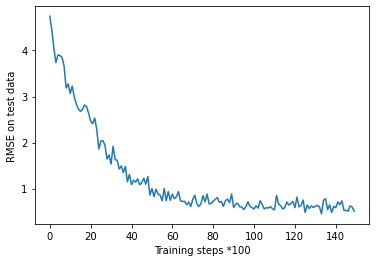

In [313]:
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.set_xlabel("Training steps *100")
ax.set_ylabel("RMSE on test data")
plt.plot(rmse_evolution)
plt.show()

<Figure size 720x360 with 0 Axes>

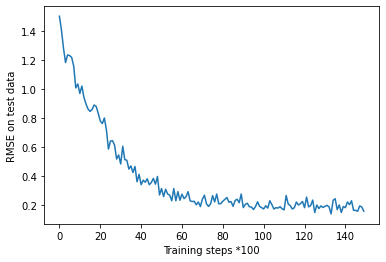

In [316]:
for i in range(len(rmse_evolution)):
    rmse_evolution[i] = rmse_evolution[i]/(10**0.5)
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.set_xlabel("Training steps *100")
ax.set_ylabel("RMSE on test data")
plt.plot(rmse_evolution)
plt.show()

In [274]:
min_amp,max_amp,min_phase,max_phase,min_x,max_x = 0.1, 5, 0, np.pi, -5, 5 #Classic ones
#min_amp,max_amp,min_phase,max_phase,min_x,max_x = -1, 1, 0, np.pi/3, -3, 3 #It sucks

sine_tasks=SineDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
#NPs like: -1, 1, 0, np.pi/3, -3, 3
#Classic: 0.1, 5, 0, np.pi, -5, 5
net=SineNet()
net=net.to(device)
maml=SineMAML(net,alpha=0.01,beta=0.001,tasks=sine_tasks,k=10,m=3,N=5, num_metatasks=10)

rmse_evolution = []
for train_step in range(1):
    maml.outer_loop(num_epochs=100)

    K=10
    num_iterations = 1
    function_tasks = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
    global_error = 0

    for i in range(num_iterations):
        og_net=maml.net.net
        optim=torch.optim.SGD
        lr=0.01
        plt.figure(figsize=(10,5))
        task=function_tasks.sample_task()
        x,y=task.sample_data(K)
        x=x.to(device)
        y=y.to(device)

        outputs,axis=test(og_net,x,y,lr,optim)
  
        error = 0
        L = []
        for i in range(len(x.numpy())):
            L.append(int((5+x.numpy()[i][0])*100))
        pred = []
        for i in range(len(x.numpy())):
            pred.append(outputs['minitrained'][L[i]][0])
        y_ = []
        for i in range(len(y.numpy())):
            y_.append(y.numpy()[i][0])
            print(i)
        global_error+=(np.linalg.norm(np.array(y_)-np.array(pred)))
    global_error = global_error/num_iterations
    rmse_evolution.append(global_error)

100/100. loss: 2.004996653556824
[0.2756217420101166, 0.2566585838794708, 0.23975524306297302, 0.22471602261066437, 0.21135827898979187, 0.1995086371898651, 0.18900340795516968, 0.17968998849391937, 0.17142657935619354, 0.16413690149784088]
0
1
2
3
4
5
6
7
8
9


<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


<Figure size 720x360 with 0 Axes>

In [275]:
(rmse_evolution)

[1.7762444019317627]

### Saved

In [267]:
rmse_copy = rmse_evolution.copy()

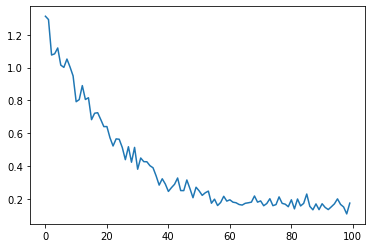

In [262]:
plt.plot(rmse_evolution)

<Figure size 720x360 with 0 Axes>

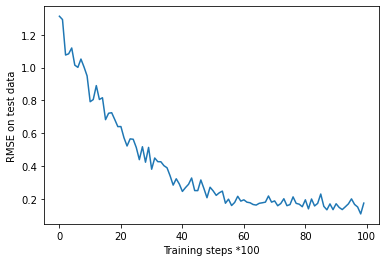

In [269]:
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.set_xlabel("Training steps *100")
ax.set_ylabel("RMSE on test data")
plt.plot(rmse_evolution)
plt.show()

# Plots

In [25]:
def plot_test(og_net,x,y,task,optim=torch.optim.SGD,lr=0.01):
  outputs,axis=test(og_net,x,y,lr,optim)
  plt.figure(figsize=(10,5))
  plt.plot(axis.cpu().clone().numpy(),task.true_sine(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true sine')
  plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
  plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
  plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
  plt.show()

[0.011084563098847866, 0.003821132006123662, 0.0017479624366387725, 0.0009664202225394547, 0.0005939797847531736, 0.0003856586408801377, 0.0002585189649835229, 0.00017762476636562496, 0.00012511570821516216, 9.063588368007913e-05]


<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


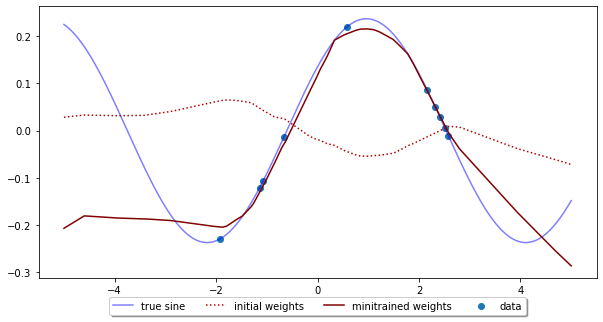

In [32]:
K=10
task=sine_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

# With multiple regressions

<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc6

[0.03489326313138008, 0.012251365929841995, 0.005972270853817463, 0.0033120871521532536, 0.0020946883596479893, 0.0015061761951074004, 0.0012070871889591217, 0.0010484362719580531, 0.0009613071451894939, 0.0009121010079979897]
[0.03960932046175003, 0.01365062315016985, 0.0077795349061489105, 0.005245814099907875, 0.003984459675848484, 0.0032835646998137236, 0.0028528531547635794, 0.0025640898384153843, 0.002355873351916671, 0.0021964902989566326]
[0.03630038723349571, 0.014330211095511913, 0.009134666994214058, 0.0065971845760941505, 0.005167481489479542, 0.004288335796445608, 0.0037094843573868275, 0.003306034253910184, 0.0030104268807917833, 0.002783968346193433]
[0.03883853927254677, 0.013812636025249958, 0.00837844517081976, 0.005977067165076733, 0.0046849967911839485, 0.003896532580256462, 0.003372278530150652, 0.0030016552191227674, 0.002726620063185692, 0.002513943240046501]
[0.03912325203418732, 0.013873944990336895, 0.008543169125914574, 0.00630651181563735, 0.0051286439411342

<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc6

[0.10596492141485214, 0.06387798488140106, 0.05844530463218689, 0.05530070140957832, 0.053079284727573395, 0.051366887986660004, 0.04998662322759628, 0.04884394258260727, 0.04788067191839218, 0.04705801233649254]
[0.11581072956323624, 0.0710405483841896, 0.06561268866062164, 0.06247677654027939, 0.06025801971554756, 0.0585506446659565, 0.057181216776371, 0.05605529621243477, 0.05511379987001419, 0.054316919296979904]
[0.1130056232213974, 0.07387727499008179, 0.06924297660589218, 0.06638016551733017, 0.06425170600414276, 0.06255324929952621, 0.06115376949310303, 0.059980131685733795, 0.058984626084566116, 0.05813342332839966]
[0.12290674448013306, 0.0871913954615593, 0.08177226781845093, 0.0781705230474472, 0.07542072236537933, 0.07320676743984222, 0.07137482613325119, 0.06983397901058197, 0.06852377951145172, 0.06740111112594604]
[0.130554661154747, 0.09253382682800293, 0.08697807043790817, 0.08343859761953354, 0.08081189543008804, 0.07873696088790894, 0.07703940570354462, 0.0756187438

<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc6

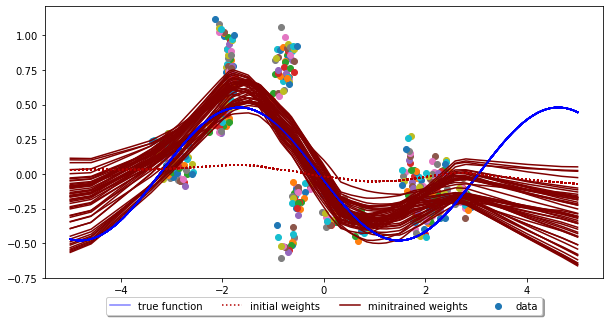

In [38]:
K=10
num_iterations = 50
function_tasks = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)

og_net=maml.net.net
optim=torch.optim.SGD
lr=0.01
plt.figure(figsize=(10,5))
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
epsilon = 0.05
output_sum = [0 for i in range(1000)]

error = 0

x = x + epsilon*torch.randn(1, K, 1)
y= y + epsilon*torch.randn(1, K, 1)
outputs,axis=test(og_net,x,y,lr,optim)
plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)


for i in range(num_iterations):

    x = x + epsilon*torch.randn(1, K, 1)
    y= y + epsilon*torch.randn(1, K, 1)
    outputs,axis=test(og_net,x,y,lr,optim)
    #print(outputs['minitrained'])
    for k in range(1000):
        output_sum[k] += (outputs['minitrained'][k])
        
    a = outputs['minitrained']
    L = [] 
    for i in range(len(a)):
        L.append(a[i][0])
    L = np.array(L)

    error += np.linalg.norm(task.true_function(axis.cpu().clone().numpy()) - L)
    
    plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
    plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

error = error/num_iterations
output_sum = (np.array(output_sum)/num_iterations).tolist()
plt.show()

<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc6

[0.1841985285282135, 0.02485608123242855, 0.012963073328137398, 0.009667016565799713, 0.007527858950197697, 0.0059626963920891285, 0.004805442411452532, 0.0039480021223425865, 0.003311610547825694, 0.002838360844179988]
[0.20061323046684265, 0.03204740211367607, 0.01717240735888481, 0.0129313375800848, 0.010248708538711071, 0.008306573145091534, 0.006879397667944431, 0.005826632492244244, 0.005047507118433714, 0.004468757659196854]
[0.21454226970672607, 0.03628309443593025, 0.02028759755194187, 0.015497651882469654, 0.0124078169465065, 0.010152517817914486, 0.008482946082949638, 0.007241516374051571, 0.006314641330391169, 0.005619365256279707]
[0.21018441021442413, 0.033022619783878326, 0.01879614219069481, 0.014483587816357613, 0.011638596653938293, 0.009558748453855515, 0.008022788912057877, 0.006884584669023752, 0.006038185209035873, 0.0054061757400631905]
[0.200799822807312, 0.025668883696198463, 0.014141319319605827, 0.011435816064476967, 0.009707088582217693, 0.00842699222266674,

<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc6

[0.2009955197572708, 0.032283227890729904, 0.026693129912018776, 0.024405227974057198, 0.022679850459098816, 0.02135392464697361, 0.020334426313638687, 0.019550442695617676, 0.018947457894682884, 0.018483612686395645]
[0.20615024864673615, 0.03553859144449234, 0.02953079342842102, 0.026869511231780052, 0.024873722344636917, 0.023353708907961845, 0.02219514176249504, 0.02131154015660286, 0.02063714526593685, 0.020121930167078972]
[0.22019536793231964, 0.04708395153284073, 0.03886919468641281, 0.03554147854447365, 0.03312315419316292, 0.0313144326210022, 0.02995680831372738, 0.02893419936299324, 0.028160523623228073, 0.027571871876716614]
[0.21721196174621582, 0.046687331050634384, 0.04084192216396332, 0.03808412328362465, 0.03604444861412048, 0.034514136612415314, 0.03336133807897568, 0.032488659024238586, 0.031823910772800446, 0.03131354600191116]
[0.2398880422115326, 0.04787536710500717, 0.041163112968206406, 0.03807220980525017, 0.03578611835837364, 0.03406847268342972, 0.03277220204

<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-23-d8737d7fc6

[0.2497292459011078, 0.0458233505487442, 0.04042823240160942, 0.03725064545869827, 0.03474140912294388, 0.03275218978524208, 0.031173542141914368, 0.029919108375906944, 0.028920680284500122, 0.028124427422881126]
[0.27559953927993774, 0.04882688447833061, 0.04251617193222046, 0.039104290306568146, 0.03642938658595085, 0.03431915491819382, 0.03265243023633957, 0.03133418783545494, 0.030289825052022934, 0.029460769146680832]
[0.28013738989830017, 0.042012132704257965, 0.03565279766917229, 0.03246181085705757, 0.02995518408715725, 0.027970826253294945, 0.026398900896310806, 0.02515290305018425, 0.02416449598968029, 0.023379644379019737]
[0.28990933299064636, 0.051101673394441605, 0.04372111335396767, 0.03956715017557144, 0.03628245368599892, 0.03367019444704056, 0.03159143030643463, 0.029936153441667557, 0.02861703932285309, 0.027564745396375656]
[0.28206393122673035, 0.05756916478276253, 0.04909936338663101, 0.04406142234802246, 0.0400969497859478, 0.036957986652851105, 0.034470181912183

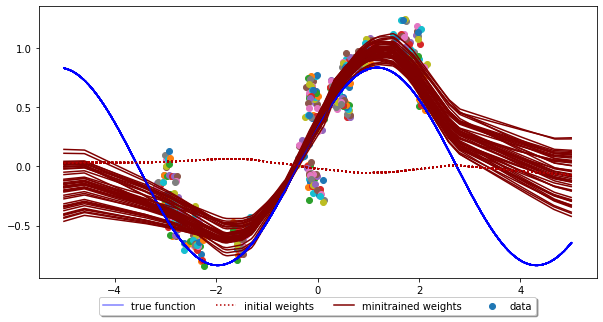

In [42]:
K=10
num_iterations = 50
function_tasks = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)

og_net=maml.net.net
optim=torch.optim.SGD
lr=0.01
plt.figure(figsize=(10,5))
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
epsilon = 0.05
output_sum = [0 for i in range(1000)]

error = 0

x = x + epsilon*torch.randn(1, K, 1)
y= y + epsilon*torch.randn(1, K, 1)
outputs,axis=test(og_net,x,y,lr,optim)
plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)


for i in range(num_iterations):

    x = x + epsilon*torch.randn(1, K, 1)
    y= y + epsilon*torch.randn(1, K, 1)
    outputs,axis=test(og_net,x,y,lr,optim)
    #print(outputs['minitrained'])
    for k in range(1000):
        output_sum[k] += (outputs['minitrained'][k])
        
    a = outputs['minitrained']
    L = [] 
    for i in range(len(a)):
        L.append(a[i][0])
    L = np.array(L)

    error += np.linalg.norm(task.true_function(axis.cpu().clone().numpy()) - L)
    
    plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
    plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

error = error/num_iterations
output_sum = (np.array(output_sum)/num_iterations).tolist()
plt.show()

In [143]:
x = x + epsilon*torch.randn(1, K, 1)
y= y + epsilon*torch.randn(1, K, 1)
outputs,axis=test(og_net,x,y,lr,optim)
    #print(outputs['minitrained'])

a = outputs['minitrained']
L = [] 
for i in range(len(a)):
    L.append(a[i][0])
L = np.array(L)

[7.309538841247559, 0.8796015977859497, 0.2613123059272766, 0.09726245701313019, 0.06130693480372429, 0.044713426381349564, 0.0357714481651783, 0.030195215716958046, 0.026272963732481003, 0.023261185735464096]


<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-24-d8737d7fc6

[3.8008835315704346, 1.0532002449035645, 0.08054203540086746, 0.025881001725792885, 0.02058384008705616, 0.018240898847579956, 0.01660894602537155, 0.015305806882679462, 0.014235325157642365, 0.013348223641514778]
[3.7976508140563965, 1.1000947952270508, 0.07271923124790192, 0.027206048369407654, 0.02316255308687687, 0.0214387197047472, 0.02014073356986046, 0.019076619297266006, 0.018186625093221664, 0.01743405871093273]
[3.7370009422302246, 1.1124171018600464, 0.08066220581531525, 0.03495097905397415, 0.03122803568840027, 0.02966470643877983, 0.028550753369927406, 0.02761617861688137, 0.026805277913808823, 0.026091555133461952]
[3.7318408489227295, 1.1276609897613525, 0.08720899373292923, 0.04139161854982376, 0.03699389100074768, 0.035284869372844696, 0.03399854153394699, 0.03291548416018486, 0.0320187471807003, 0.031221885234117508]
[3.7475509643554688, 1.0853965282440186, 0.09797482192516327, 0.04125005006790161, 0.03690817207098007, 0.035294853150844574, 0.033700697124004364, 0.032

<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-24-d8737d7fc6

[3.599025249481201, 1.563717246055603, 0.10511445999145508, 0.06833820044994354, 0.06685278564691544, 0.06605645269155502, 0.0653819665312767, 0.06478983163833618, 0.06426531821489334, 0.06379744410514832]
[3.5895705223083496, 1.571962833404541, 0.09214472025632858, 0.06901764869689941, 0.06711728870868683, 0.06614191830158234, 0.06544776260852814, 0.06545993685722351, 0.06475801765918732, 0.06504569947719574]
[3.6524429321289062, 1.439368486404419, 0.13079938292503357, 0.08617651462554932, 0.08254778385162354, 0.08016211539506912, 0.07824594527482986, 0.07672470808029175, 0.07609666883945465, 0.07444670796394348]
[3.5389723777770996, 1.3531709909439087, 0.12930406630039215, 0.09420987963676453, 0.09164045751094818, 0.08920791000127792, 0.08744997531175613, 0.08598954975605011, 0.08473879843950272, 0.08366503566503525]
[3.438203811645508, 1.3362147808074951, 0.12545181810855865, 0.09545627236366272, 0.09258858114480972, 0.09040592610836029, 0.08859965950250626, 0.08706384897232056, 0.0

<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
<ipython-input-24-d8737d7fc6

[3.17319917678833, 1.6886485815048218, 0.16306667029857635, 0.10422857105731964, 0.09676234424114227, 0.09475035965442657, 0.09607795625925064, 0.09350229799747467, 0.09189830720424652, 0.0926334336400032]
[3.0943164825439453, 1.6726744174957275, 0.16623684763908386, 0.12190970033407211, 0.11639280617237091, 0.1171935573220253, 0.11513169854879379, 0.11429544538259506, 0.11357495933771133, 0.11199754476547241]
[3.1557106971740723, 1.751765489578247, 0.20471961796283722, 0.1379561722278595, 0.1388467252254486, 0.13894912600517273, 0.1329101324081421, 0.13575994968414307, 0.13588687777519226, 0.13006441295146942]
[3.0944619178771973, 1.7683700323104858, 0.19326184689998627, 0.13692370057106018, 0.12923923134803772, 0.12816384434700012, 0.125308558344841, 0.12610092759132385, 0.12496564537286758, 0.12060870230197906]
[3.116283893585205, 1.9364808797836304, 0.16513694822788239, 0.1305321902036667, 0.13032940030097961, 0.12821054458618164, 0.1263730525970459, 0.12683400511741638, 0.12410577

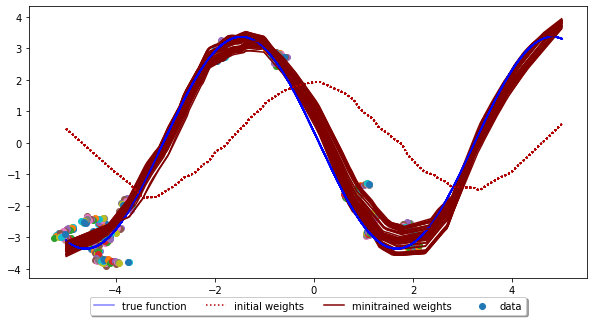

In [121]:
K=10
num_iterations = 50
function_tasks = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)

og_net=maml.net.net
optim=torch.optim.SGD
lr=0.01
plt.figure(figsize=(10,5))
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
epsilon = 0.05
output_sum = [0 for i in range(1000)]

error = 0

x = x + epsilon*torch.randn(1, K, 1)
y= y + epsilon*torch.randn(1, K, 1)
outputs,axis=test(og_net,x,y,lr,optim)
plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)


for i in range(num_iterations):

    x = x + epsilon*torch.randn(1, K, 1)
    y= y + epsilon*torch.randn(1, K, 1)
    outputs,axis=test(og_net,x,y,lr,optim)
    #print(outputs['minitrained'])
    for k in range(1000):
        output_sum[k] += (outputs['minitrained'][k])
        
    a = outputs['minitrained']
    L = [] 
    for i in range(len(a)):
        L.append(a[i][0])
    L = np.array(L)
    error += np.linalg.norm(task.true_function(axis.cpu().clone().numpy()) - L)
    
    plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
    plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

error = error/num_iterations # not the right one
output_sum = (np.array(output_sum)/num_iterations).tolist()
plt.show()

# Computing the global error

In [311]:
K=10
num_iterations = 100
function_tasks = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
global_error = 0

for i in range(num_iterations):
    og_net=maml.net.net
    optim=torch.optim.SGD
    lr=0.01
    task=function_tasks.sample_task()
    x,y=task.sample_data(K)
    x=x.to(device)
    y=y.to(device)

    outputs,axis=test(og_net,x,y,lr,optim)
  
    error = 0
    L = []
    for i in range(len(x.numpy())):
        L.append(int((5+x.numpy()[i])*100))
        
    pred = []
    for i in range(len(x.numpy())):
        pred.append(outputs['minitrained'][L[i]][0])
    y_ = []
    for i in range(len(y.numpy())):
        y_.append(y.numpy()[i][0])
    global_error+=(np.linalg.norm(np.array(y_)-np.array(pred)))

global_error = global_error/num_iterations

<ipython-input-24-d8737d7fc628>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()


[1.862200140953064, 1.073958158493042, 0.323121041059494, 0.17266656458377838, 0.07711248099803925, 0.045776911079883575, 0.02472163364291191, 0.016198646277189255, 0.010586188174784184, 0.007843961007893085]
[0.23718269169330597, 0.07288555800914764, 0.03749939799308777, 0.020497124642133713, 0.01302332617342472, 0.009402639232575893, 0.007444347254931927, 0.006202253047376871, 0.005319580901414156, 0.004679274745285511]
[1.898568868637085, 0.5199044942855835, 0.07937793433666229, 0.028295665979385376, 0.021927278488874435, 0.019688624888658524, 0.017936380580067635, 0.016552802175283432, 0.015398477204144001, 0.014408583752810955]
[3.7986717224121094, 0.8365122079849243, 0.2547888159751892, 0.11375514417886734, 0.05974055081605911, 0.03572731837630272, 0.023065565153956413, 0.016150860115885735, 0.0120206568390131, 0.009241561405360699]
[0.2267804592847824, 0.11241171509027481, 0.07672808319330215, 0.06266376376152039, 0.0560481920838356, 0.04639158397912979, 0.03456356003880501, 0.0

[0.0730929970741272, 0.03401414304971695, 0.015507623553276062, 0.007713099475950003, 0.0044085560366511345, 0.0029632272198796272, 0.002299605868756771, 0.002018706174567342, 0.0018460266292095184, 0.0017389210406690836]
[3.4223225116729736, 0.5875548124313354, 0.19196344912052155, 0.08892109245061874, 0.04552612081170082, 0.03335309773683548, 0.025014270097017288, 0.020294655114412308, 0.017560595646500587, 0.015556851401925087]
[0.536548912525177, 0.19895417988300323, 0.10304026305675507, 0.04354118928313255, 0.024054620414972305, 0.01055360957980156, 0.006648010574281216, 0.004375474061816931, 0.0033417909871786833, 0.0027280128560960293]
[1.6578998565673828, 0.27354899048805237, 0.03830286115407944, 0.014070947654545307, 0.006716207601130009, 0.005438517313450575, 0.004848350305110216, 0.004423605743795633, 0.00400081742554903, 0.003656939370557666]
[1.8666794300079346, 0.29800844192504883, 0.026634857058525085, 0.010229447856545448, 0.005519497208297253, 0.00342170475050807, 0.00

In [312]:
print(global_error)
print(global_error/(10**0.5))

0.5901810546219349
0.18663163644855588
